In [2]:
%matplotlib inline
import foggie
from astropy.table import Table
from astropy.convolution import Gaussian1DKernel, convolve_fft
import astropy.constants as const
import astropy.units as u
from glob import glob
import yt
plt.rcParams['text.usetex'] = True
cmp = plt.cm.viridis
cmp.set_bad('k')
import warnings
warnings.filterwarnings('ignore')
clrs = {'cold': 'darkblue',
        'warm': 'indianred',
        'warmhot': 'red',
        'hot': 'darkred',
        'stars': 'goldenrod',
        'dm': 'black',
        'baryons': 'green'}


<ipython-input-2-a1300bf2a4b8>:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmp.set_bad('k')


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [5]:
def flatten_thelphil(bins, Lhst, Mhst):
    t = np.mean((bins[-2][:-1], bins[-2][1:]), axis = 0)
    p = np.mean((bins[-1][:-1], bins[-1][1:]), axis = 0)
    TT, PP = np.meshgrid(t, p[::-1])
    TTrad = TT*pi/180
    PPrad = PP*pi/180
    x = Lhst * sin(PPrad) * cos(TTrad)
    y = Lhst * sin(PPrad) * sin(TTrad)
    z = Lhst * cos(PPrad)

    x_sum = np.nansum(x)*u.g*u.cm**2./u.s
    y_sum = np.nansum(y)*u.g*u.cm**2./u.s
    z_sum = np.nansum(z)*u.g*u.cm**2./u.s

    L_sum = np.sqrt(x_sum**2 + y_sum**2. + z_sum**2)
    thel_mean = np.arctan2(y_sum,x_sum)*180./pi
    phil_mean = np.arccos(z_sum/L_sum)*180./pi
    L_sum = L_sum
    M_sum = np.sum(Mhst)*u.Msun
    j_sum = L_sum/M_sum
    return L_sum, j_sum.to('cm**2/s'), thel_mean, phil_mean, x_sum/M_sum, y_sum/M_sum, z_sum/M_sum, M_sum

In [18]:
halos = ['8508', '5016', '5036', '4123', '2392',  '2878'][:3]
mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars']#, 'stars', 'dm'][1:2]
vel_types  = [('negv',   np.arange(0, 3)),
              ('posv',   np.arange(3, 6))]

redshift_all, j_sum_all = {}, {}
for halo in halos:
    j_sum_all[halo] = {}
    redshift_all[halo] = []
    for mtype in mass_types:
        j_sum_all[halo][mtype] = {}
        for (vtype, vel_argselect) in vel_types:                
            j_sum_all[halo][mtype][vtype] = {}
            j_sum_all[halo][mtype][vtype]['jdiff'] = []
            j_sum_all[halo][mtype][vtype]['theta'] = []
            j_sum_all[halo][mtype][vtype]['Ldiff'] = []
            
for halo in halos:
    if halo == '8508':
        DD_fls = sort(glob('/Users/rsimons/Dropbox/foggie/angular_momentum/new_profiles_temp/%s/Lprof_%s_DD????.npy'%(halo, halo)))
    else: 
        DD_fls = sort(glob('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_DD????.npy'%(halo, halo)))
        
    rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/00%s/nref11c_nref9f/rvir_masses.hdf5'%halo)
    
    for DD_fl in DD_fls:
        Lprof = np.load(DD_fl, allow_pickle = True)[()]
        DD = DD_fl.split('/')[-1][-10:-4]
        rvir_test = rvir_masses['radius'][rvir_masses['snapshot'] == DD].data
        redshift  = rvir_masses['redshift'][rvir_masses['snapshot'] == DD].data

        if len(rvir_test) > 0:
            rvir = rvir_test[0]
        else:
            continue
        bins   = Lprof[mtype]['r_dist']['hst_bins']
        arg_use = int(np.floor(np.interp(rvir, bins[0], np.arange(len(bins[0])))))
        cs_dic = {}
        for vtype in ['posv', 'negv']:
            cs_dic[vtype] = {}

            cs_dic[vtype]['jx_sum_cs_all'] = 0
            cs_dic[vtype]['jy_sum_cs_all'] = 0
            cs_dic[vtype]['jz_sum_cs_all'] = 0
            cs_dic[vtype]['M_sum_cs_all'] = 0
            cs_dic[vtype]['j_sum_cs_all'] = 0
            
            for mmtype in ['cold', 'warm', 'warmhot', 'hot', 'stars']:
                if 'neg' in vtype:
                    Lhst_full_cs = Lprof[mmtype]['r_dist']['L_hst'][:arg_use]
                    Mhst_full_cs = Lprof[mmtype]['r_dist']['M_hst'][:arg_use]
                elif 'pos' in vtype:
                    Lhst_full_cs = Lprof[mmtype]['r_dist']['L_hst'][:arg_use+1]
                    Mhst_full_cs = Lprof[mmtype]['r_dist']['M_hst'][:arg_use+1]

                dim_tuple = tuple(np.arange(Lhst_full_cs.ndim-2))

                Lhst_cs  = np.rot90(np.nansum(Lhst_full_cs, axis = dim_tuple))
                Mhst_cs  = np.rot90(np.nansum(Mhst_full_cs, axis = dim_tuple))

                L_sum_cs, j_sum_cs, thel_mean_cs, phil_mean_cs, jx_sum_cs, jy_sum_cs, jz_sum_cs, M_sum_cs = flatten_thelphil(bins, Lhst_cs, Mhst_cs)
                cs_dic[vtype]['jx_sum_cs_all'] += jx_sum_cs
                cs_dic[vtype]['jy_sum_cs_all'] += jy_sum_cs
                cs_dic[vtype]['jz_sum_cs_all'] += jz_sum_cs
                cs_dic[vtype]['M_sum_cs_all']  += M_sum_cs
                

            cs_dic[vtype]['j_sum_cs_all'] = np.sqrt(cs_dic[vtype]['jx_sum_cs_all']**2. + cs_dic[vtype]['jy_sum_cs_all']**2. + cs_dic[vtype]['jz_sum_cs_all']**2.)
        redshift_all[halo].append(float(redshift))
        for mm, mtype in enumerate(mass_types):
            for (vtype, vel_argselect) in vel_types:                
                Lhst_full = Lprof[mtype]['r_dist']['L_hst'][arg_use, vel_argselect]
                Mhst_full = Lprof[mtype]['r_dist']['M_hst'][arg_use, vel_argselect]
                dim_tuple = tuple(np.arange(Lhst_full.ndim-2))
                Lhst  = np.rot90(np.nansum(Lhst_full, axis = dim_tuple))
                Mhst  = np.rot90(np.nansum(Mhst_full, axis = dim_tuple))
                L_sum, j_sum, thel_mean, phil_mean, jx_sum, jy_sum, jz_sum, M_sum = flatten_thelphil(bins, Lhst, Mhst)
                if 'neg' in vtype: 
                    pint = 1.
                else: 
                    pint = -1.
                jx_sum_cs_all = cs_dic[vtype]['jx_sum_cs_all']
                jy_sum_cs_all = cs_dic[vtype]['jy_sum_cs_all']
                jz_sum_cs_all = cs_dic[vtype]['jz_sum_cs_all']
                M_sum_cs_all  = cs_dic[vtype]['M_sum_cs_all'] 
                j_sum_cs_all  = cs_dic[vtype]['j_sum_cs_all'] 
                
                if 'neg' in vtype: tot_new_mass = M_sum_cs_all + M_sum
                else: tot_new_mass = M_sum_cs_all - M_sum
                L_sum_new =   np.sqrt((jx_sum_cs_all   * M_sum_cs_all  + pint * jx_sum * M_sum)**2. 
                                    + (jy_sum_cs_all   * M_sum_cs_all  + pint * jy_sum * M_sum)**2. 
                                    + (jz_sum_cs_all   * M_sum_cs_all  + pint * jz_sum * M_sum)**2.)
              
                j_diff = L_sum_new/tot_new_mass - j_sum_cs_all
                L_diff = L_sum_new - j_sum_cs_all * M_sum_cs_all
                j_sum_all[halo][mtype][vtype]['jdiff'].append(j_diff.value)
                j_sum_all[halo][mtype][vtype]['Ldiff'].append(L_diff.value)
                
                xx = np.array([jx_sum.value,        jy_sum.value,        jz_sum.value])
                yy = np.array([jx_sum_cs_all.value, jy_sum_cs_all.value, jz_sum_cs_all.value])
                xnorm = np.sqrt(np.sum(xx**2))
                ynorm = np.sqrt(np.sum(yy**2))
                
                dtprd = (np.dot(xx,yy))/(xnorm * ynorm)
                j_sum_all[halo][mtype][vtype]['theta'].append(180./pi*np.arccos(dtprd))

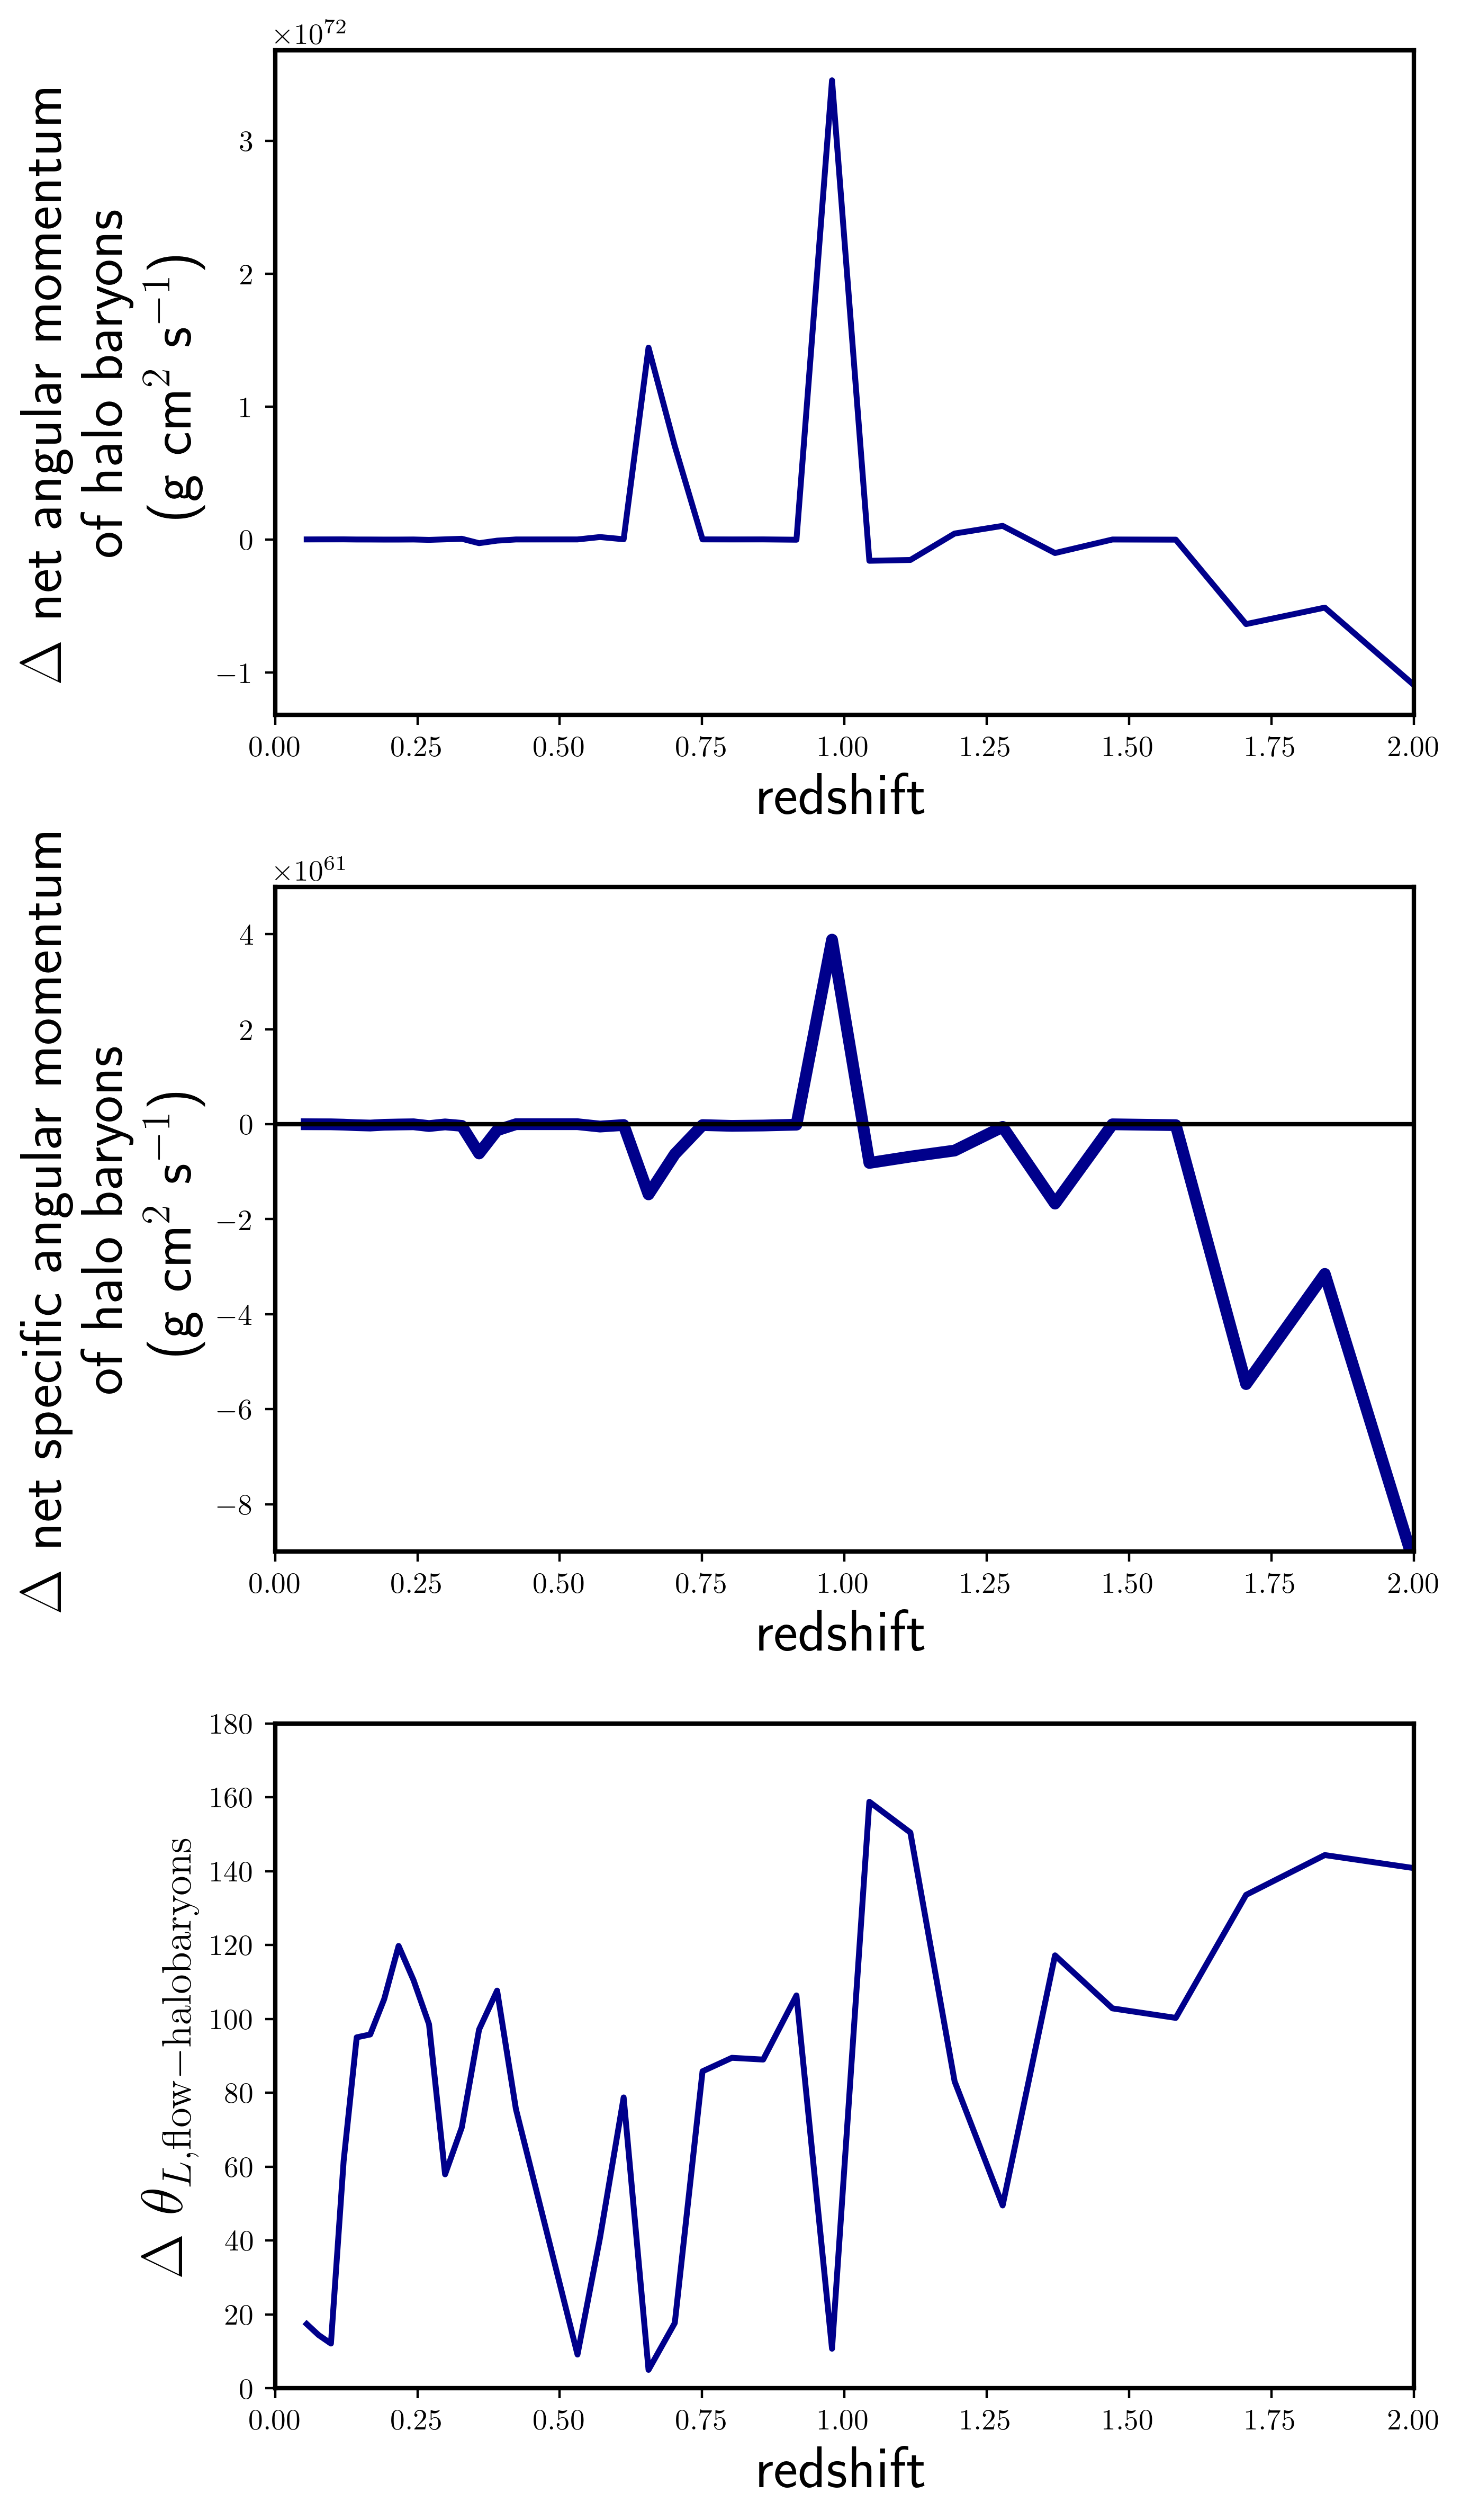

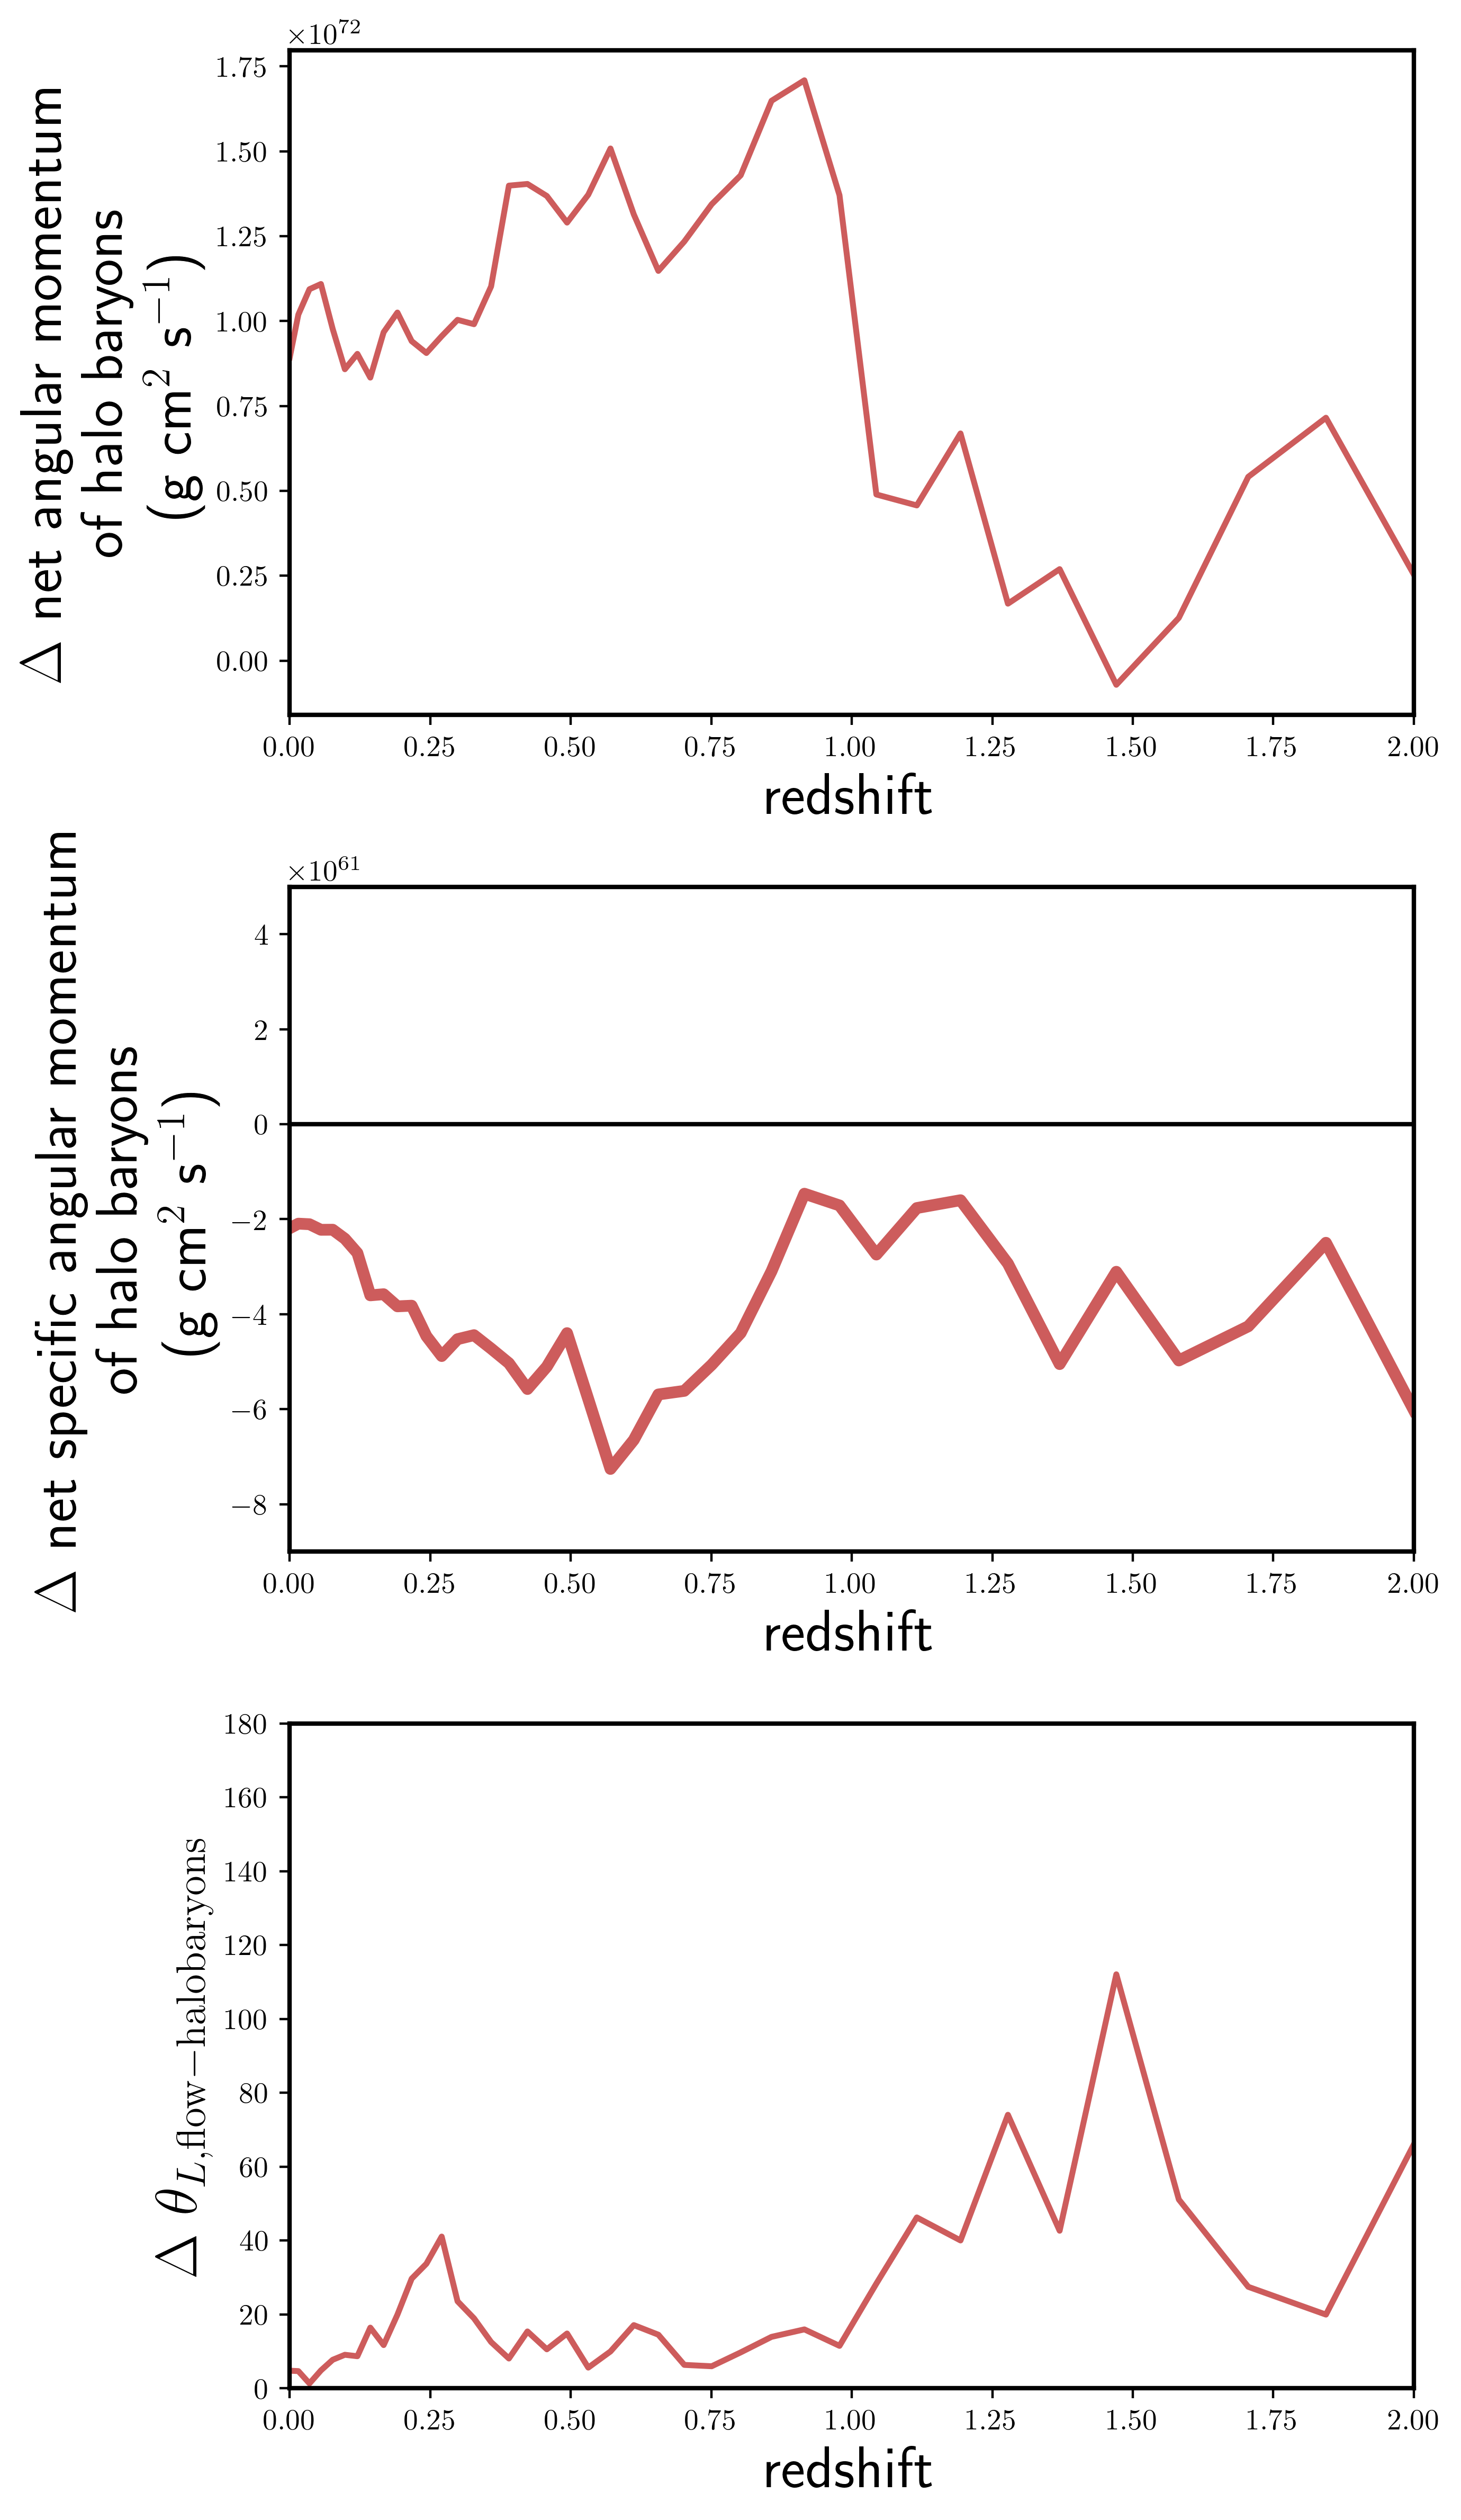

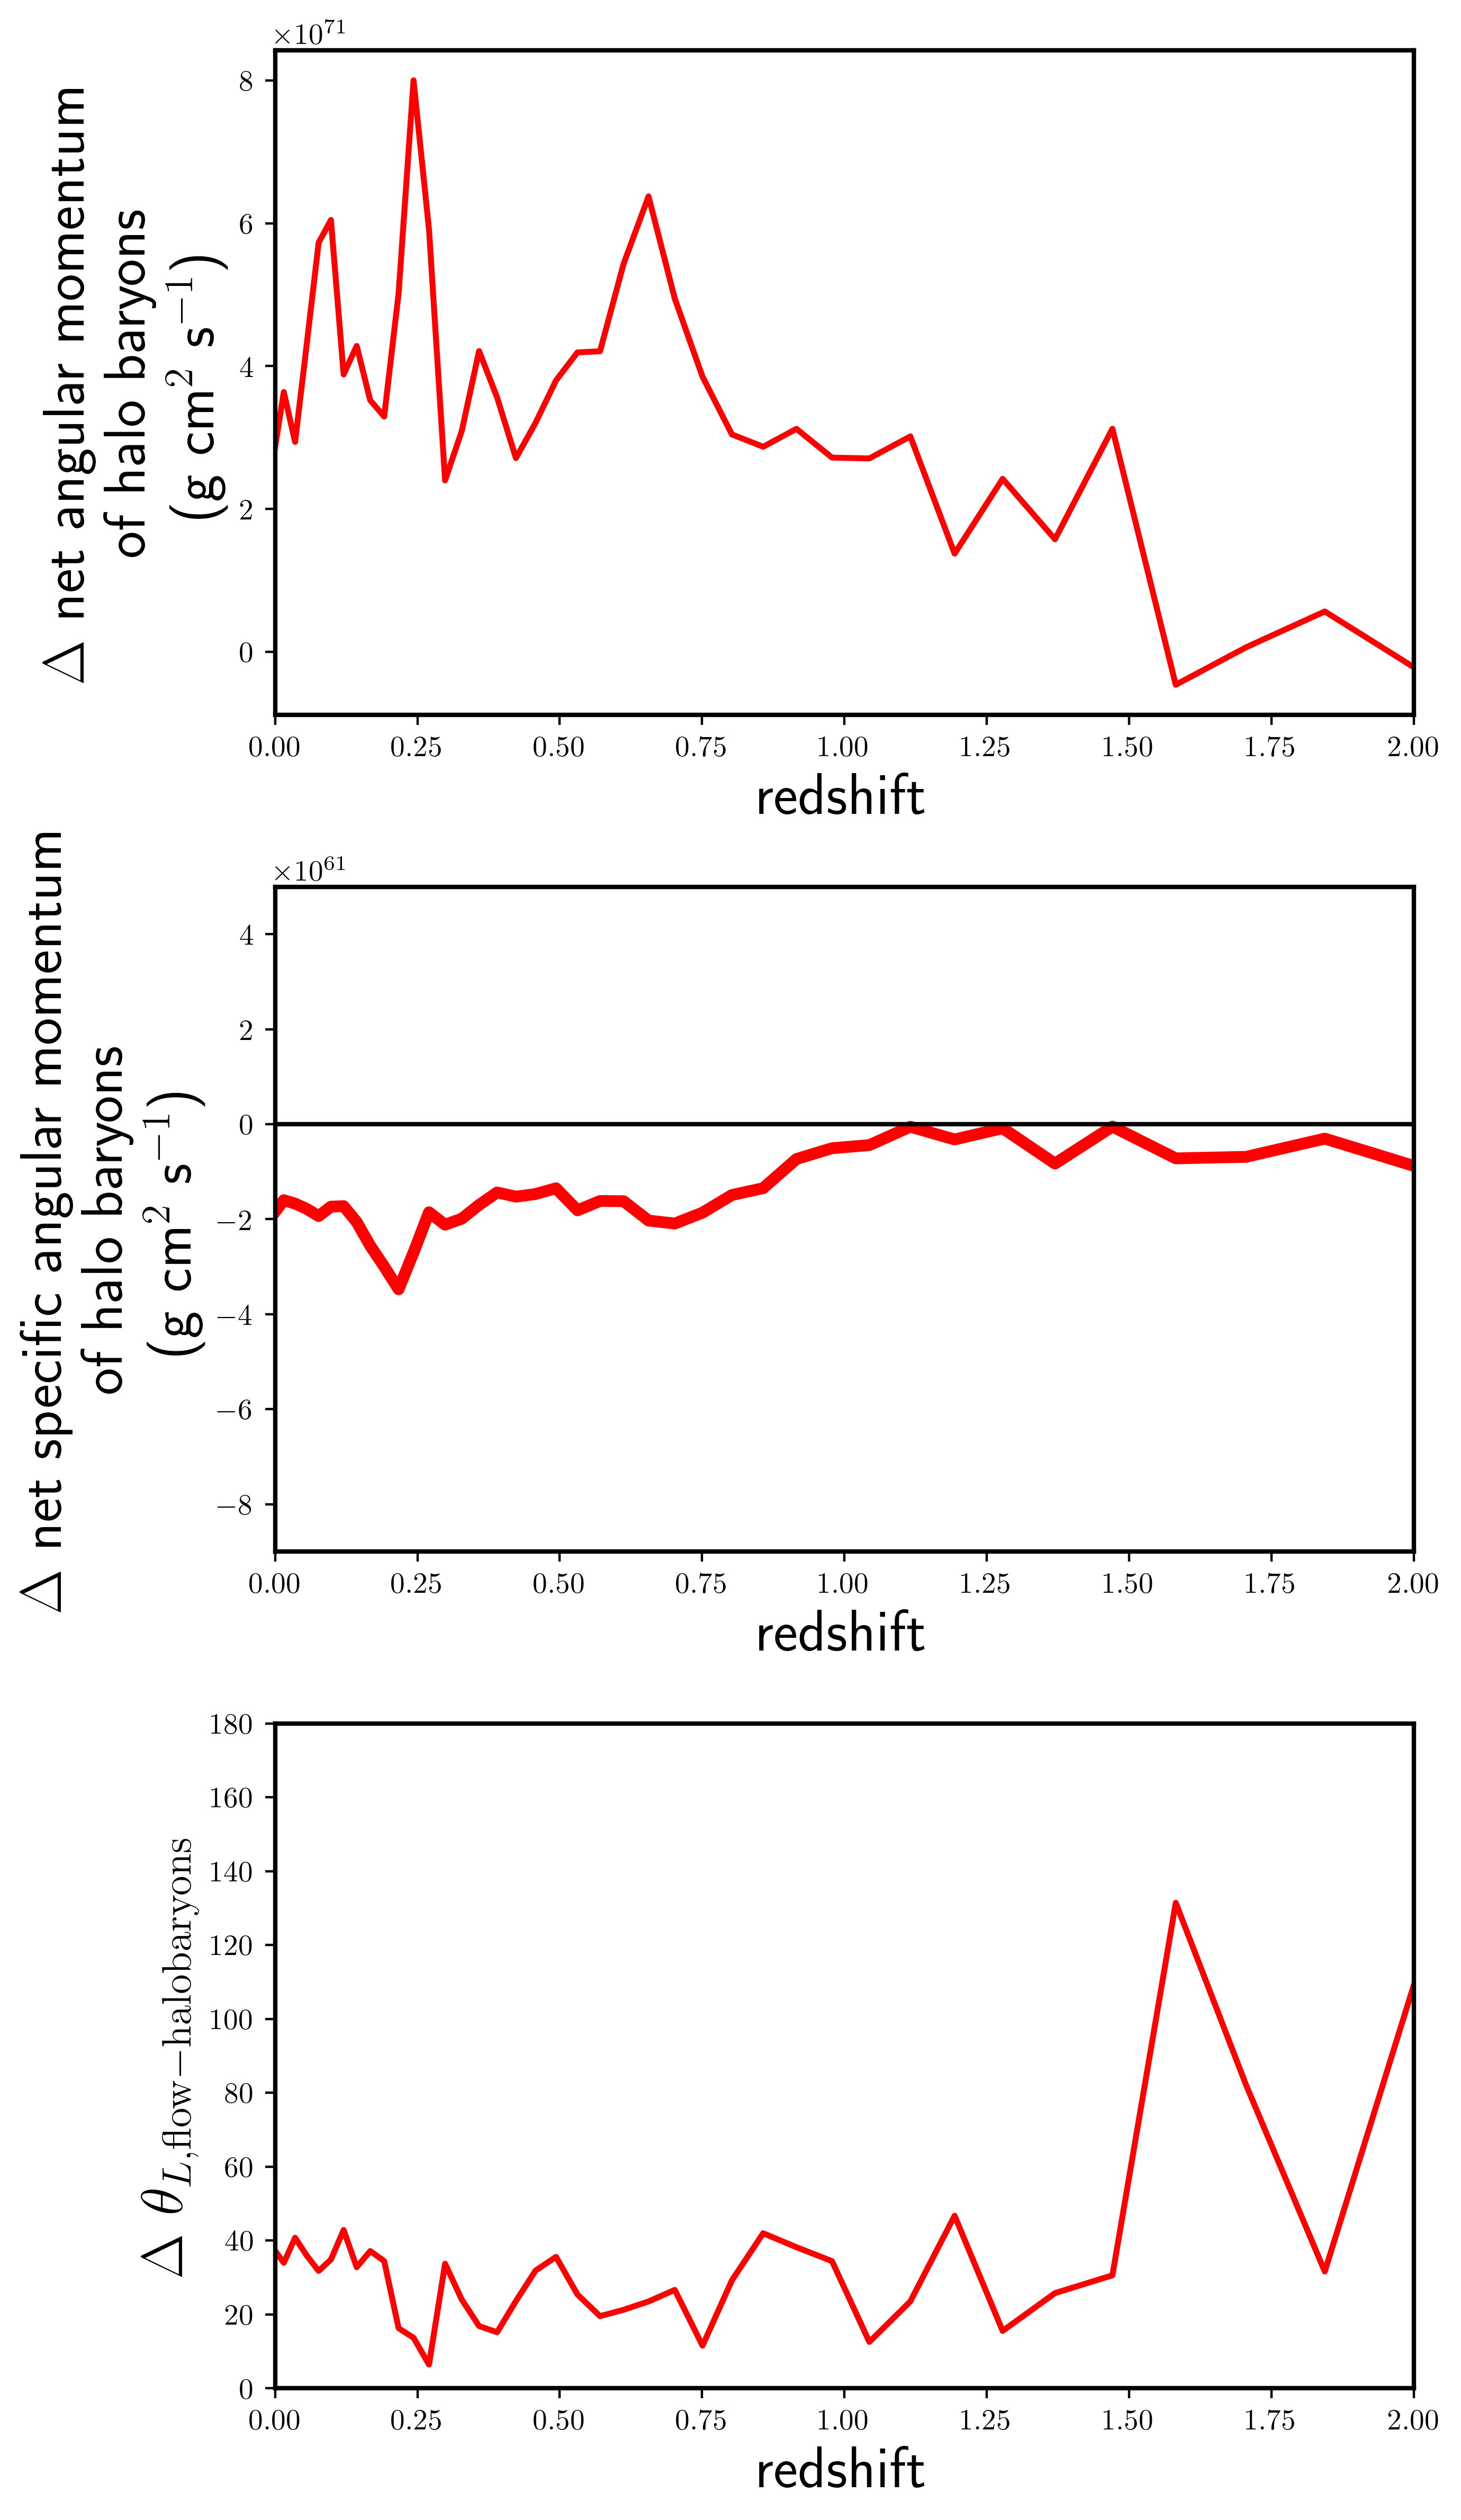

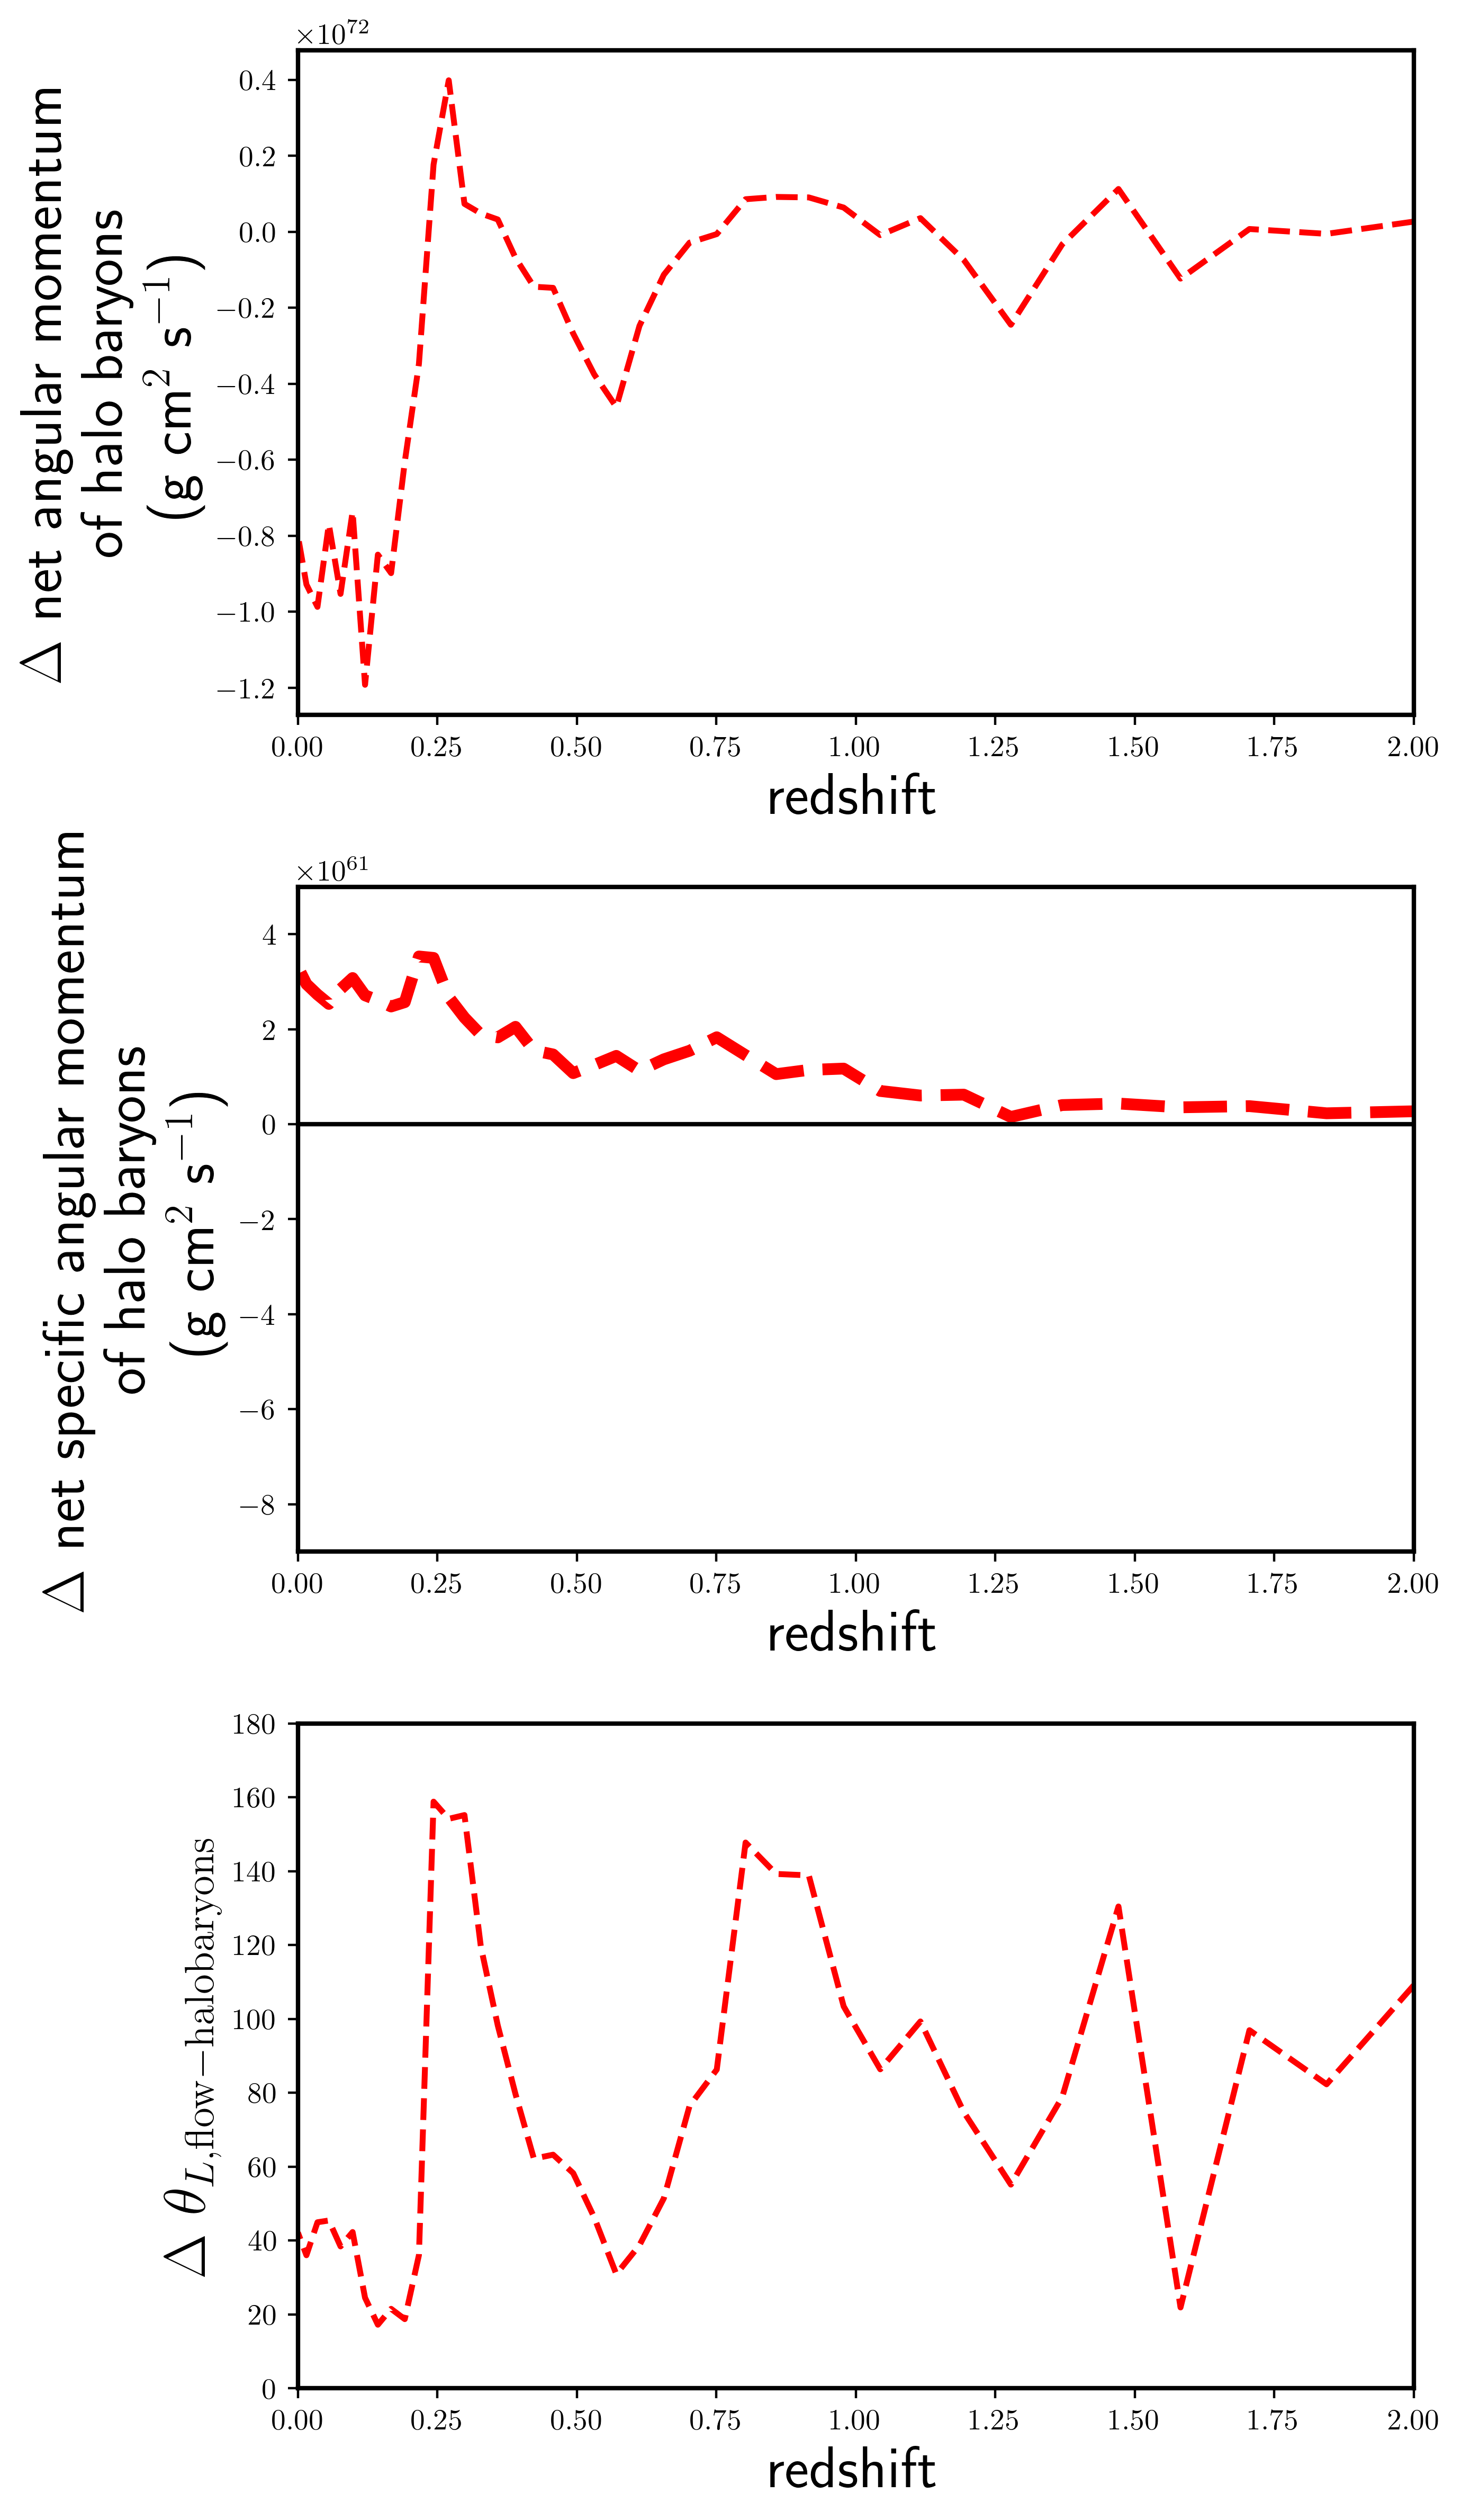

In [19]:
#mass_types = ['cold', 'warm', 'warmhot', 'hot']
for halo in halos[:1]:
    for mtype in mass_types:
        for (vtype, vel_argselect) in vel_types:              
            if (vtype == 'posv') & (mtype == 'warmhot'):
                pass
            elif (vtype == 'negv') & (mtype == 'warmhot'):
                pass
            elif (vtype == 'negv') & (mtype == 'cold'):
                pass
            elif (vtype == 'negv') & (mtype == 'warm'):
                pass
            else:
                continue
            fig, axes = plt.subplots(3,1, figsize = (7, 12), facecolor = 'white')
            gd1 = ~np.isnan(j_sum_all[halo][mtype][vtype]['jdiff'])
            gd2 = ~np.isnan(j_sum_all[halo][mtype][vtype]['theta'])
            
            #if mtype == 'cold': axes[0].set_title(halo, fontsize = 20)
            if 'neg' in vtype: ls = '-'
            else: ls = '--'

            from astropy.convolution import Gaussian1DKernel, convolve_fft
            
            axes[0].plot(np.array(redshift_all[halo])[gd1], np.array(j_sum_all[halo][mtype][vtype]['Ldiff'])[gd1], linestyle = ls, color = clrs[mtype],linewidth = 2, label = mtype + '-' + vtype)
            axes[1].plot(np.array(redshift_all[halo])[gd1], np.array(j_sum_all[halo][mtype][vtype]['jdiff'])[gd1], linestyle = ls, color = clrs[mtype],linewidth = 4, label = mtype + '-' + vtype)
            axes[2].plot(np.array(redshift_all[halo])[gd2], np.array(j_sum_all[halo][mtype][vtype]['theta'])[gd2], linestyle = ls, color = clrs[mtype],linewidth = 2, label = mtype + '-' + vtype)
            for ax in axes:
                ax.set_xlabel('redshift', fontsize = 20)
                ax.set_xlim(0, 2)
            axes[0].set_ylabel('$\Delta$ net angular momentum\nof halo baryons\n(g cm$^2$ s$^{-1}$)', fontsize = 20)
            axes[1].set_ylabel('$\Delta$ net specific angular momentum\nof halo baryons\n(g cm$^2$ s$^{-1}$)', fontsize = 20)
            axes[2].set_ylabel(r'$\Delta$ $\theta_{L, \mathrm{flow-halo baryons}}$', fontsize = 20)
            axes[1].axhline(y = 0, color = 'black')
            #axes[1].set_ylim(-2e62, 1.e62)
            axes[2].set_ylim(0, 180)
            #ax.axhline(y = 0, color = 'black')
            axes[1].set_ylim(-9e61, 5.e61)
            fig.set_dpi(400)
            fig.tight_layout()
            fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/at_Rvir/%s_flows_redshift_minimal_%s_%s.png'%(halo, mtype, vtype))


In [21]:
in_dir = '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles'
rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/008508/nref11c_nref9f/rvir_masses.hdf5')



halos = [(2392, 'DD0581', 'DD1660'),
         (2878, 'DD0581', 'DD0929'),
         (4123, 'DD0581', 'DD2067'),
         (5016, 'DD0581', 'DD2520'),
         (5036, 'DD0581', 'DD2520'),
         (8508, 'DD0487', 'DD2427')]



FileNotFoundError: [Errno 2] No such file or directory: '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/Lprof_8508_DD0500.npy'

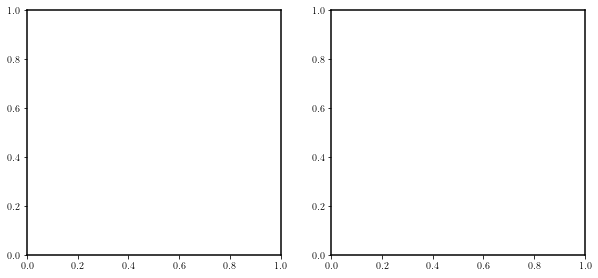

In [22]:
mass_types = ['cold', 'warm', 'warmhot', 'hot',  'stars', 'baryons', 'dm']
for DD in ['0500', '0600', '0700', '0800', '0900', '1000', '1100', '1346', '1600', '2427']:
    fig, axes = plt.subplots(1,2, figsize = (10,4.5), facecolor = 'white')
    rvir = yt.YTArray(rvir_masses['radius'][rvir_masses['snapshot'] == 'DD%s'%DD].data[0], 'kpc')
    mvir = yt.YTArray(rvir_masses['total_mass'][rvir_masses['snapshot'] == 'DD%s'%DD].data[0], 'Msun')
    profile = np.load(in_dir + '/Lprof_8508_DD%s.npy'%DD, allow_pickle = True)[()]
    r  = profile['cold']['rprof']['r']
    all_M  = np.zeros(len(r))
    for ms in mass_types[:-2]:
        all_M += profile[ms]['rprof']['mass']
    all_M += profile['dm']['rprof']['mass']
    for mass in mass_types:
        if mass == 'baryons':
            r  = profile['cold']['rprof']['r']
            Lx = np.zeros(len(r))
            Ly = np.zeros(len(r))
            Lz = np.zeros(len(r))
            M  = np.zeros(len(r))
            for ms in mass_types[:-2]:
                Lx += profile[ms]['rprof']['Lx']
                Ly += profile[ms]['rprof']['Ly']
                Lz += profile[ms]['rprof']['Lz']
                M  += profile[ms]['rprof']['mass']
        else:
            r  = profile[mass]['rprof']['r']
            Lx = profile[mass]['rprof']['Lx']
            Ly = profile[mass]['rprof']['Ly']
            Lz = profile[mass]['rprof']['Lz']
            M  = profile[mass]['rprof']['mass']
        
        L = np.sqrt(Lx**2. + Ly**2. + Lz**2.)
        j = (L/M).to('kpc * km/s')
        G     = yt.physical_constants.G
        Vvir = np.sqrt(G * mvir / rvir)
        lam = j/np.sqrt(2)/rvir/Vvir
        kern = Gaussian1DKernel(2)
        lam = convolve_fft(lam, kern)
        j = convolve_fft(j, kern)

        axes[0].plot(r, j, label = mass, color = clrs[mass])
        axes[1].plot(r, lam, label = mass, color = clrs[mass])
        if False:
            #j = convolve_fft(j, kern)
            L     = L.value*u.cm**2*u.g/u.s
            L     = L.to('kpc**2*Msun/s')

            all_M = all_M.value*u.Msun
            r     = r.value*u.kpc
            M_cmsum = np.cumsum(all_M)

            V     = np.sqrt(G * all_M / r)
            lam   = L/(np.sqrt(2) * M.value*u.Msun * V * r)
            lam = convolve_fft(lam, kern)

            axes[0].plot(r, j, label = mass, color = clrs[mass])
            axes[1].plot(r, lam, label = mass, color = clrs[mass])
    for ax in axes: 
        ax.set_xlabel('radial distance (kpc)')
        ax.axvline(x = rvir, linestyle = 'dashed', color = 'grey')
    axes[0].legend(loc = 2, ncol = 7, bbox_to_anchor=(0.1, 1.17))
    axes[0].set_ylabel('specific angular momentum (kpc $\cdot$ km/s)')
    axes[0].set_ylim(10, 1.e5)
    axes[1].set_ylim(1.e-3, 1.)
    axes[1].set_yscale('log')

    axes[0].set_yscale('log')
    axes[1].set_ylabel('$\lambda$')
    fig.set_dpi(300)
    fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/8508/j_profile/DD%s_jprofile.png'%DD)
    

8508 [1.99979384]
8508 [0.]


IndexError: index 336 is out of bounds for axis 0 with size 334

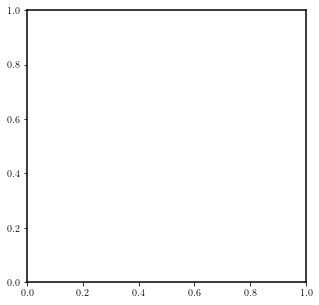

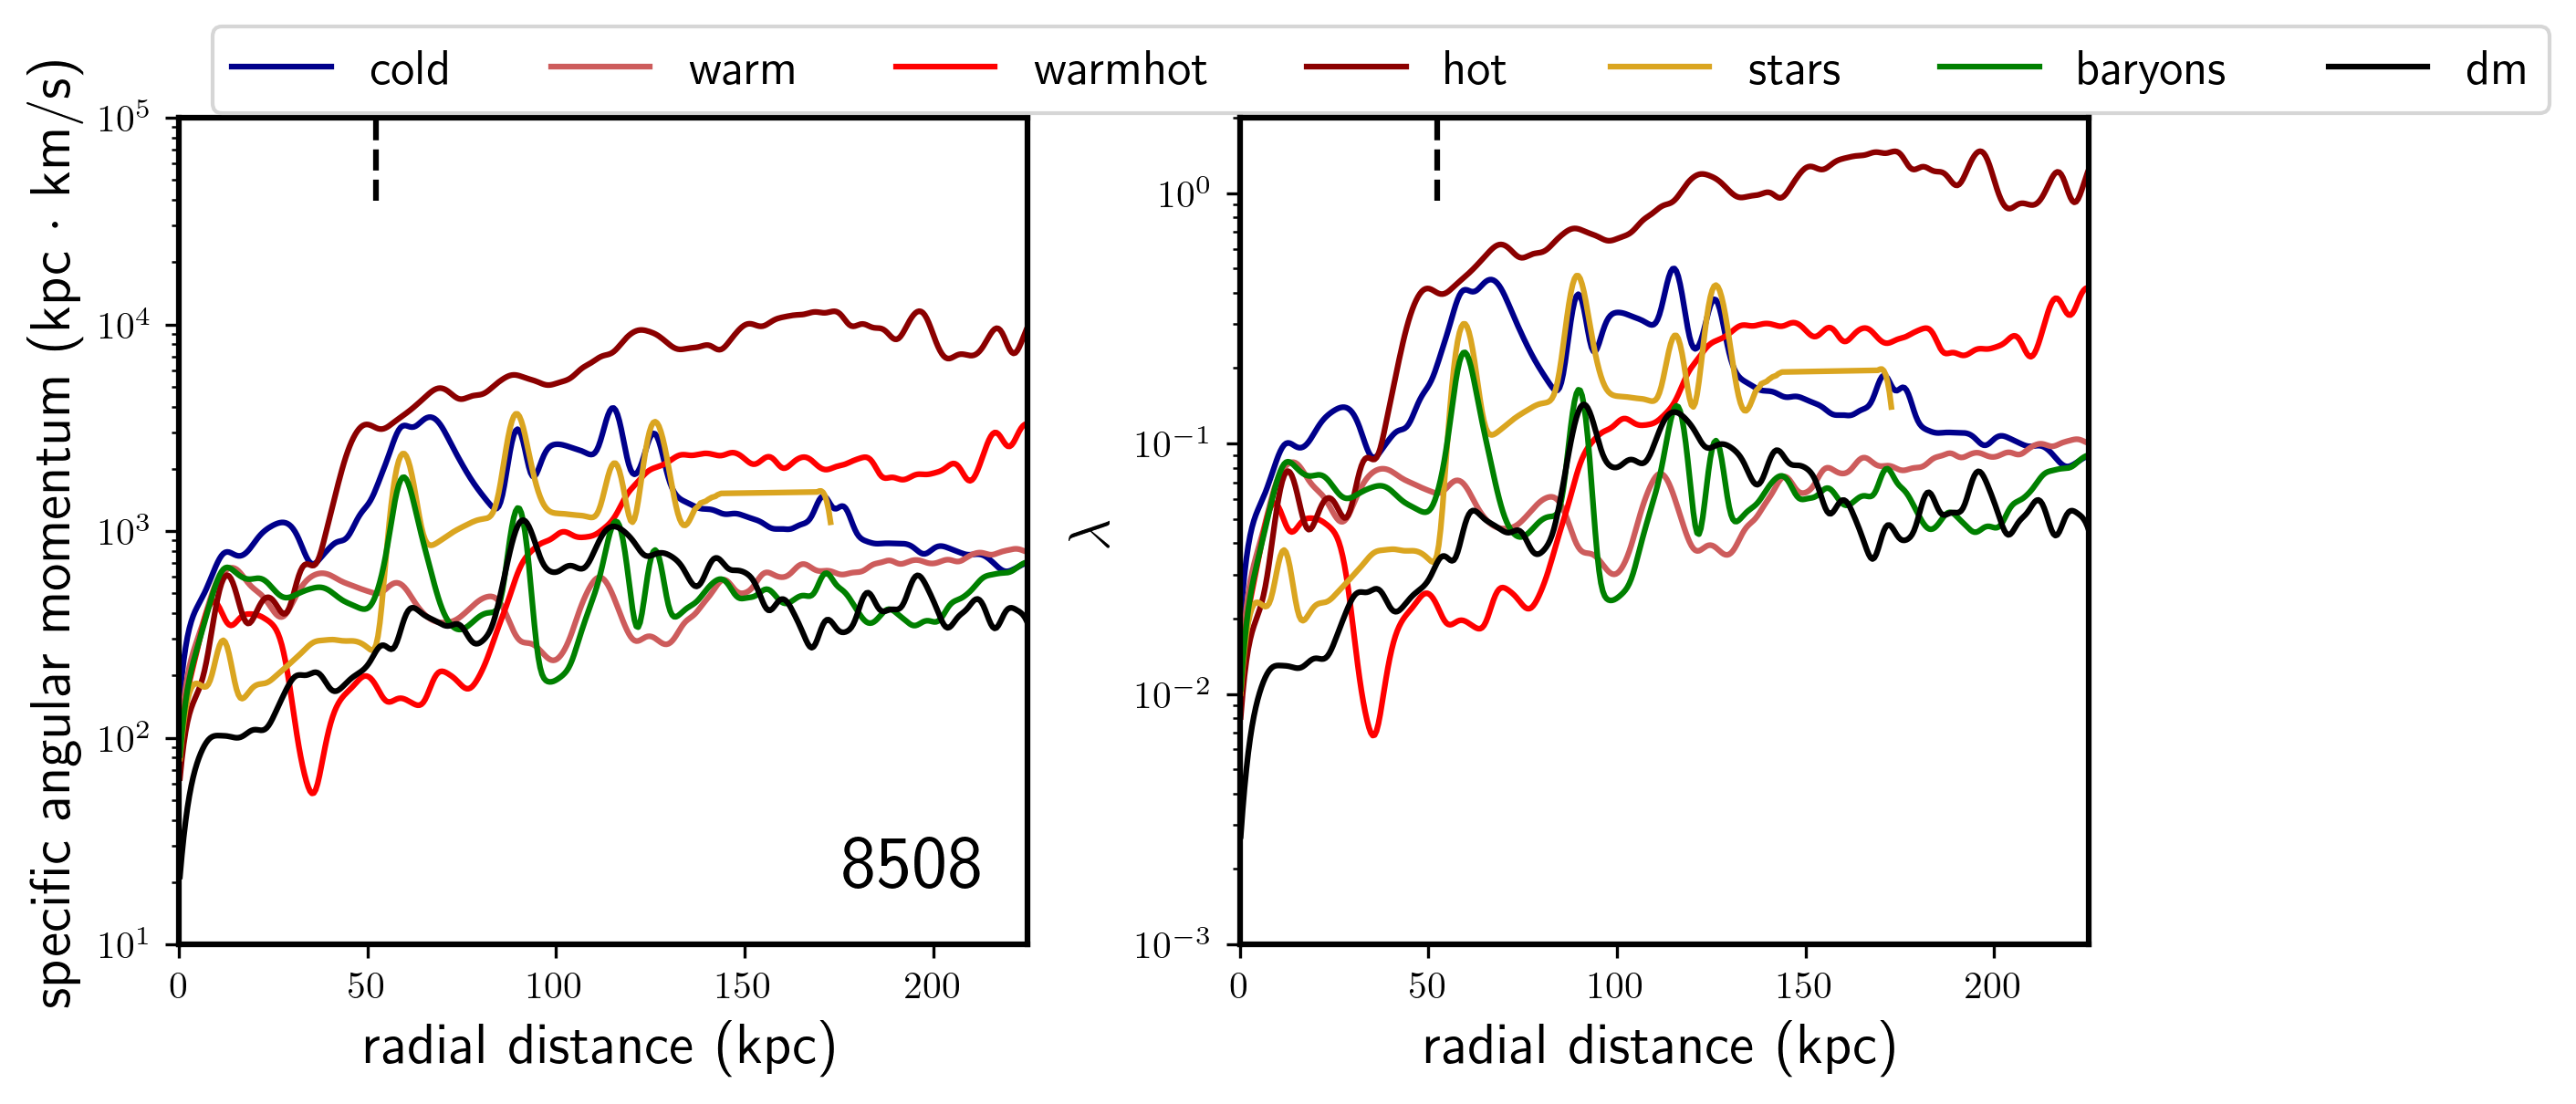

In [28]:
halos = ['8508',
         '5016',
         '5036',
         '4123',
         '2392',
         '2878']
         
clrs = {'cold': 'darkblue',
        'warm': 'indianred',
        'warmhot': 'red',
        'hot': 'darkred',
        'stars': 'goldenrod',
        'dm': 'black',
        'baryons': 'green'}
mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars', 'baryons', 'dm']

fig2, ax2 = plt.subplots(1,1, figsize = (5,5.), facecolor = 'white')
lam_all = {}
for mtype in mass_types:
    lam_all[mtype] = {}
    lam_all[mtype]['redshift'] = []
    lam_all[mtype]['lam'] = []
    

for halo in halos[:1]:
    DD_fls = sort(glob('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_DD????.npy'%(halo, halo)))
    rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/00%s/nref11c_nref9f/rvir_masses.hdf5'%halo)

    fig, axes = plt.subplots(1,2, figsize = (9,4.), facecolor = 'white')
    DD_track = []
    for di, DD_fl in enumerate([DD_fls[0], DD_fls[-1]]):
        DD = DD_fl.split('/')[-1][-10:-4]
        DD_track.append(DD)
        rvir      = yt.YTArray(rvir_masses['radius'][rvir_masses['snapshot'] == DD].data, 'kpc')
        mvir      = yt.YTArray(rvir_masses['total_mass'][rvir_masses['snapshot'] == DD].data, 'Msun')
        redshift  = rvir_masses['redshift'][rvir_masses['snapshot'] == DD].data
        Lprof = np.load('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_%s.npy'%(halo, halo, DD), allow_pickle = True)[()]
        r  = Lprof['cold']['rprof']['r']
        arg_rvir = int(floor(np.interp(rvir, r, np.arange(len(r)))))
        all_M  = np.zeros(len(r))
        print (halo, redshift)
        for mtype in mass_types:
            if mtype == 'baryons': continue
            all_M += Lprof[mtype]['rprof']['mass']

        for mtype in mass_types:
            #if (mtype != 'baryons') & (mtype != 'dm'): continue
            if mtype == 'baryons':
                r  = Lprof['cold']['rprof']['r']
                Lx = np.zeros(len(r))
                Ly = np.zeros(len(r))
                Lz = np.zeros(len(r))
                M  = np.zeros(len(r))
                for ms in mass_types[:-2]:
                    Lx += Lprof[ms]['rprof']['Lx']
                    Ly += Lprof[ms]['rprof']['Ly']
                    Lz += Lprof[ms]['rprof']['Lz']
                    M  += Lprof[ms]['rprof']['mass']
            else:
                r  = Lprof[mtype]['rprof']['r']
                Lx = Lprof[mtype]['rprof']['Lx']
                Ly = Lprof[mtype]['rprof']['Ly']
                Lz = Lprof[mtype]['rprof']['Lz']
                M  = Lprof[mtype]['rprof']['mass']

            L = np.sqrt(Lx**2. + Ly**2. + Lz**2.)
            j = (L/M).to('kpc * km/s')
            G     = yt.physical_constants.G
            Vvir = np.sqrt(G * mvir / rvir)
            lam = j/np.sqrt(2)/rvir/Vvir
            
            
            
            gd = (~np.isnan(lam)) & (~np.isnan(j))
            
            kern = Gaussian1DKernel(4)
            lam = convolve_fft(lam[gd], kern)
            j = convolve_fft(j[gd], kern)
            
            lam_all[mtype]['lam'].append(lam[arg_rvir])
            lam_all[mtype]['redshift'].append(redshift)

            #lam = lam[gd]
            #j = j[gd]
            r = r[gd]
            alp_low = 1.0
            if redshift > 1: 
                alp = alp_low
                ls = '-'
            else: 
                alp = 1
                ls = '-'
            if di == 0: lbl = mtype
            else: lbl = None
            axes[0].plot(r, j, label = lbl, color = clrs[mtype],  linestyle = ls, alpha = alp)
            axes[1].plot(r, lam, label = lbl, color = clrs[mtype],linestyle = ls,  alpha = alp)
            

        if di == 0: axes[0].legend(loc = 2, ncol = 7, bbox_to_anchor=(0.01, 1.14), fontsize = 13)
        axes[0].set_ylabel('specific angular momentum (kpc $\cdot$ km/s)')
        axes[0].set_ylim(10, 1.e5)
        
        if False: #di == 1:
            lamp = np.arange(1.e-3, 1, 1.e-3)
            lam0p, sig = 0.035, 0.5
            bdist = 1./(lamp*np.sqrt(2*np.pi*sig)) * np.exp(-np.log(lamp/lam0p)**2./(2*sig**2))
            axes[2].plot(50.*bdist/np.max(bdist),lamp, 'k-', markersize = 20)
            axes[2].axis('off')
        for ax in axes[1:]: 
            ax.set_ylim(1.e-3, 2.)


        for ax in axes:
            ax.set_yscale('log')
        axes[1].set_ylabel('$\lambda$')
        for ax in axes[:2]: 
            ax.set_xlabel('radial distance (kpc)')
            ax.axvline(x = rvir, color = 'black', ymin = 0.9, ymax = 1.0, linestyle = '--')
            #ax.axvline(x = 100/(1+redshift)/0.7, ymin = 0.9, ymax = 1.0,color = 'grey', linestyle = '--')
            ax.set_xlim(0, 225)
        axes[0].annotate(halo, (0.95, 0.05),
                         va = 'bottom', ha = 'right', xycoords = 'axes fraction', 
                         fontsize = 20, fontweight = 'bold')        
        fig.set_dpi(300)
        fig.subplots_adjust(wspace = 0.25)
        fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/%s_%s.png'%(halo, DD))

    fig.set_dpi(300)
    fig.subplots_adjust(wspace = 0.25)
    fig.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/%s_%s-%s.png'%(halo, DD_track[0], DD_track[1]))

    
    
    lamp = np.arange(1.e-3, 1, 1.e-3)
    lam0p, sig = 0.035, 0.5
    bdist = 1./(lamp*np.sqrt(2*np.pi*sig)) * np.exp(-np.log(lamp/lam0p)**2./(2*sig**2))
    ax2.plot(lamp, 50.*bdist/np.max(bdist), 'k-', markersize = 20)
    
    fig2.set_dpi(300)
    fig2.subplots_adjust(wspace = 0.25)
    fig2.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/%s_spin_distribution.png'%(halo))

    
'''
if mass == 'baryons':
    r  = profile['cold']['rprof']['r']
    Lx = np.zeros(len(r))
    Ly = np.zeros(len(r))
    Lz = np.zeros(len(r))
    M  = np.zeros(len(r))
    for ms in mass_types[:-2]:
        Lx += profile[ms]['rprof']['Lx']
        Ly += profile[ms]['rprof']['Ly']
        Lz += profile[ms]['rprof']['Lz']
        M  += profile[ms]['rprof']['mass']
else:
'''

    

In [26]:
arg_rvir

array([104.13611189])

In [356]:
halos = ['8508',
         '5016',
         '5036',
         '4123',
         '2392',
         '2878']
         
clrs = {'cold': 'darkblue',
        'warm': 'indianred',
        'warmhot': 'red',
        'hot': 'darkred',
        'stars': 'goldenrod',
        'dm': 'black',
        'baryons': 'green'}
mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars', 'baryons', 'dm']#[:1]

lam_all = {}
for mtype in mass_types:
    lam_all[mtype] = {}
    lam_all[mtype]['redshift'] = []
    lam_all[mtype]['lam'] = []
    

for halo in halos:#[:1]:
    DD_fls = sort(glob('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_DD????.npy'%(halo, halo)))
    rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/00%s/nref11c_nref9f/rvir_masses.hdf5'%halo)
    for di, DD_fl in enumerate(DD_fls):
        DD = DD_fl.split('/')[-1][-10:-4]
        DD_track.append(DD)
        rvir      = yt.YTArray(rvir_masses['radius'][rvir_masses['snapshot'] == DD].data, 'kpc')
        if len(rvir) > 0:
            pass
        else:
            continue

        mvir      = yt.YTArray(rvir_masses['total_mass'][rvir_masses['snapshot'] == DD].data, 'Msun')
        redshift  = rvir_masses['redshift'][rvir_masses['snapshot'] == DD].data
        Lprof = np.load('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_%s.npy'%(halo, halo, DD), allow_pickle = True)[()]
        r  = Lprof['cold']['rprof']['r']
        arg_rvir = int(floor(np.interp(rvir, r, np.arange(len(r)))))
        all_M  = np.zeros(len(r))
        print (halo, redshift)
        for mtype in mass_types:
            if mtype == 'baryons': continue
            all_M += Lprof[mtype]['rprof']['mass']

        for mtype in mass_types:
            #if (mtype != 'baryons') & (mtype != 'dm'): continue
            if mtype == 'baryons':
                r  = Lprof['cold']['rprof']['r']
                Lx = np.zeros(len(r))
                Ly = np.zeros(len(r))
                Lz = np.zeros(len(r))
                M  = np.zeros(len(r))
                for ms in mass_types[:-2]:
                    Lx += np.cumsum(Lprof[ms]['rprof']['Lx'])
                    Ly += np.cumsum(Lprof[ms]['rprof']['Ly'])
                    Lz += np.cumsum(Lprof[ms]['rprof']['Lz'])
                    M  += np.cumsum(Lprof[ms]['rprof']['mass'])
            else:
                r  = np.cumsum(Lprof[mtype]['rprof']['r'])
                r = np.mean((r[:-1], r[1:]), axis = 0)
                Lx = np.cumsum(Lprof[mtype]['rprof']['Lx'])
                Ly = np.cumsum(Lprof[mtype]['rprof']['Ly'])
                Lz = np.cumsum(Lprof[mtype]['rprof']['Lz'])
                M  = np.cumsum(Lprof[mtype]['rprof']['mass'])

            L = np.sqrt(Lx**2. + Ly**2. + Lz**2.)
            j = (L/M).to('kpc * km/s')
            G     = yt.physical_constants.G
            Vvir = np.sqrt(G * mvir / rvir)
            lam = j/np.sqrt(2)/rvir/Vvir
            
            
            
            gd = (~np.isnan(lam)) & (~np.isnan(j))
            
            kern = Gaussian1DKernel(4)
            lam = convolve_fft(lam[gd], kern)
            j = convolve_fft(j[gd], kern)
            
            lam_all[mtype]['lam'].append(float(lam[arg_rvir]))
            lam_all[mtype]['redshift'].append(float(redshift[0]))


8508 [1.99979384]
8508 [1.70546154]
8508 [1.47070607]
8508 [1.2778594]
8508 [1.11573437]
8508 [0.97816794]
8508 [0.85724242]
8508 [0.75073114]
8508 [0.65589053]
8508 [0.57065123]
8508 [0.49342125]
8508 [0.42294018]
8508 [0.35825474]
8508 [0.29854043]
8508 [0.24314759]
8508 [0.19155364]
8508 [0.14331287]
8508 [0.09805377]
8508 [0.05546401]
8508 [0.01526794]
8508 [0.]
5016 [1.99978791]
5016 [1.70546064]
5016 [1.47069813]
5016 [1.27785012]
5016 [1.11572811]
5016 [0.97686717]
5016 [0.85610159]
5016 [0.74971635]
5016 [0.65498062]
5016 [0.56982848]
5016 [0.49268304]
5016 [0.42226619]
5016 [0.35763559]
5016 [0.29796468]
5016 [0.24261286]
5016 [0.19105474]
5016 [0.14284548]
5016 [0.09761425]
5016 [0.05504929]
5016 [0.01487862]
5016 [0.]
5036 [1.99978791]
5036 [1.70546064]
5036 [1.47069813]
5036 [1.27785012]
5036 [1.11572811]
5036 [0.97686717]
5036 [0.85610159]
5036 [0.74971635]
5036 [0.65498062]
5036 [0.56982848]
5036 [0.49268304]
5036 [0.42226619]
5036 [0.35763559]
5036 [0.29796468]
5036 [0.2

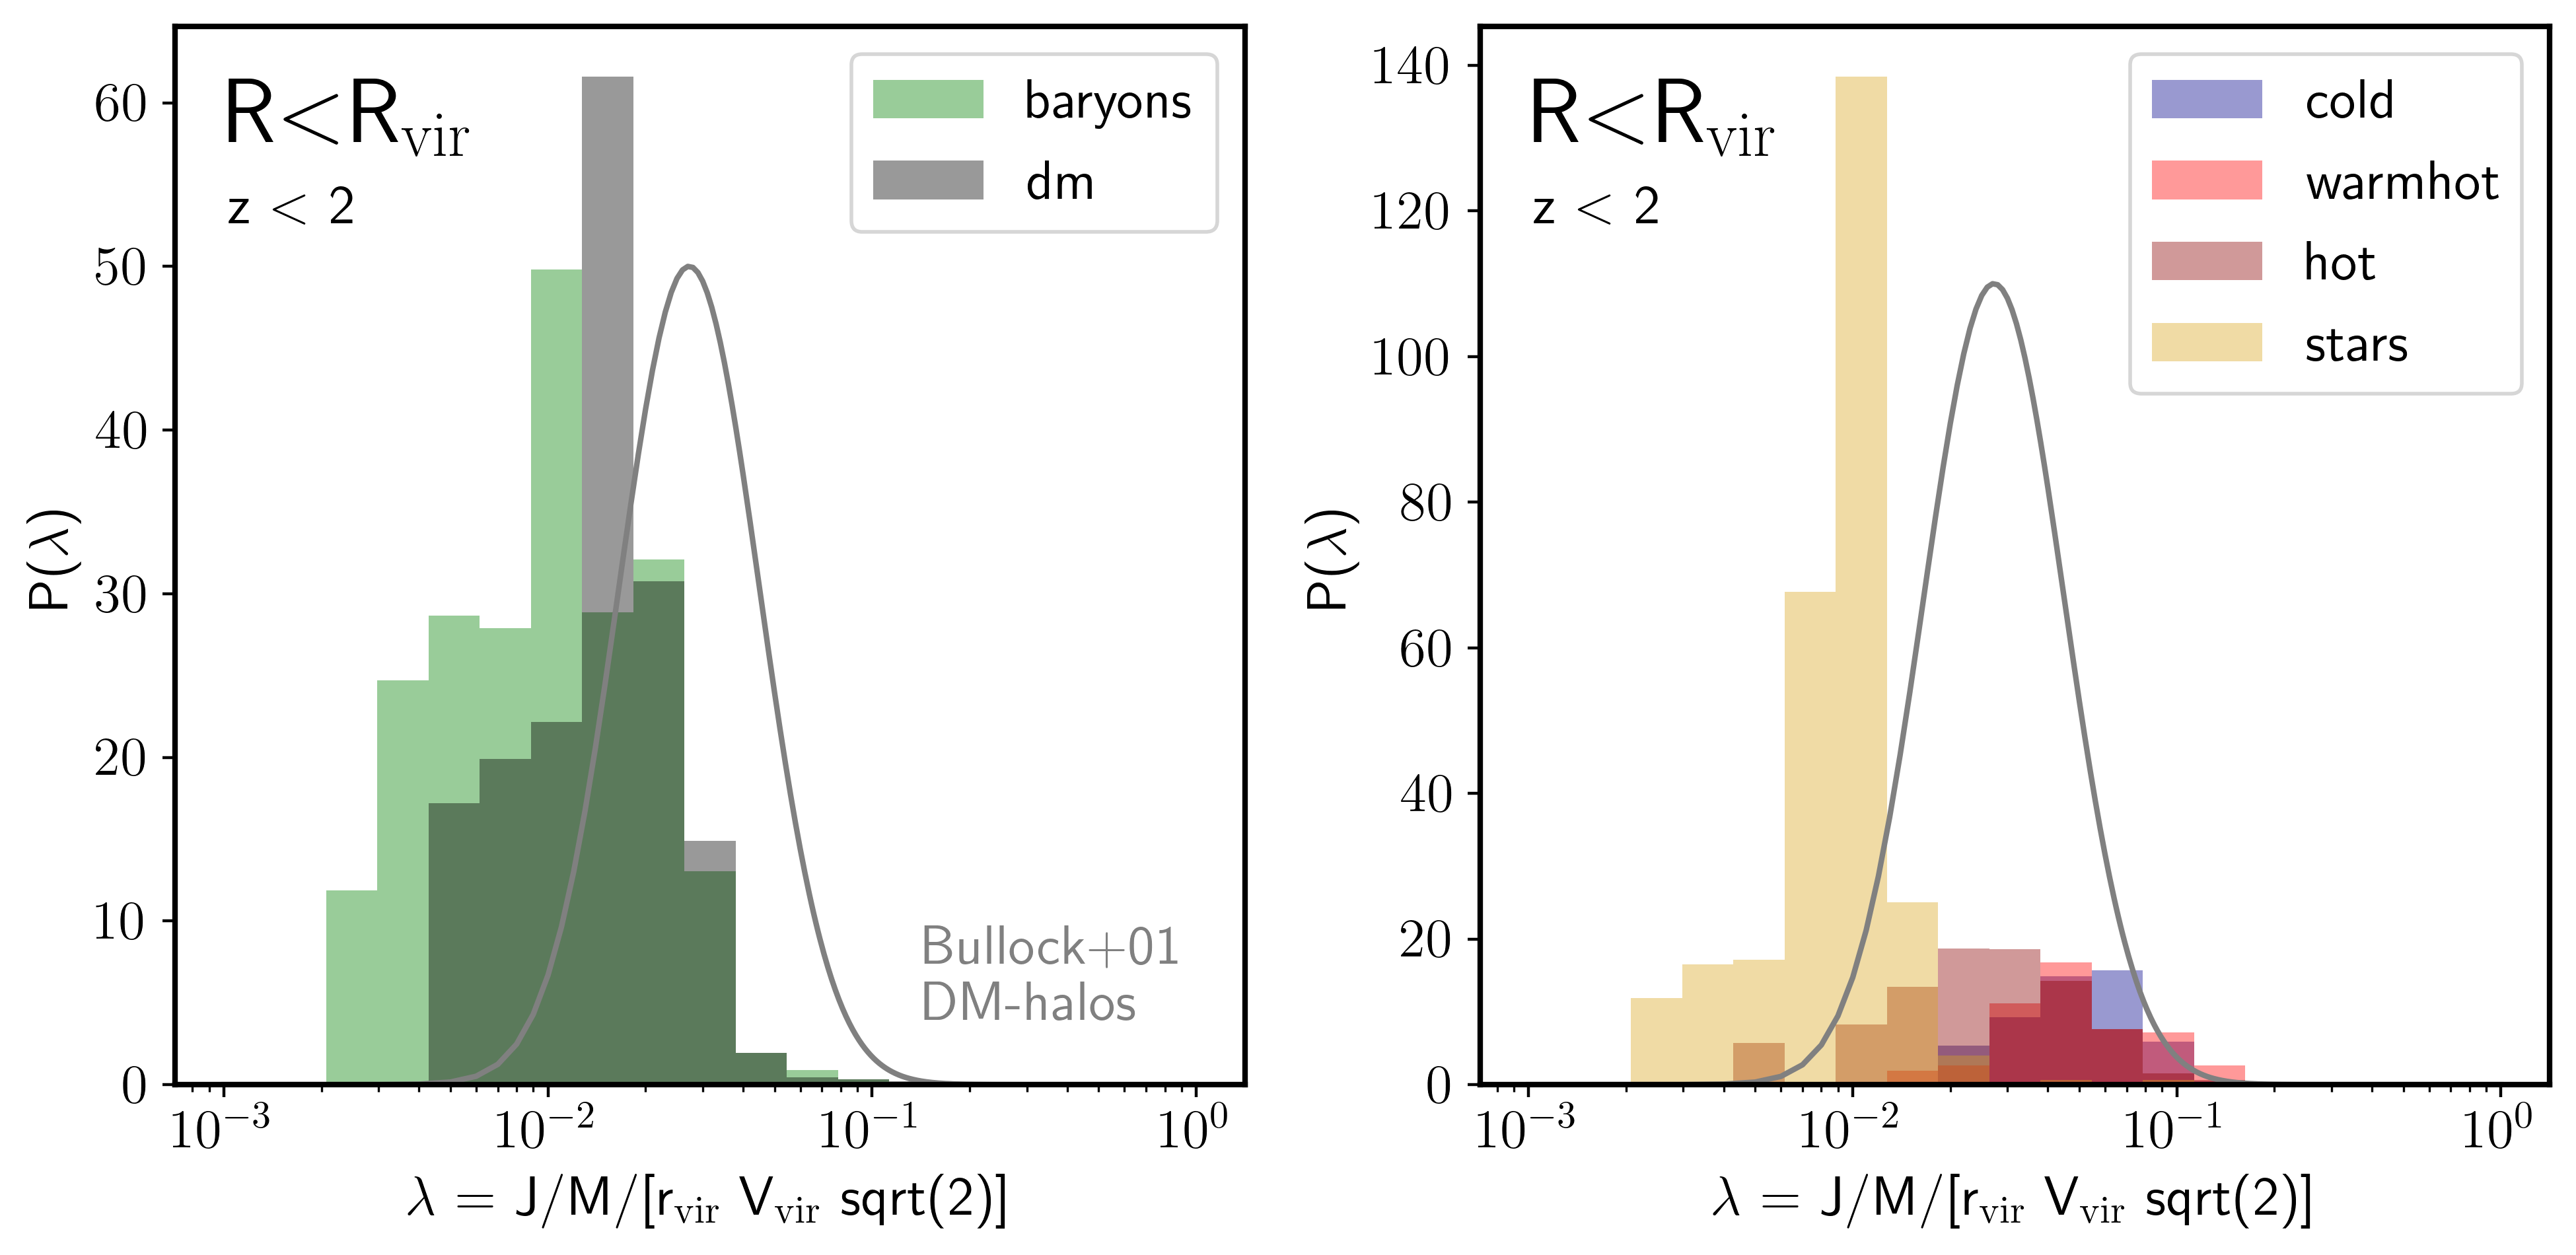

In [415]:
fig2, axes = plt.subplots(1,2, figsize = (10,5.), facecolor = 'white')

lamp = np.arange(1.e-3, 1, 1.e-3)
lam0p, sig = 0.035, 0.5
bdist = 1./(lamp*np.sqrt(2*np.pi*sig)) * np.exp(-np.log(lamp/lam0p)**2./(2*sig**2))
bins = np.logspace(np.log10(1e-3),np.log10(1.0), 20)
for mtype in mass_types:
    if (mtype != 'baryons') & (mtype != 'dm'): continue
    gd = np.array(lam_all[mtype]['redshift']) < 2.
    axes[0].hist(np.array(lam_all[mtype]['lam'])[gd], color = clrs[mtype], alpha = 0.4, bins = bins, density = True, stacked = True, label = mtype)

for mtype in mass_types:
    if (mtype != 'stars') & (mtype != 'cold') & (mtype != 'warmhot')& (mtype != 'hot'): continue
    gd = np.array(lam_all[mtype]['redshift']) < 2.
    axes[1].hist(np.array(lam_all[mtype]['lam'])[gd], color = clrs[mtype], alpha = 0.4, bins = bins, density = True, stacked = True, label = mtype)
    
axes[0].plot(lamp, 50.*bdist/np.max(bdist), '-', color = 'grey')
axes[1].plot(lamp, 110.*bdist/np.max(bdist), '-', color = 'grey')
for ax in axes:

    ax.legend(loc = 1)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\lambda$ = J/M/[r$_{\mathrm{vir}}$ V$_{\mathrm{vir}}$ sqrt(2)]')
    ax.set_ylabel(r'P($\lambda$)')
    ax.annotate('R$<$R$_{\mathrm{vir}}$', (0.05, 0.95), ha = 'left', va = 'top', 
                 fontsize = 25, xycoords = 'axes fraction', color = 'black')
    ax.annotate('z $<$ 2', (0.05, 0.85), ha = 'left', va = 'top', 
                 fontsize = 15, xycoords = 'axes fraction', color = 'black')
axes[0].annotate('Bullock+01\nDM-halos', (0.70, 0.15), ha = 'left', va = 'top', 
             fontsize = 15, xycoords = 'axes fraction', color = 'grey')
fig2.set_dpi(400)
fig2.tight_layout()
fig2.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/lambda_distribution.png')

In [375]:
gd

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False])

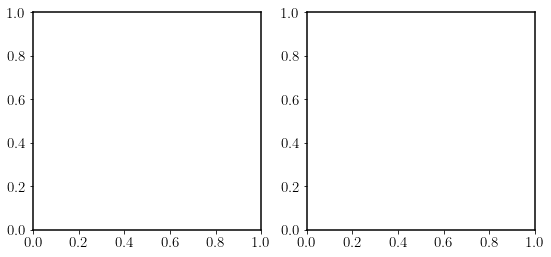

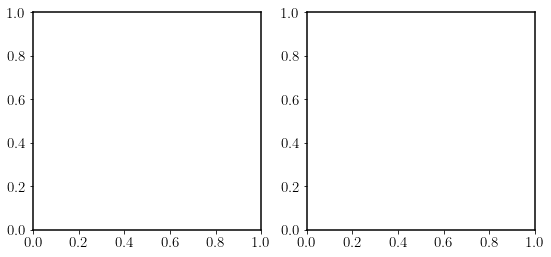

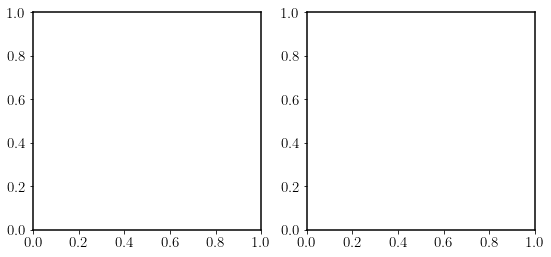

In [239]:
halos = ['8508',
         '5016',
         '5036',
         '4123',
         '2392',
         '2878']
         
clrs = {'cold': 'darkblue',
        'warm': 'indianred',
        'warmhot': 'red',
        'hot': 'darkred',
        'stars': 'goldenrod',
        'dm': 'black',
        'baryons': 'green'}
mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars', 'baryons', 'dm']
for halo in halos[:3]:
    DD_fls = sort(glob('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/%s/Lprof_%s_DD????.npy'%(halo, halo)))
    rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/00%s/nref11c_nref9f/rvir_masses.hdf5'%halo)

    fig, axes = plt.subplots(1,2, figsize = (9,4.), facecolor = 'white')
    DD_track = []

# End-over-end

saved
saved
saved
saved
saved
saved


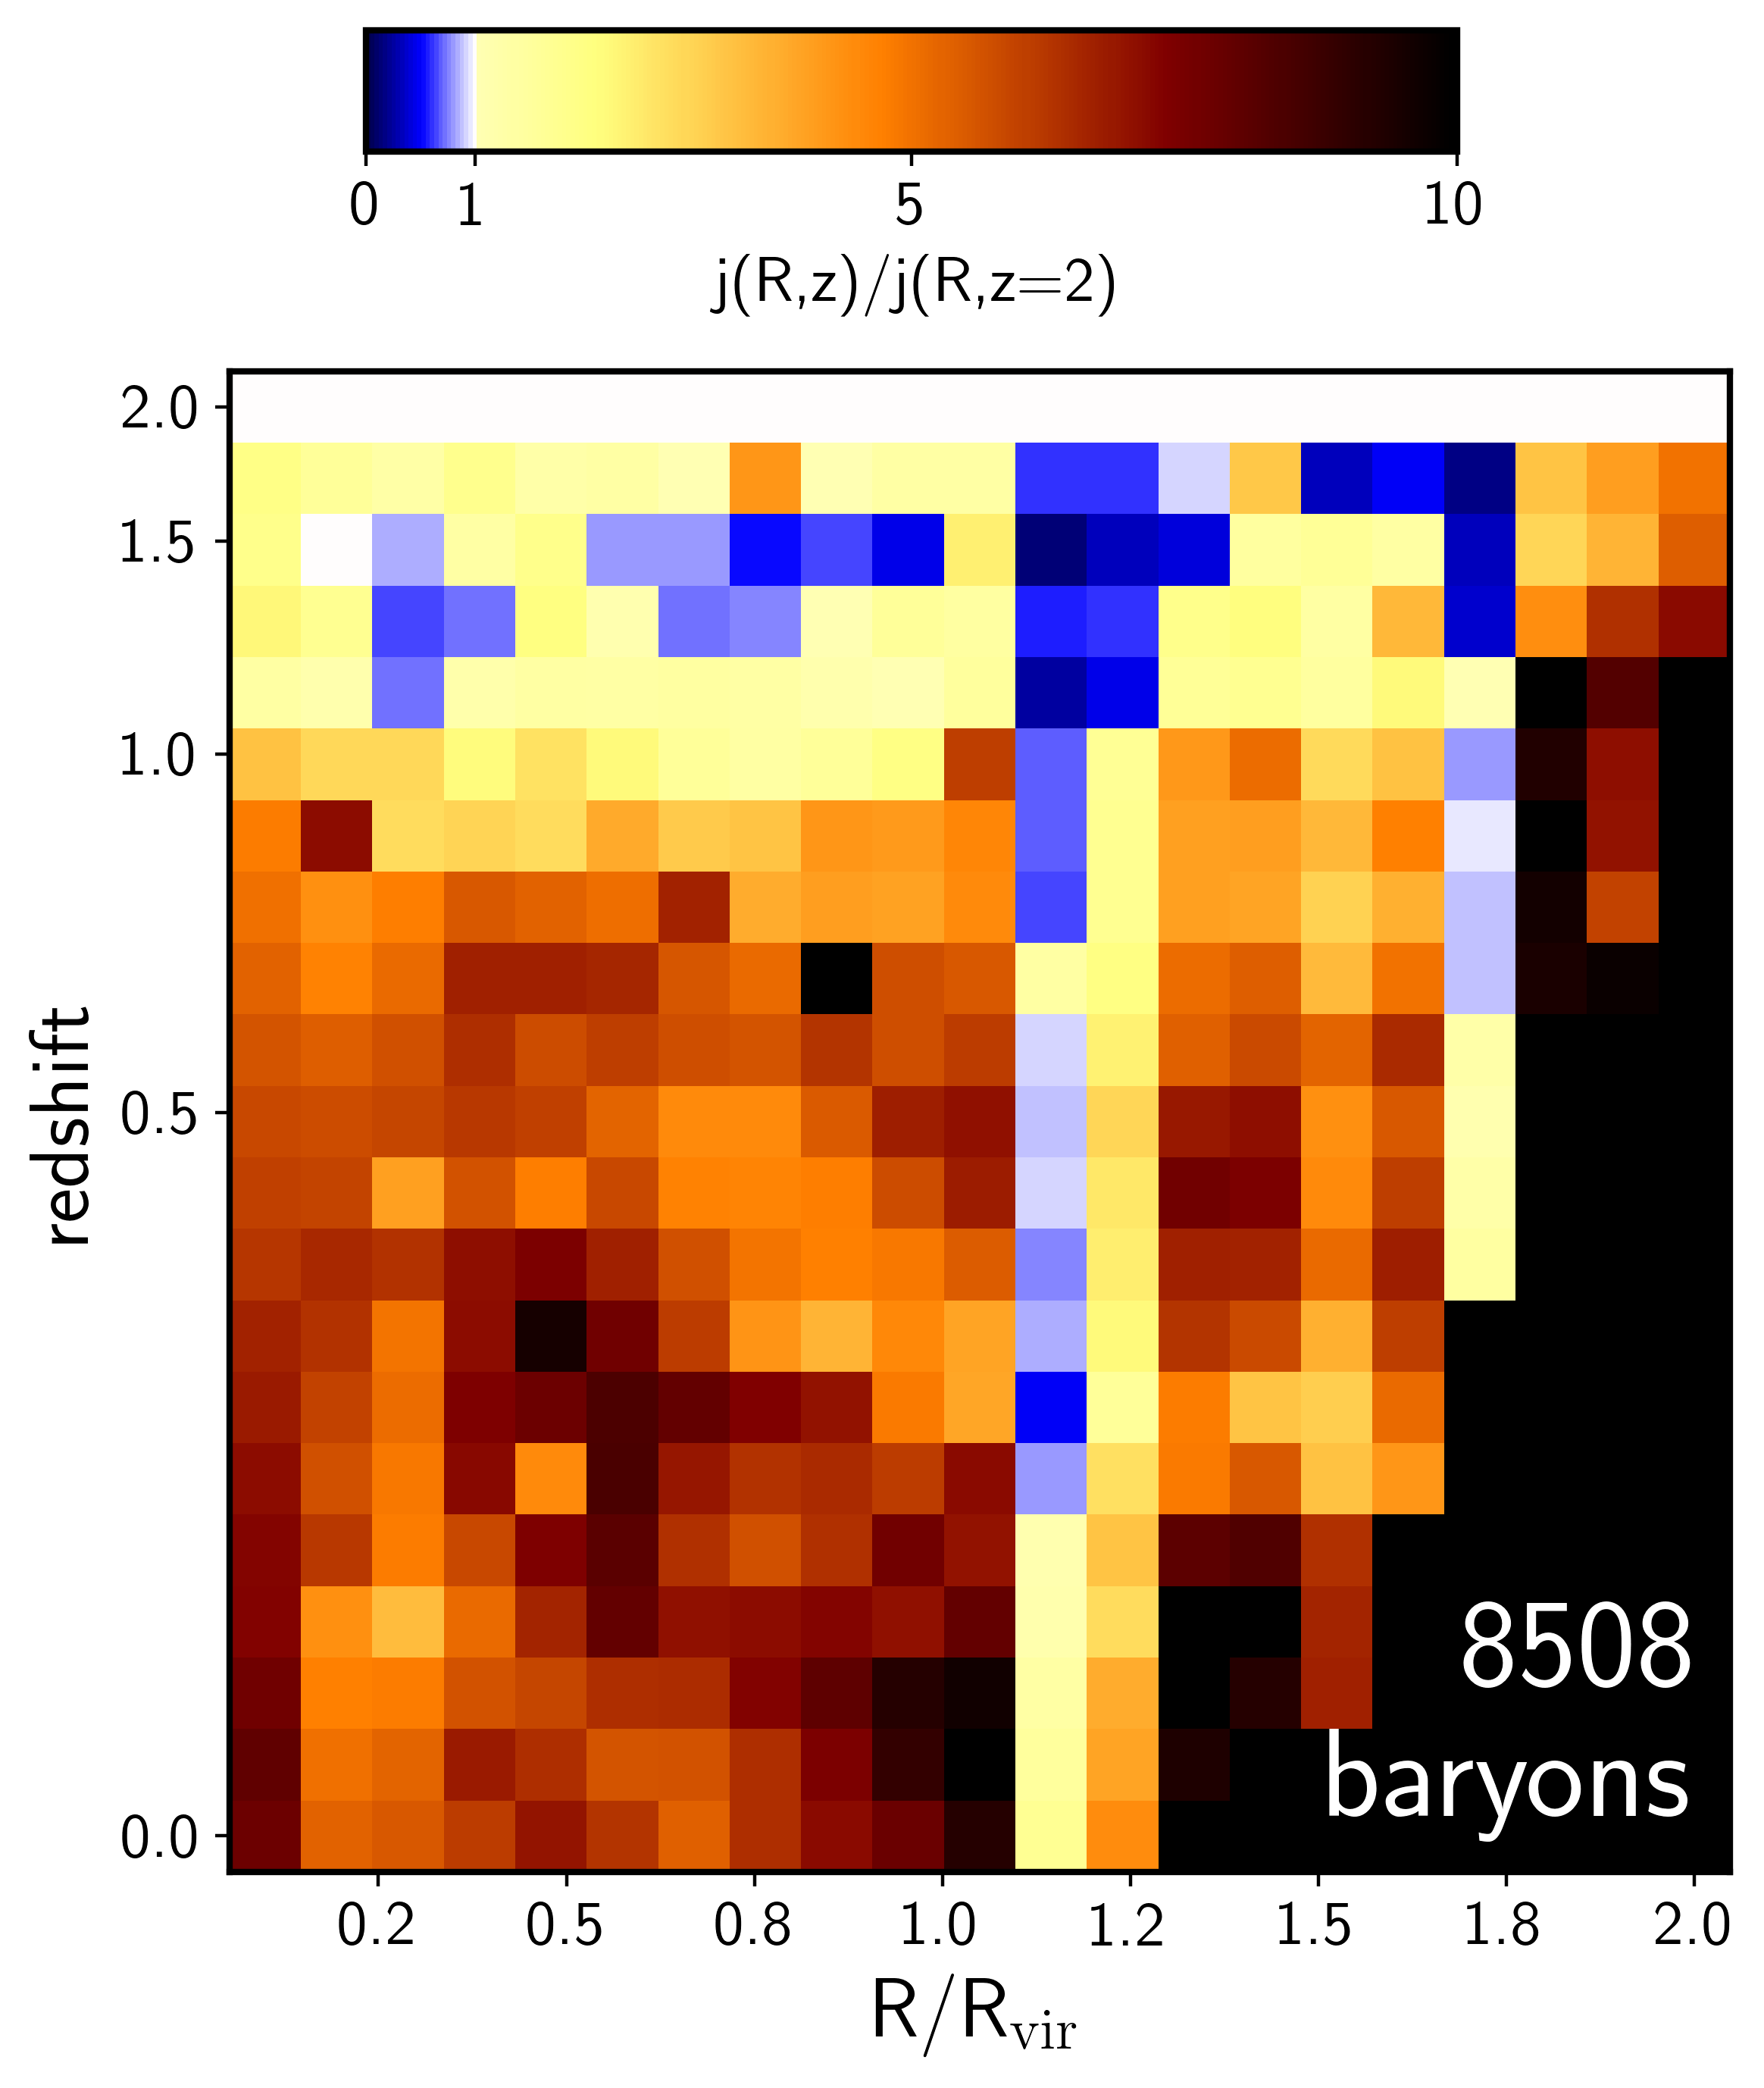

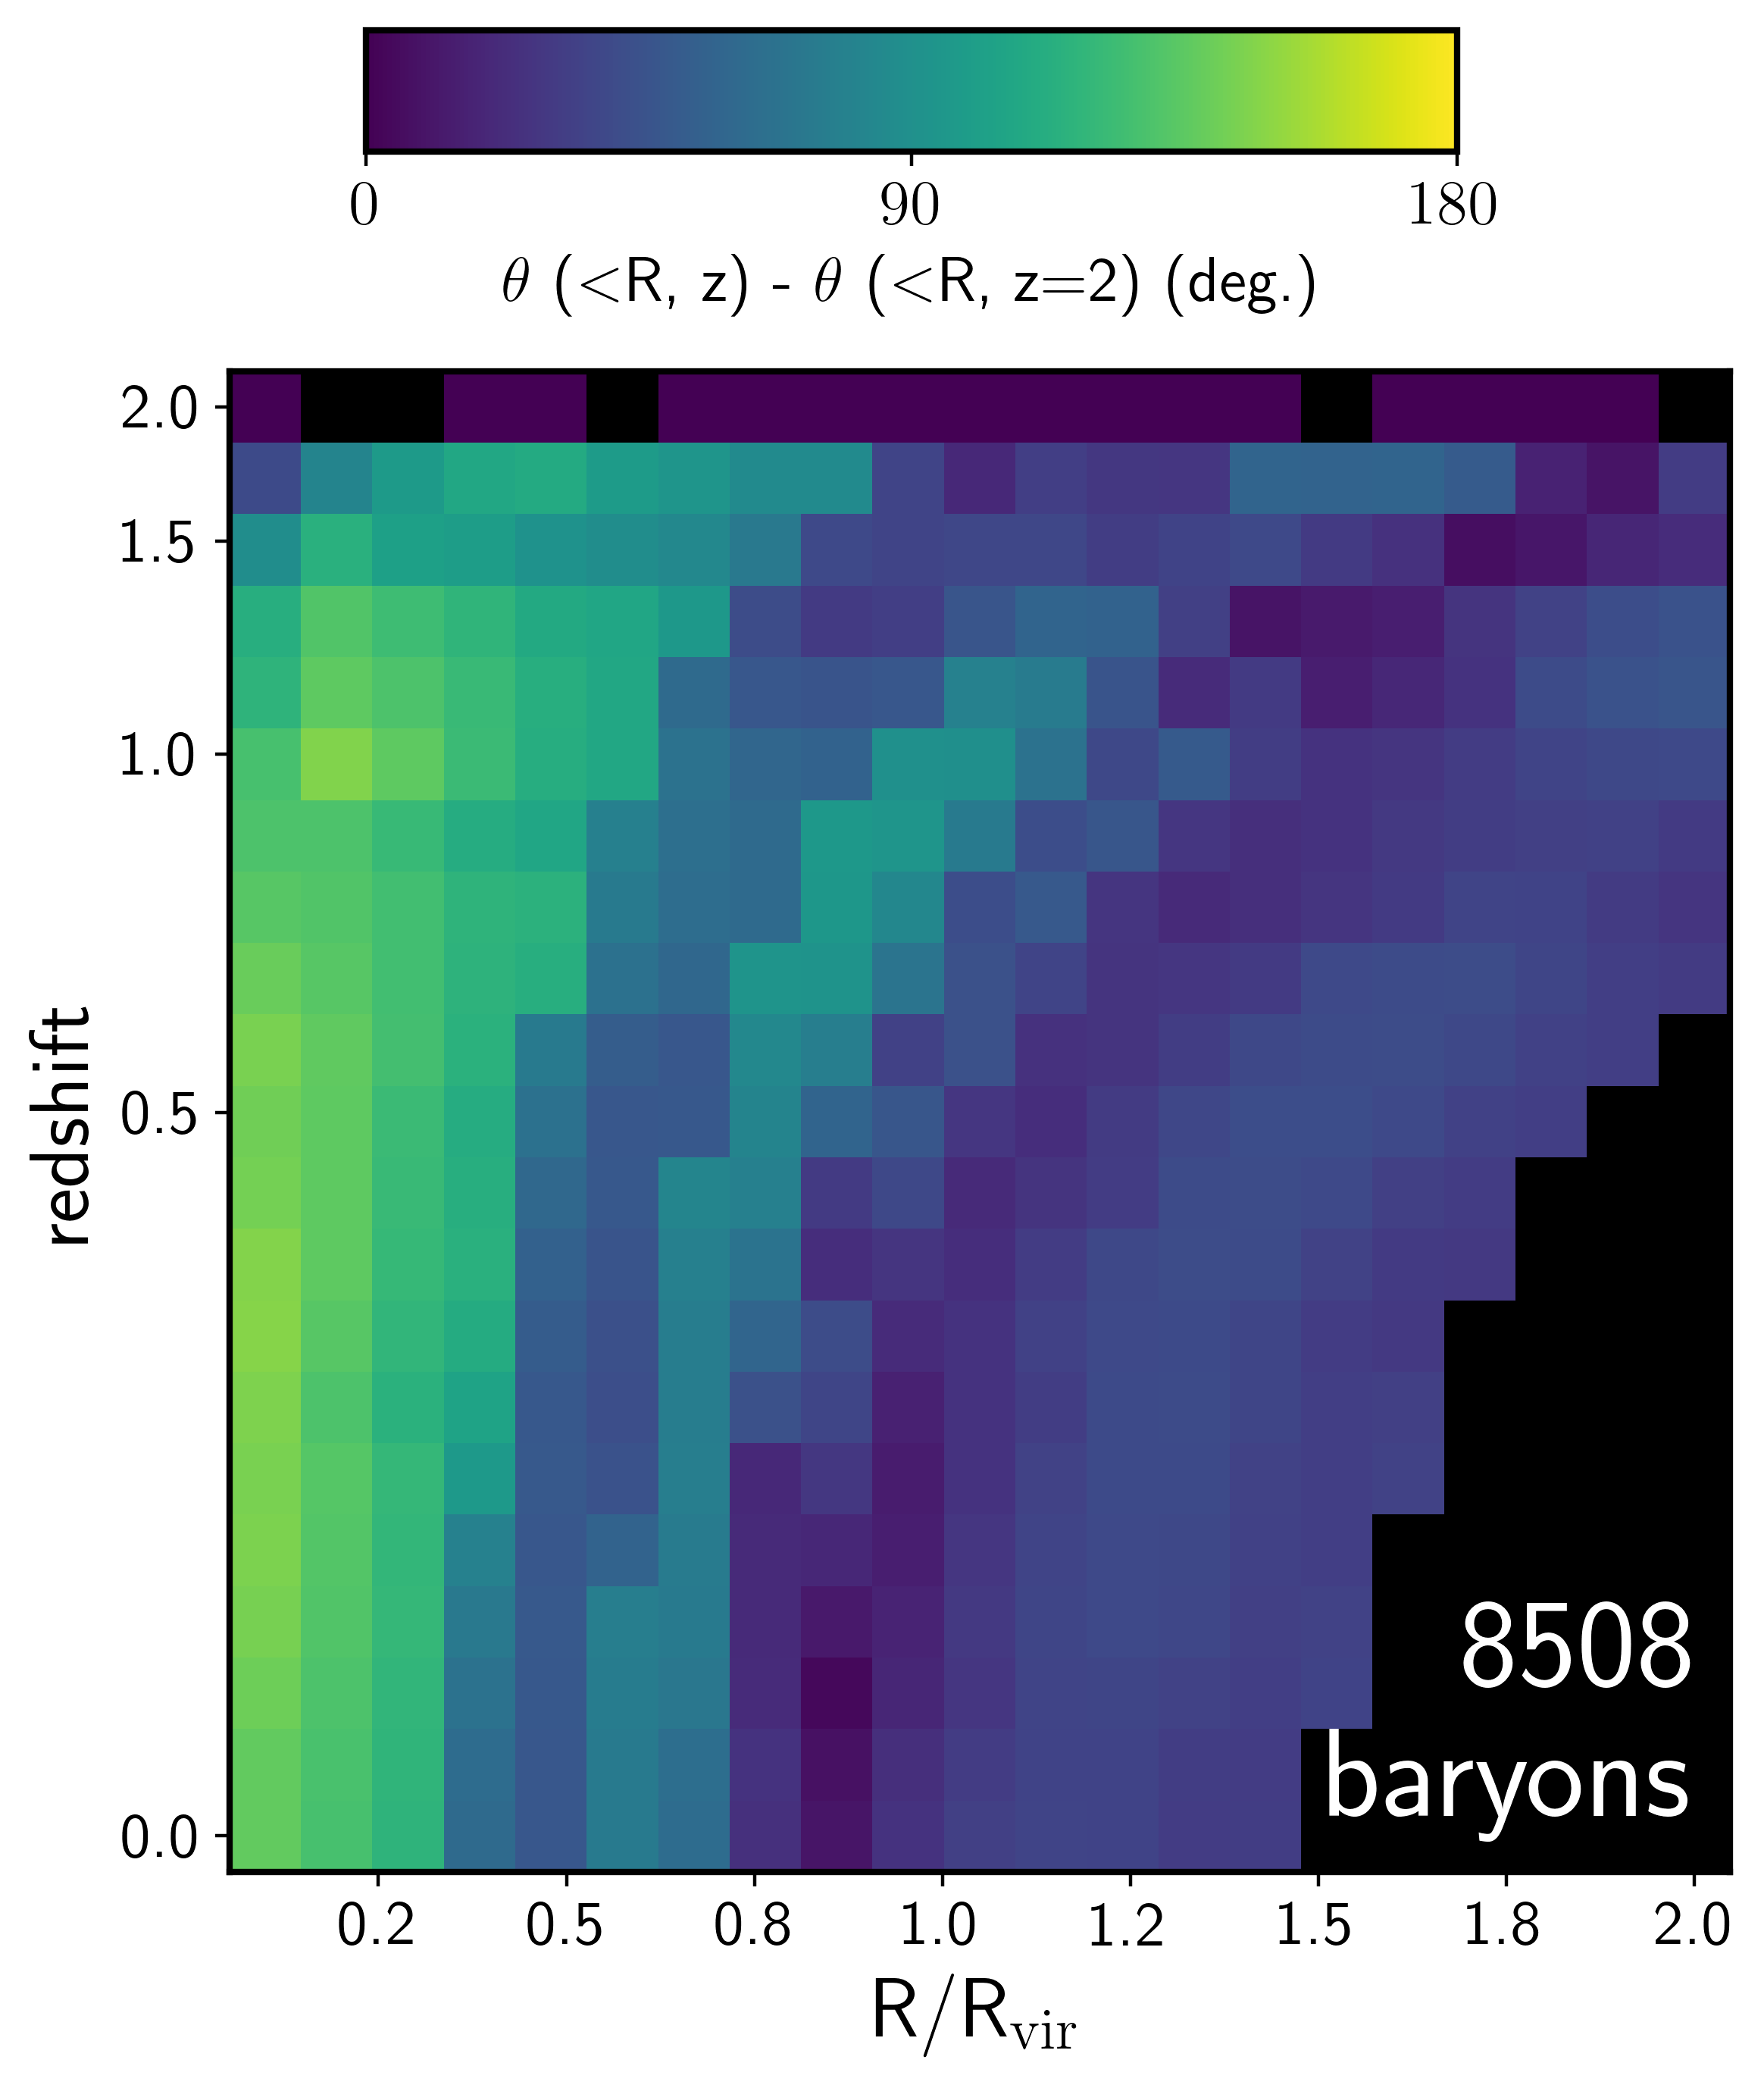

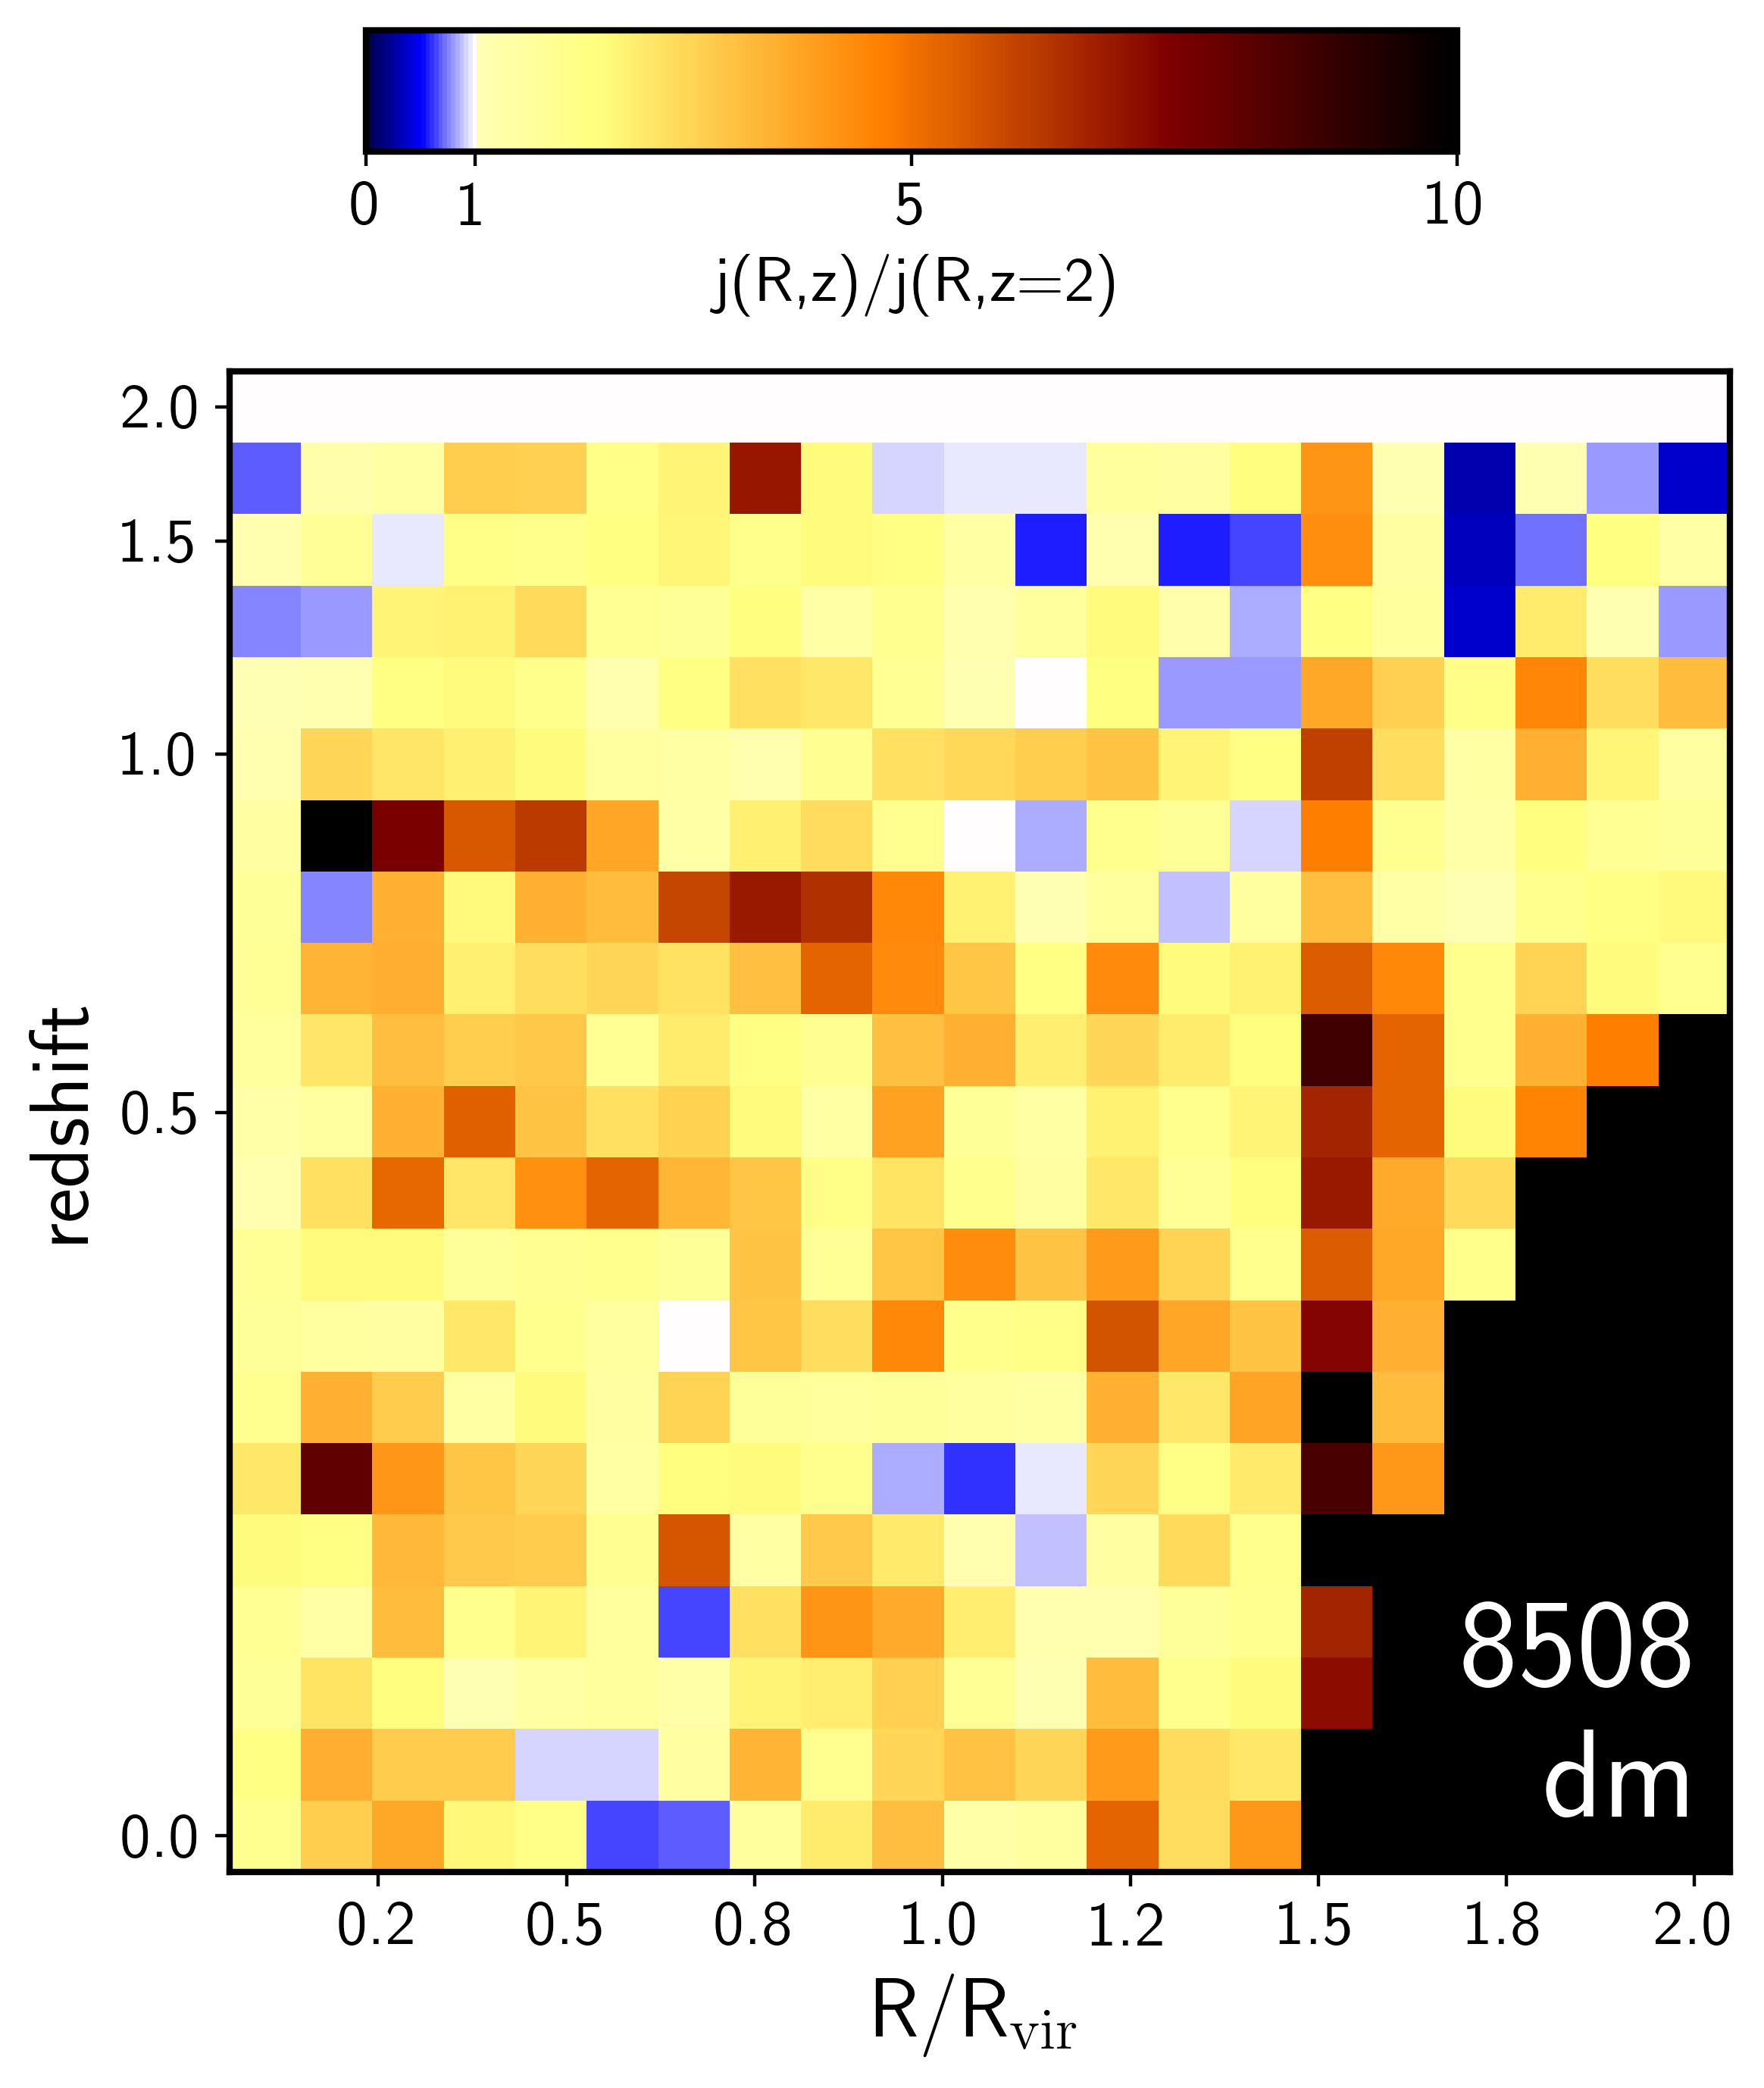

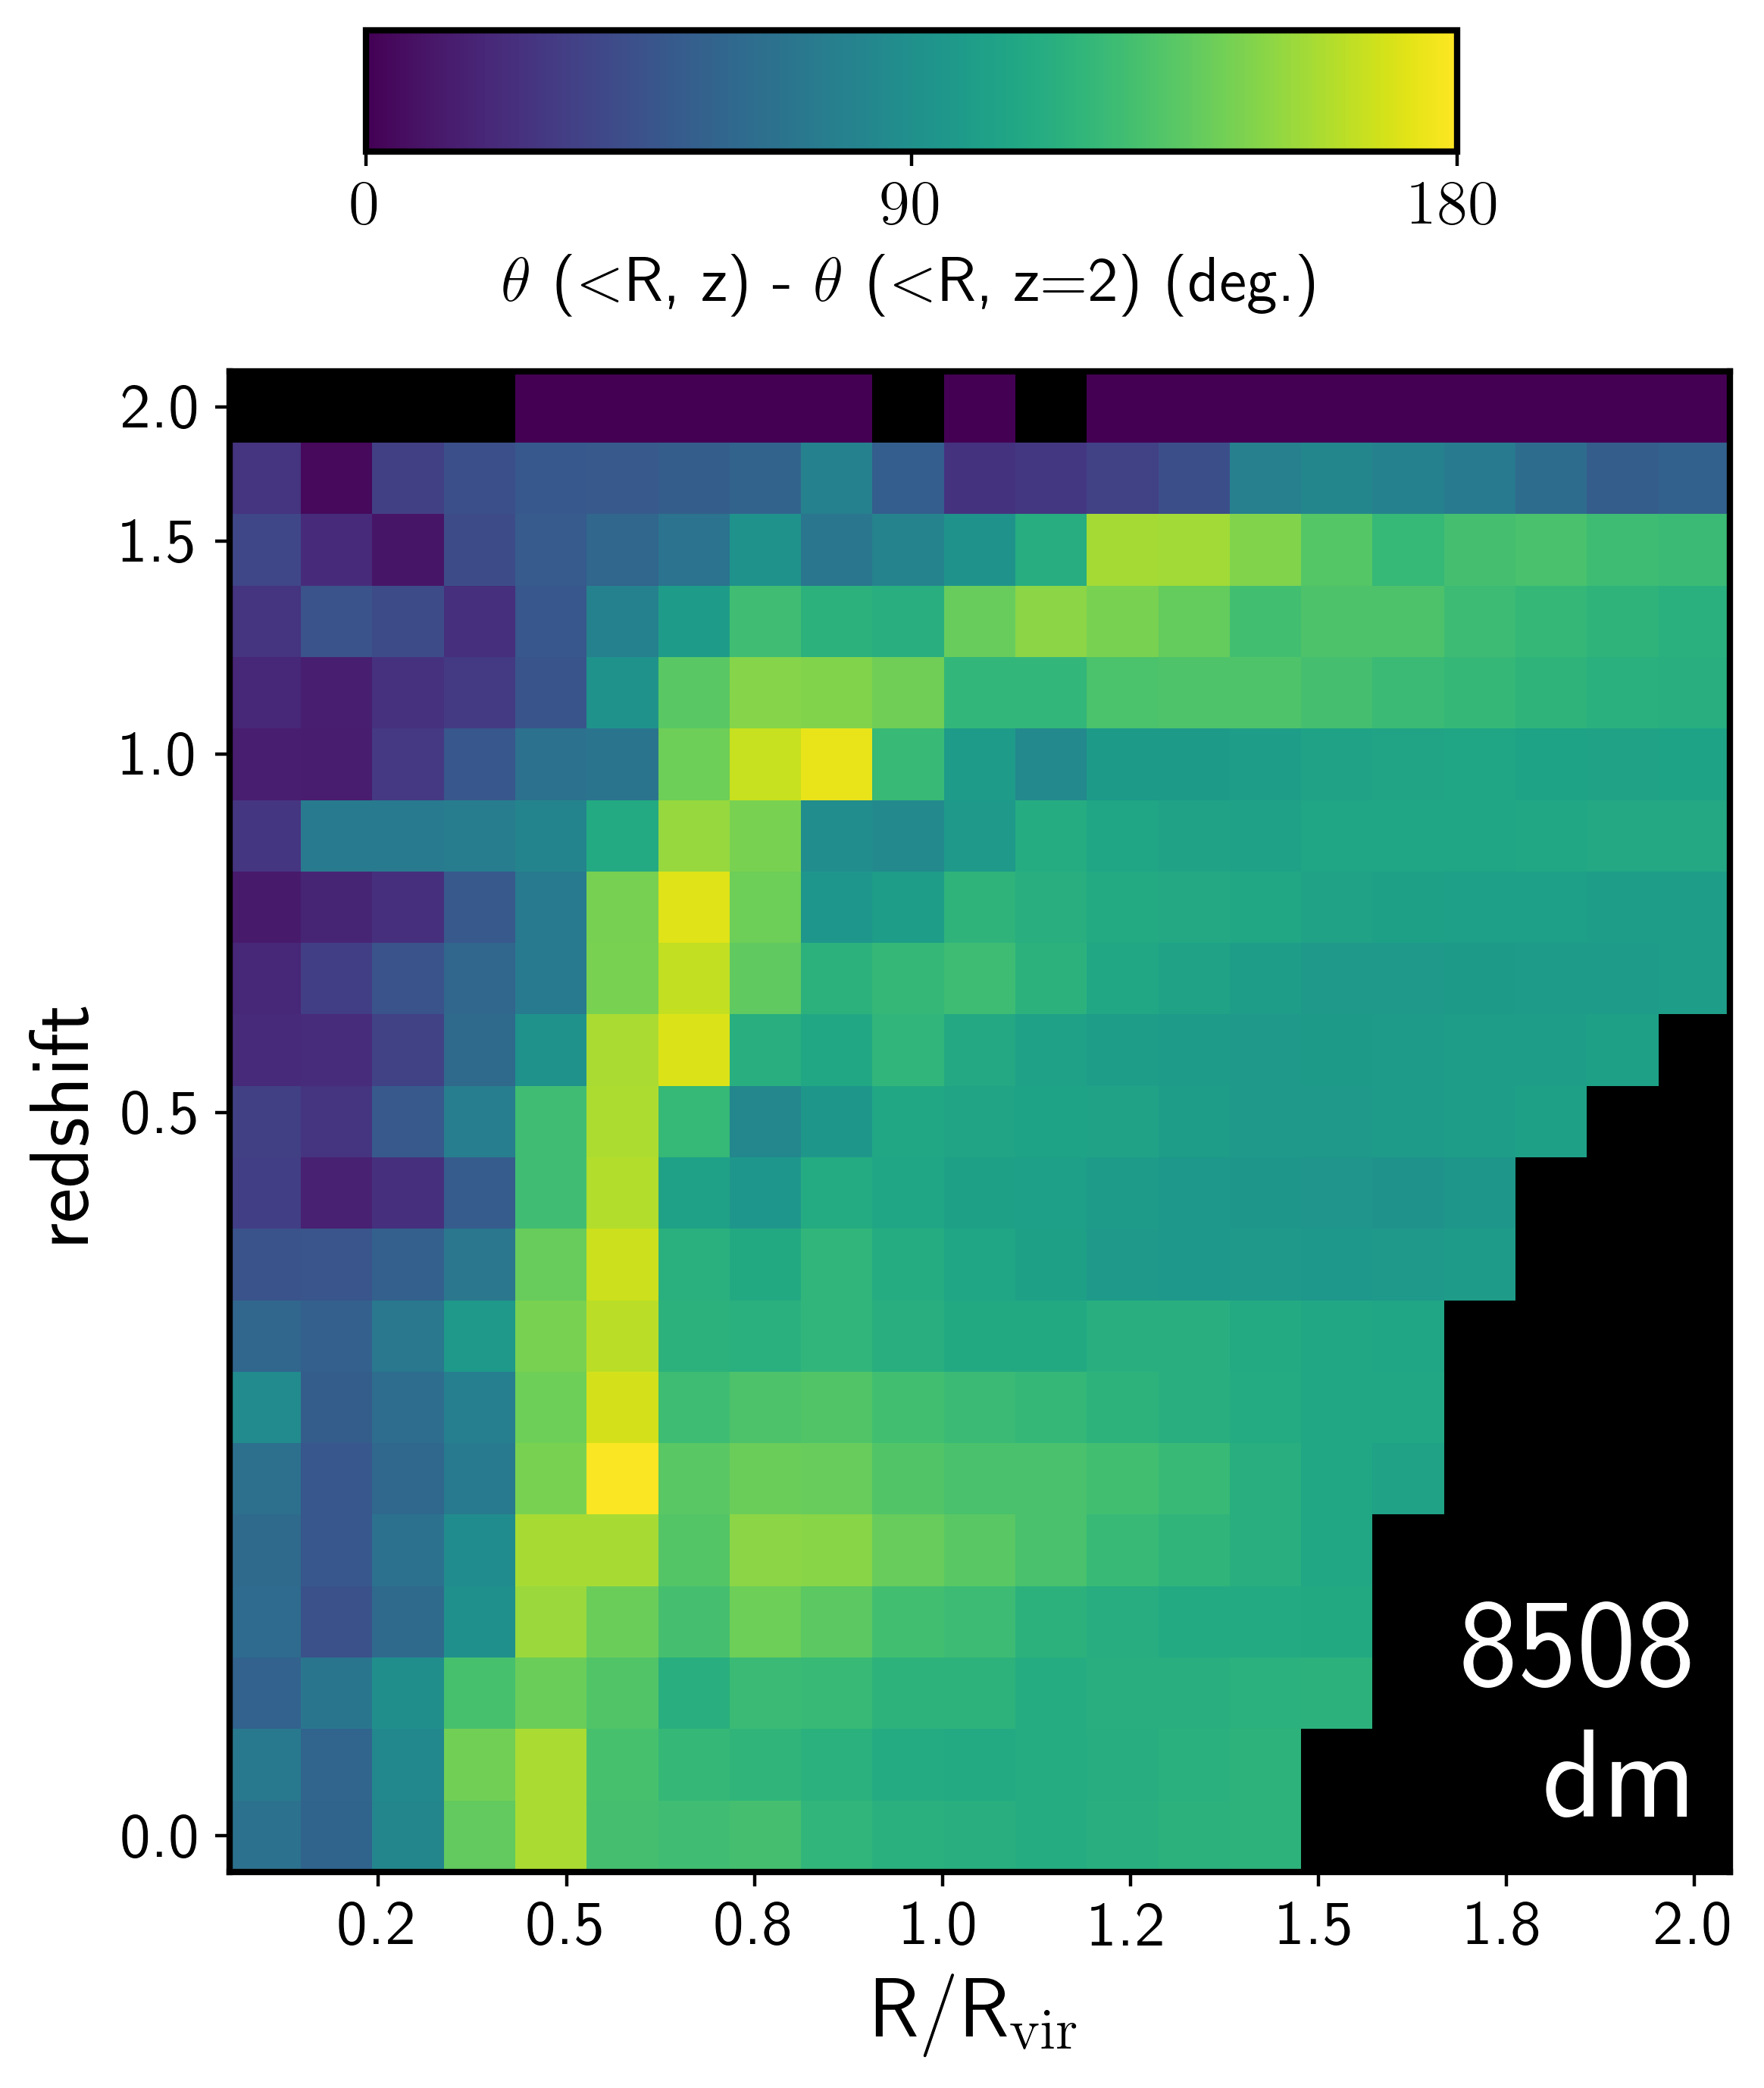

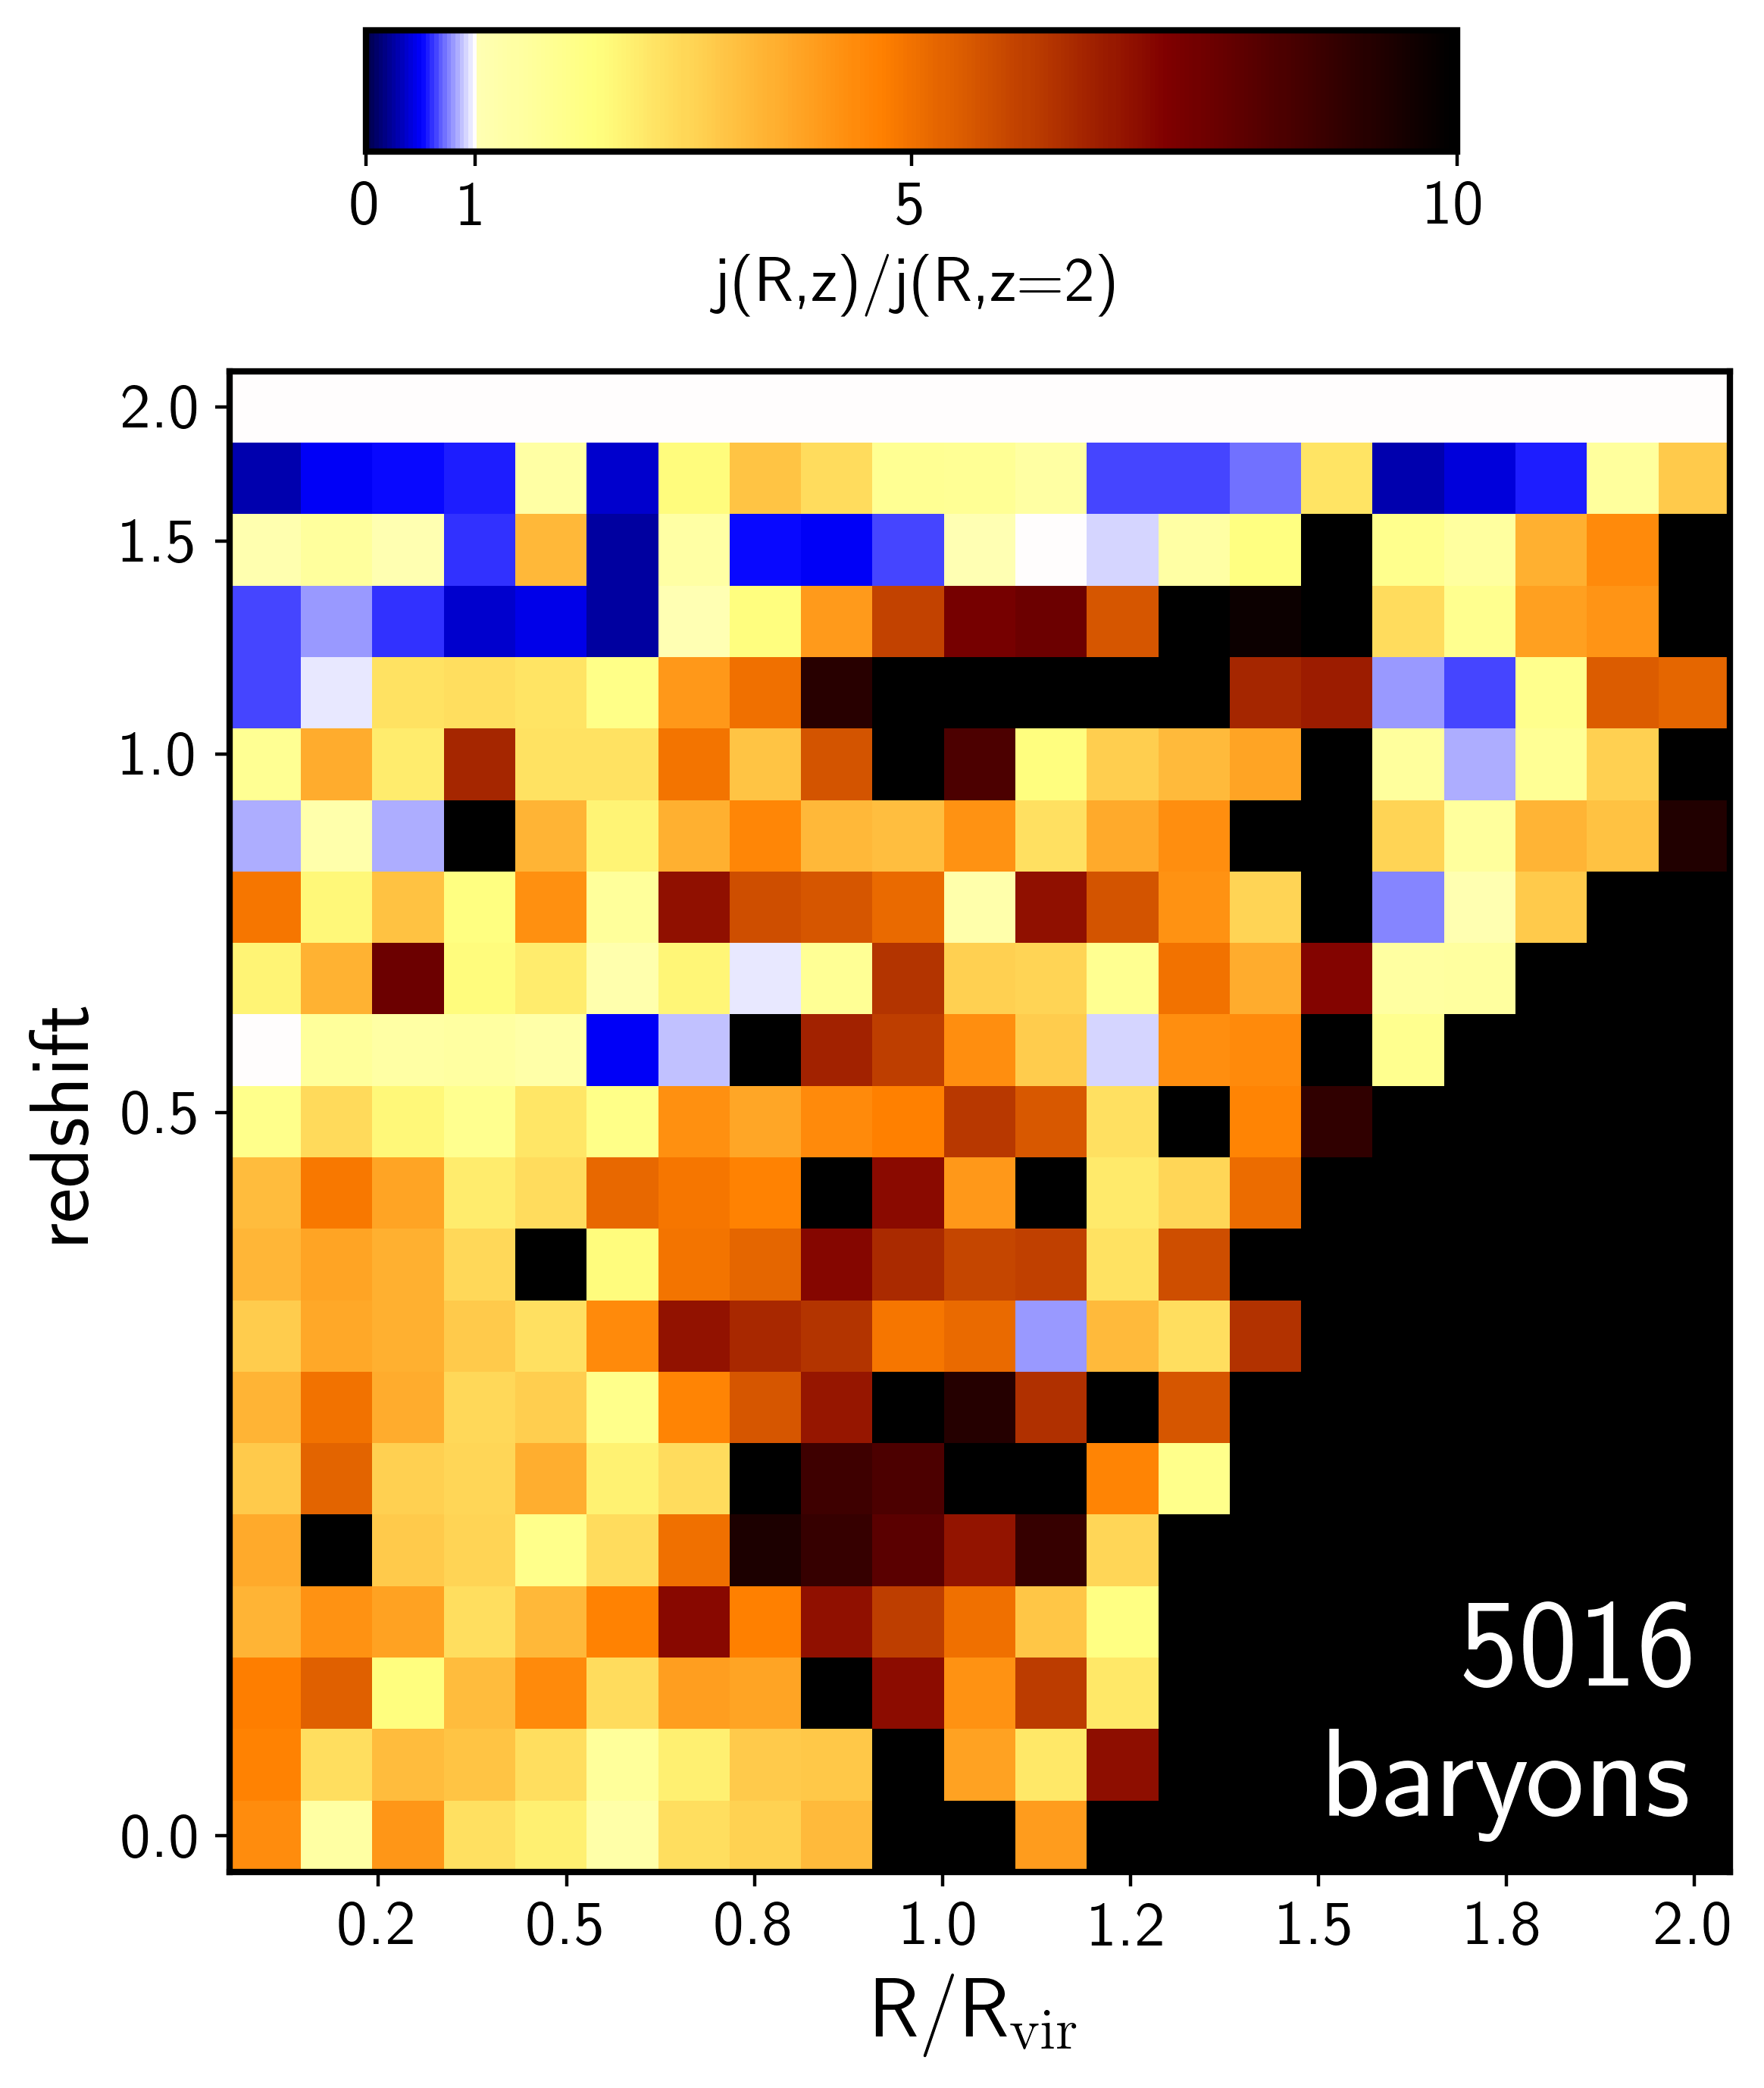

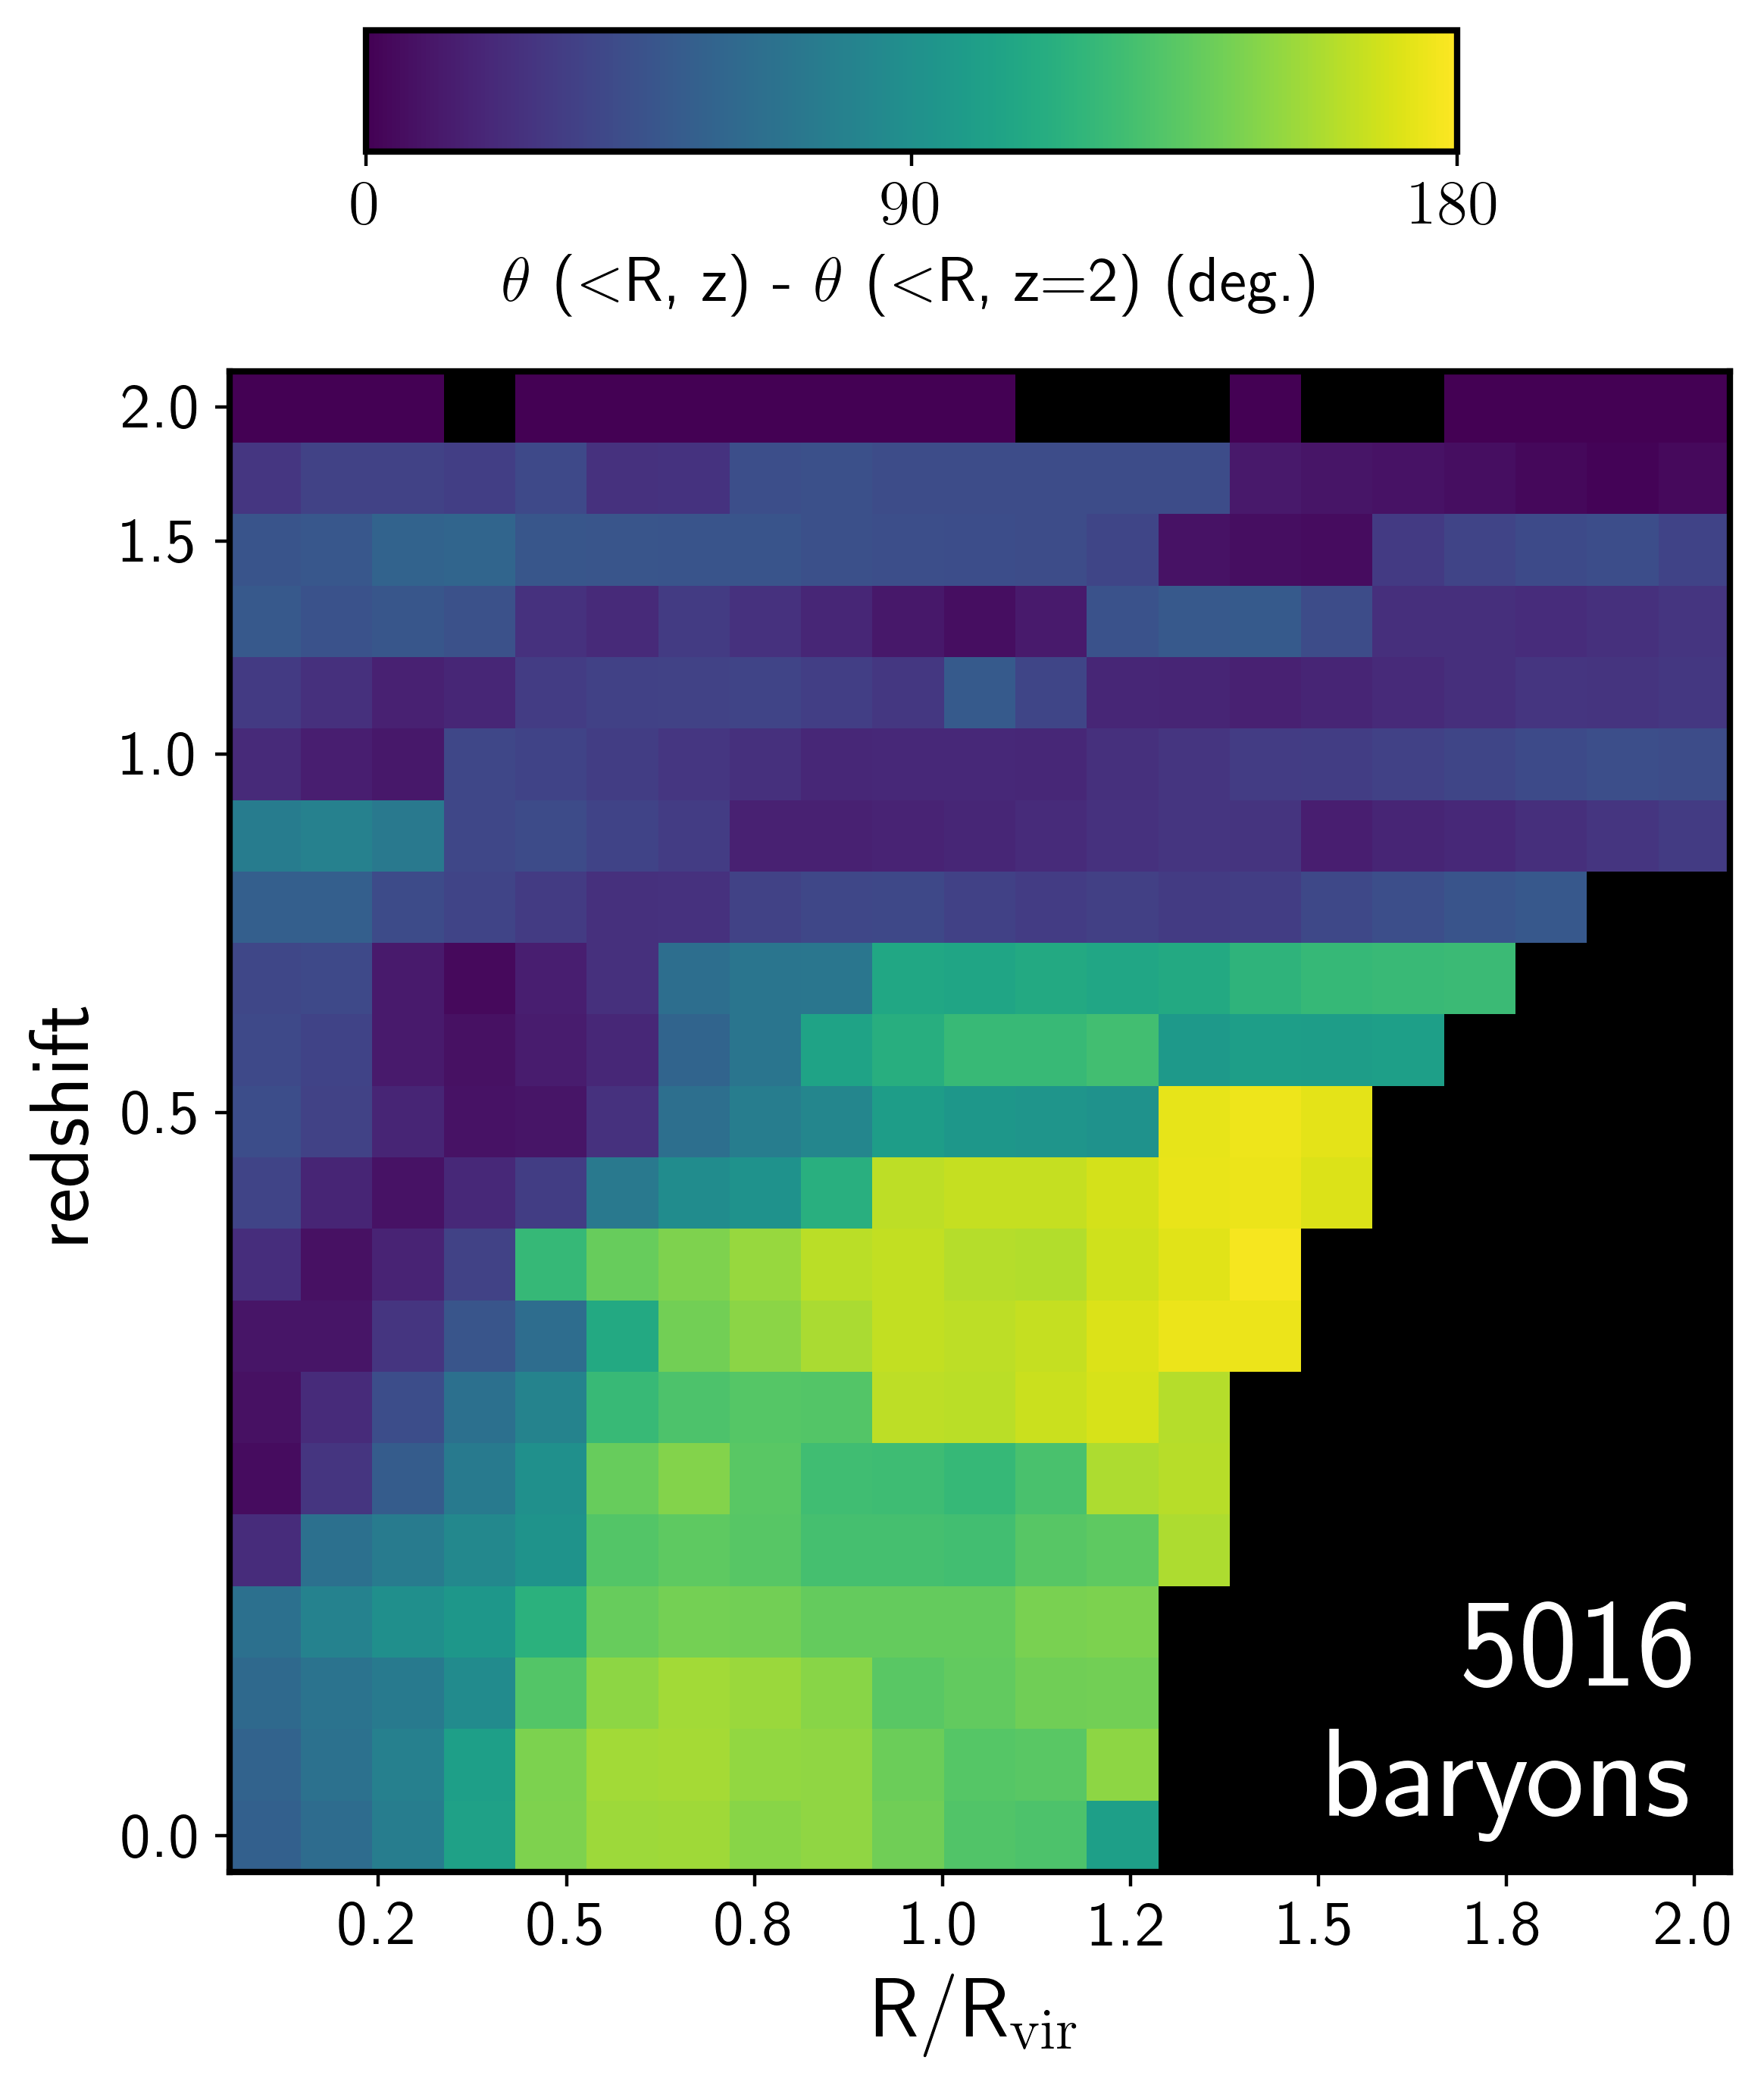

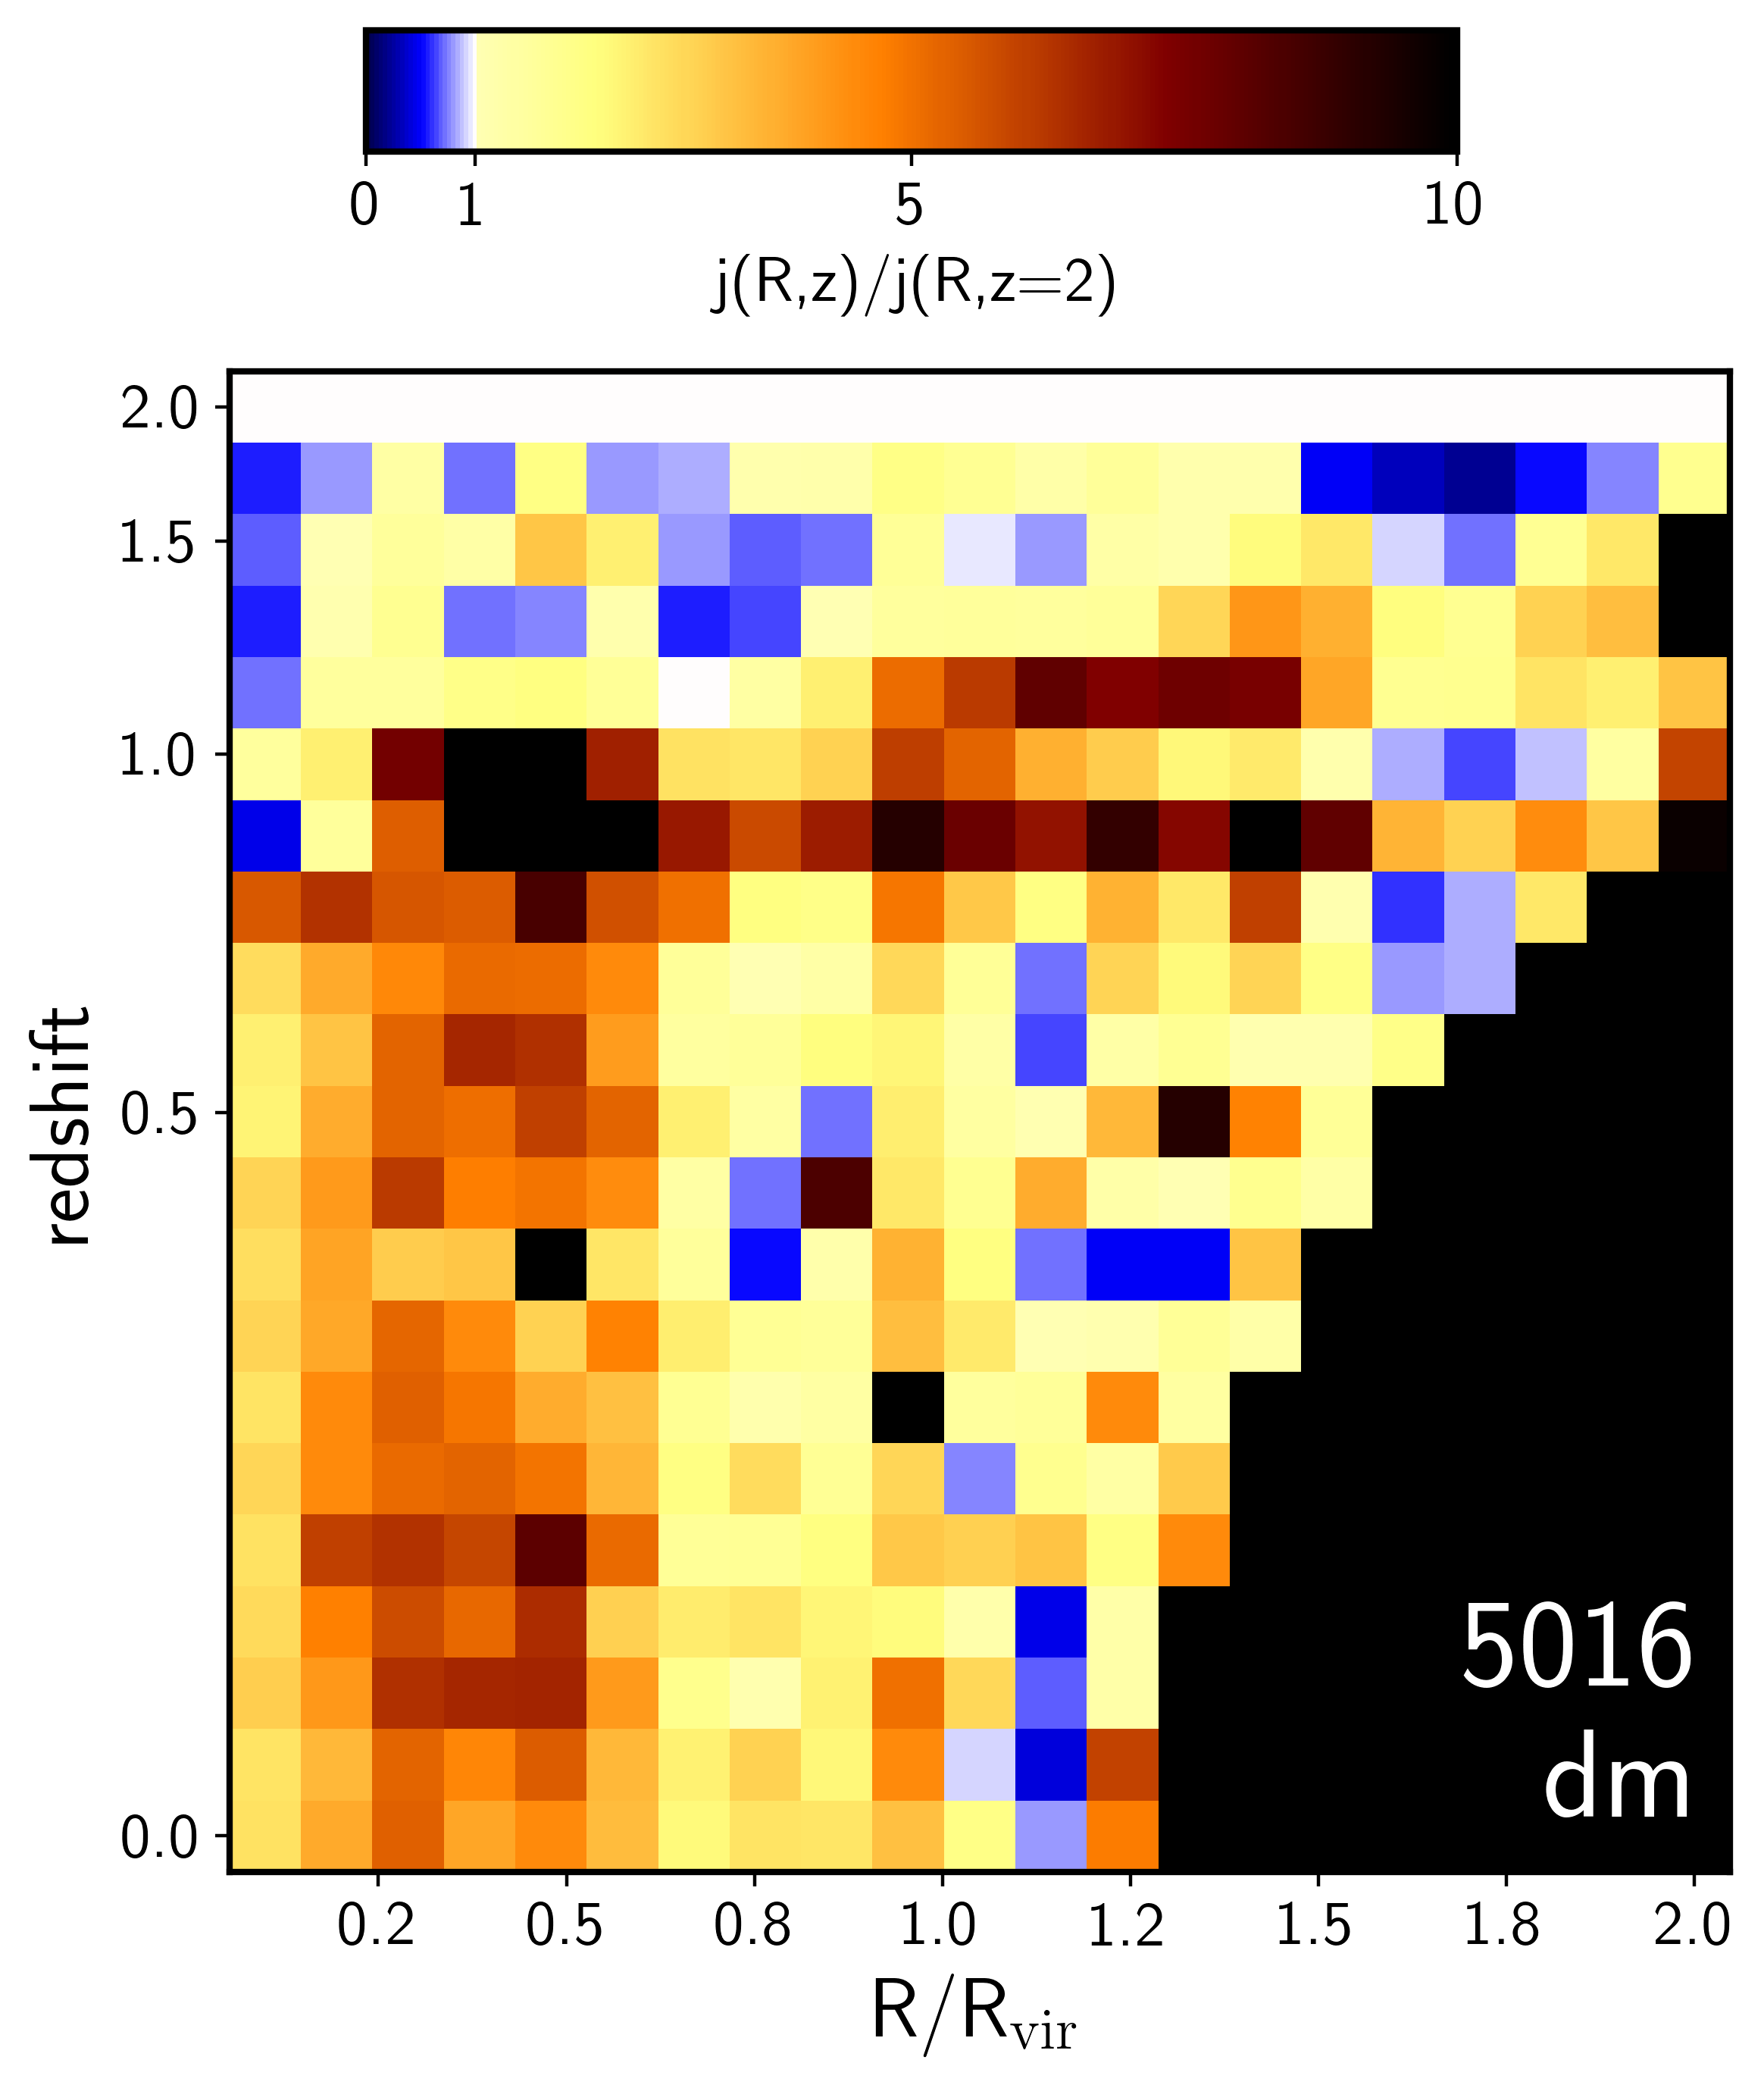

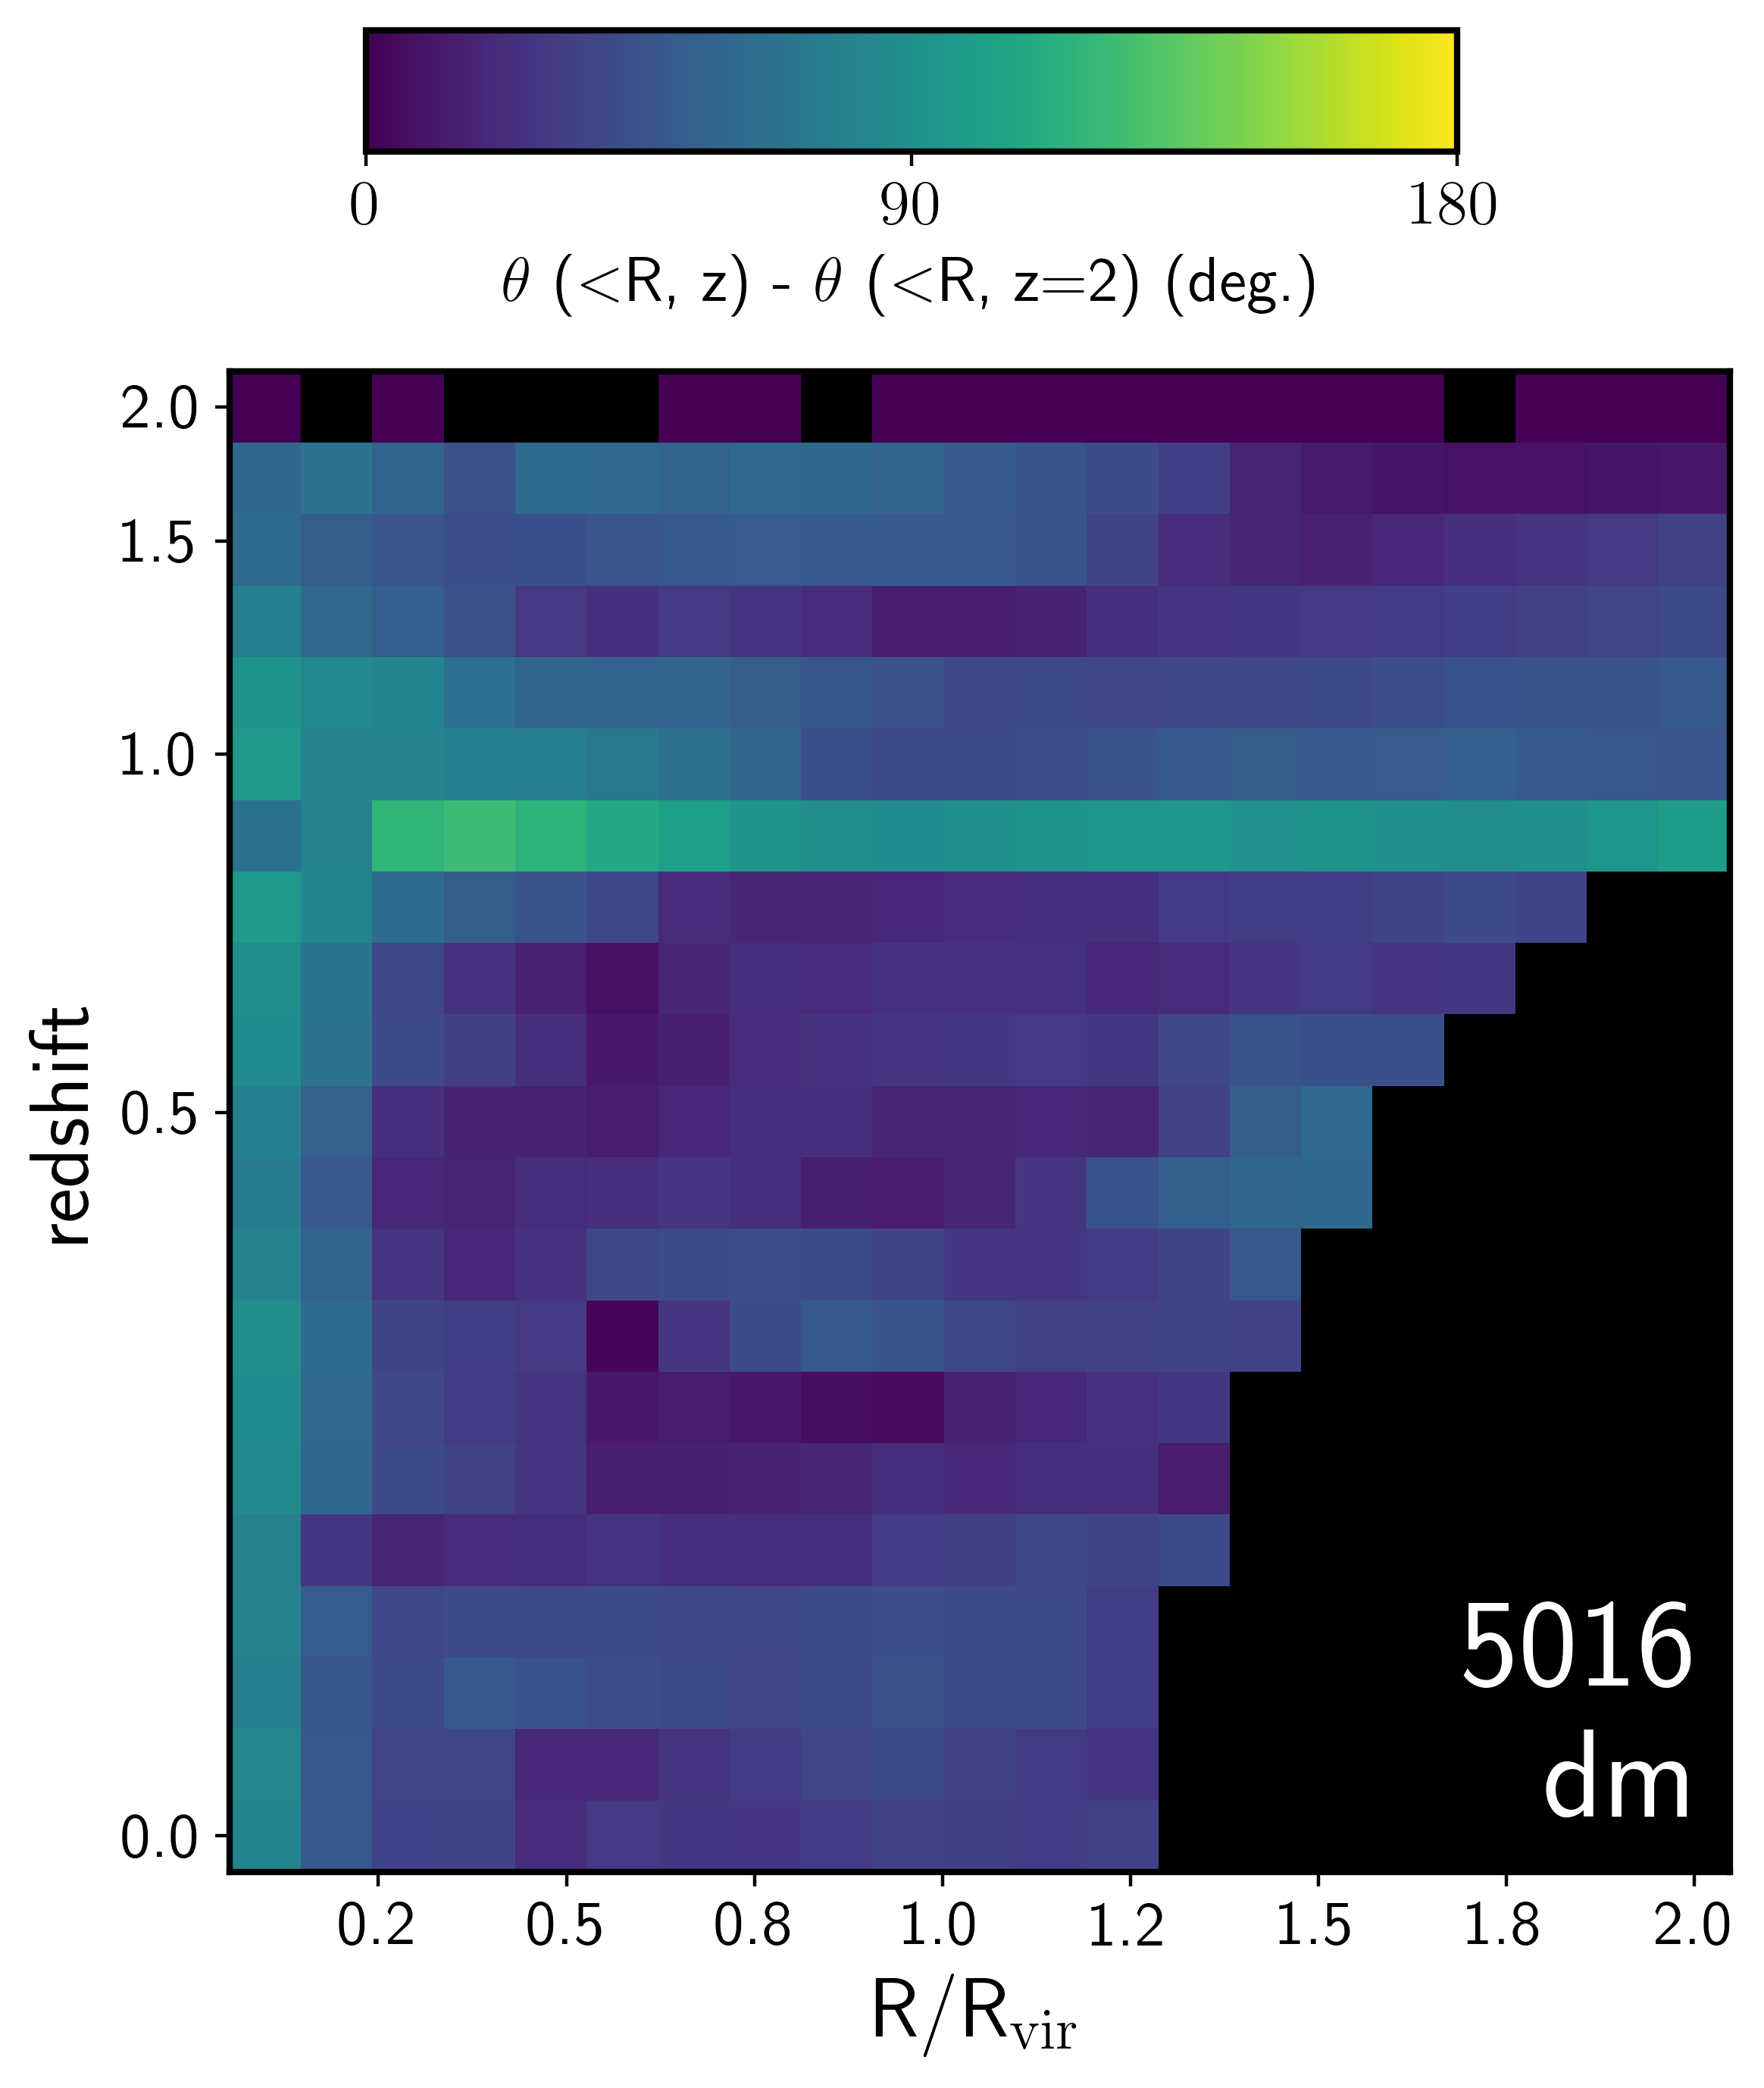

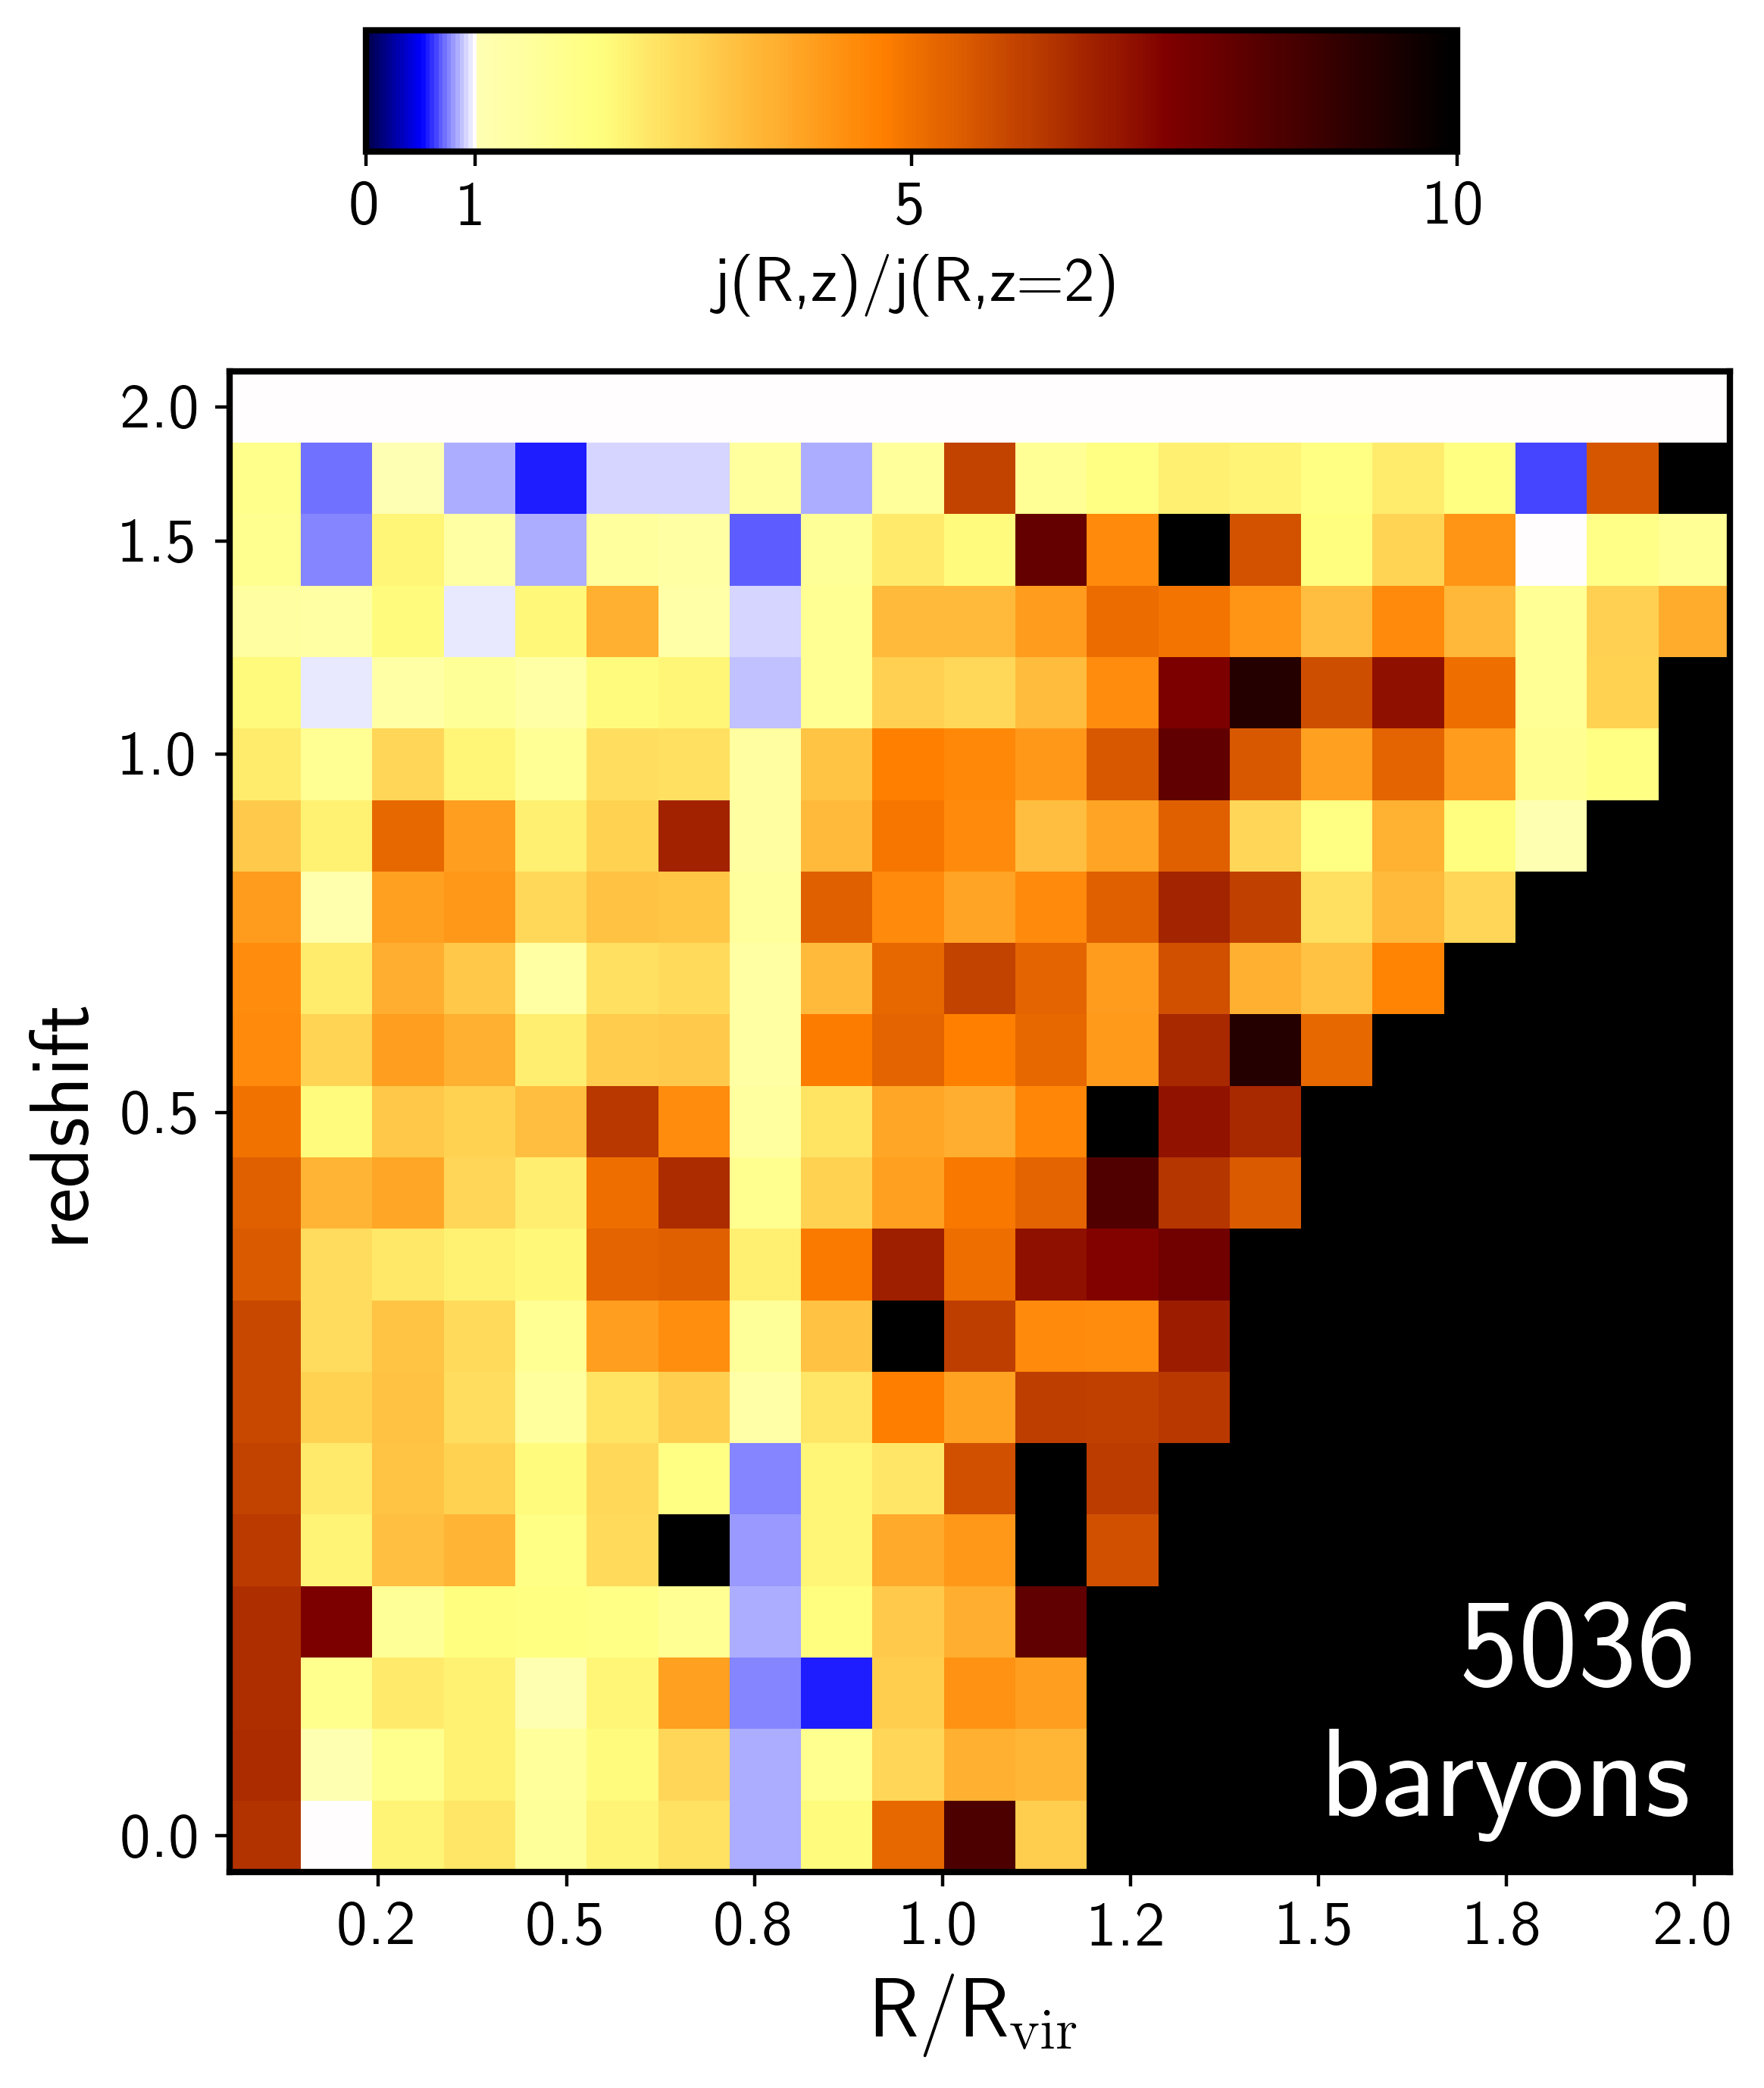

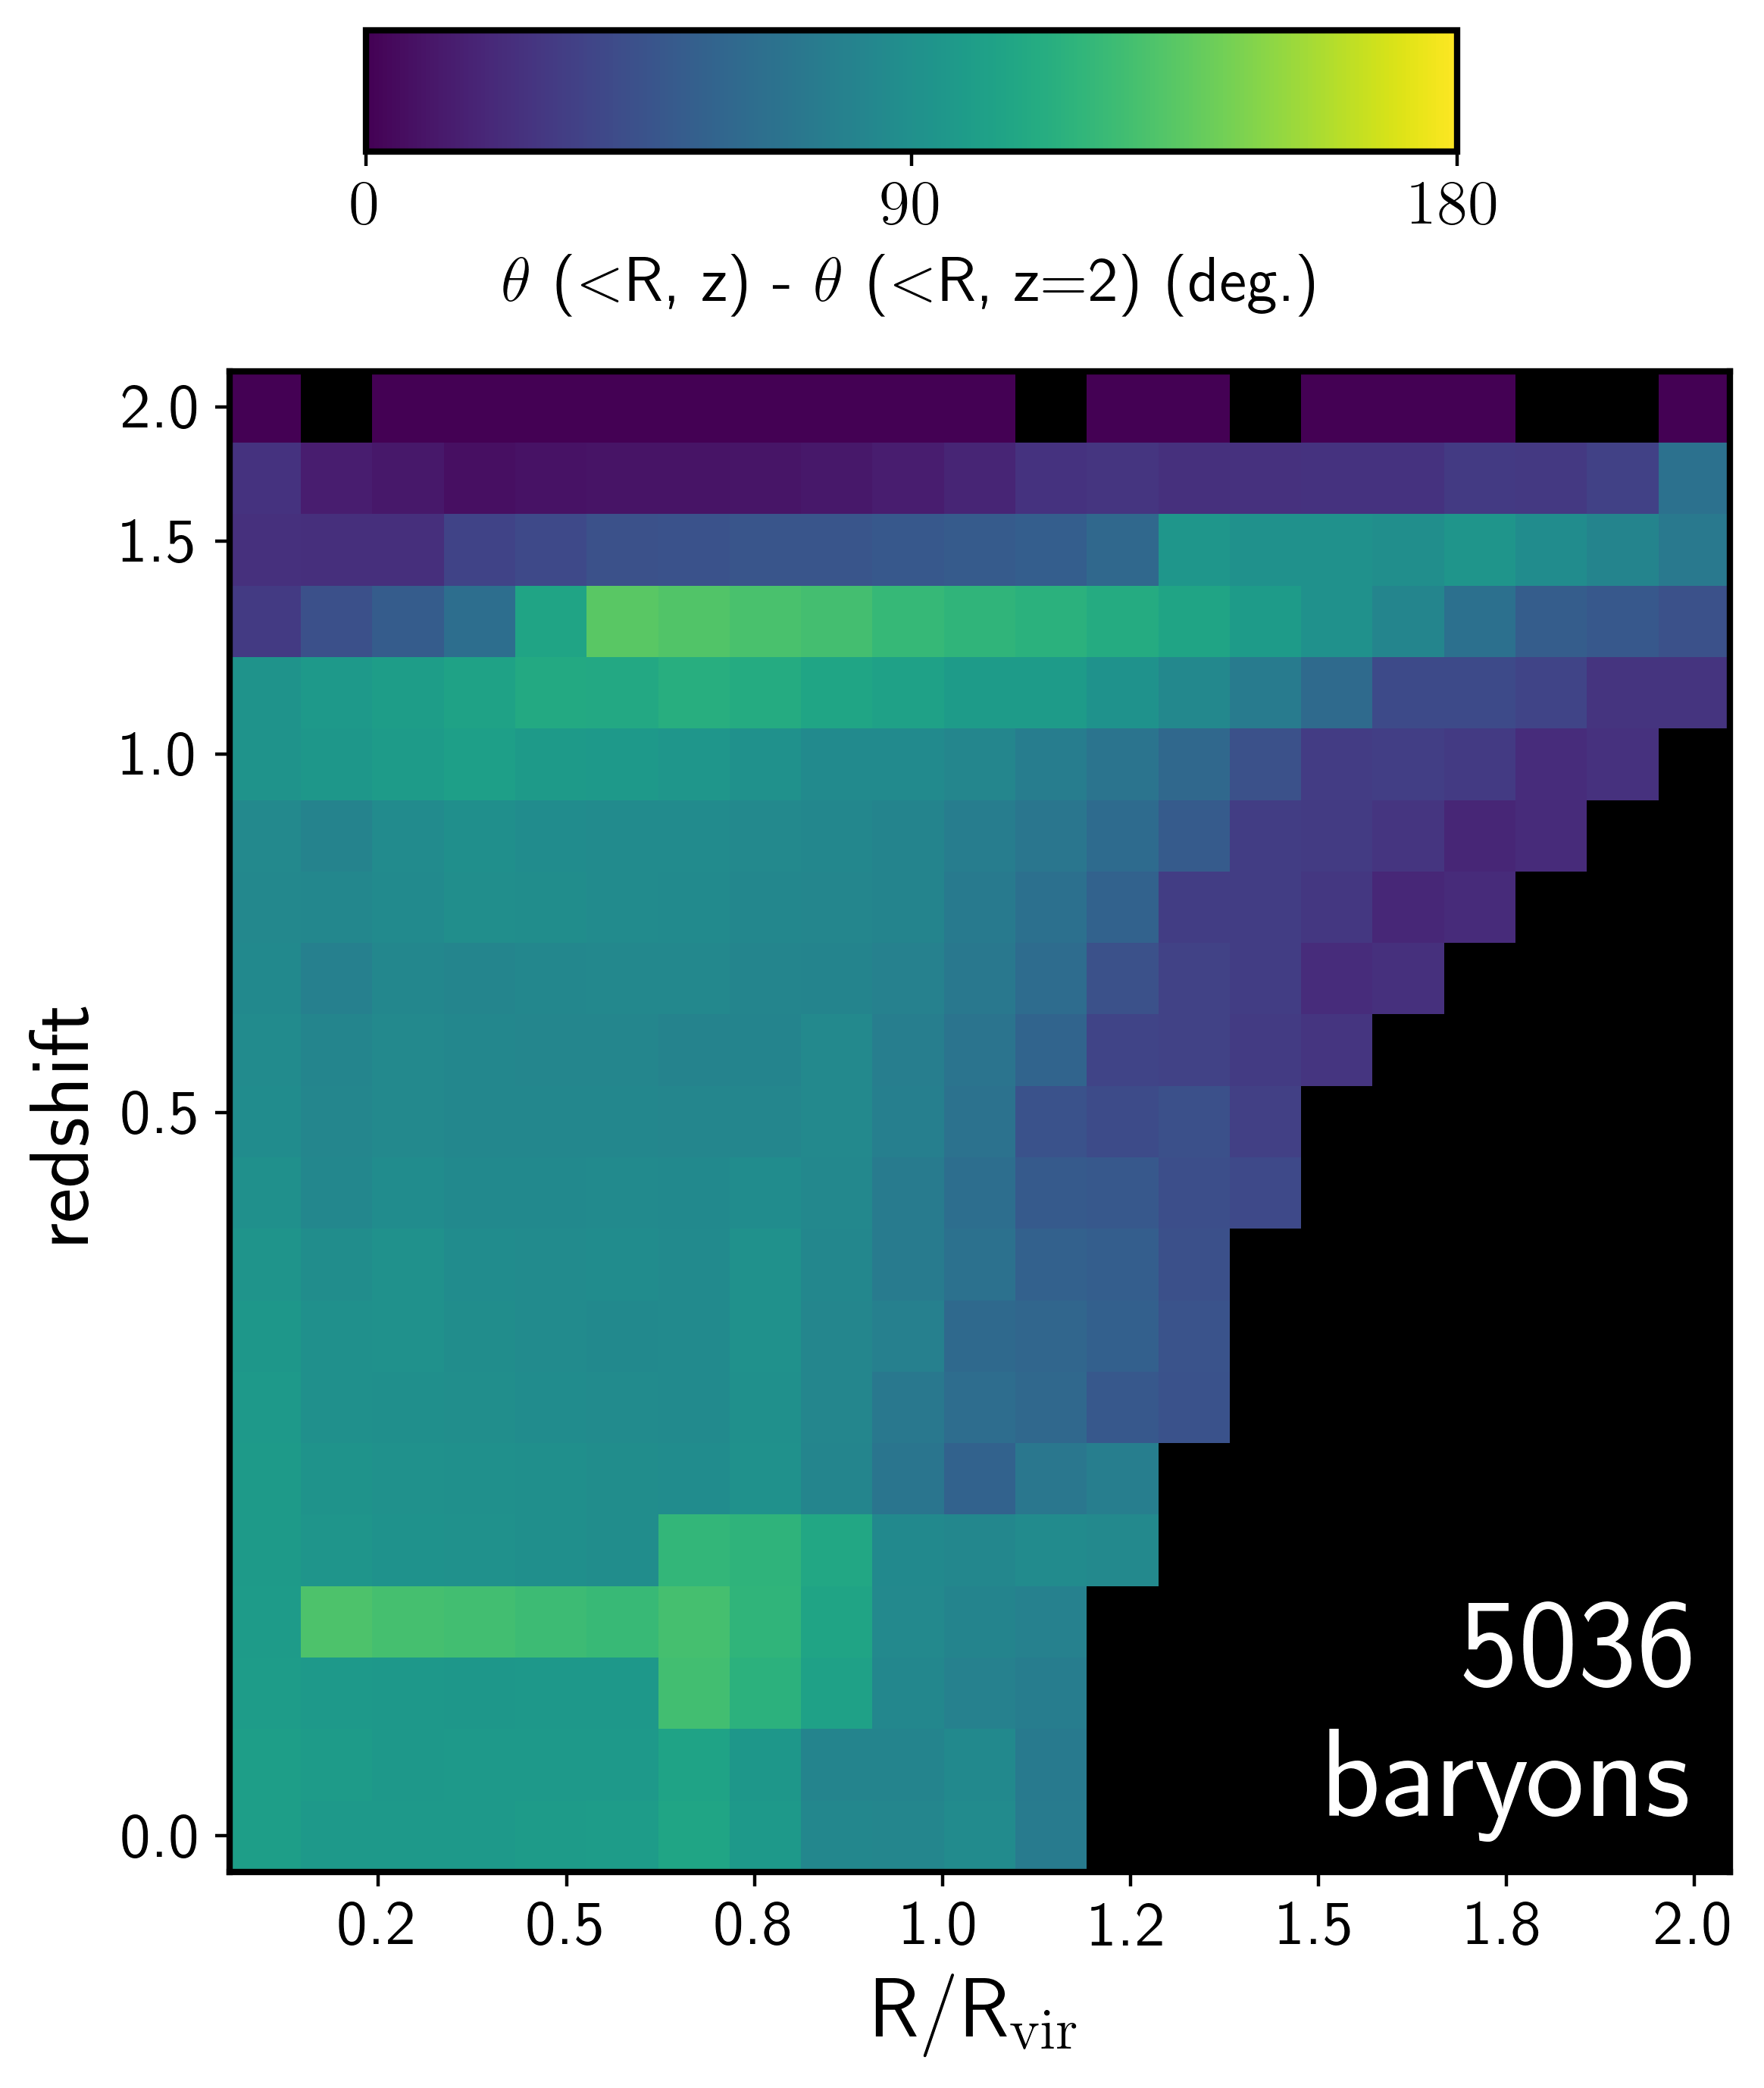

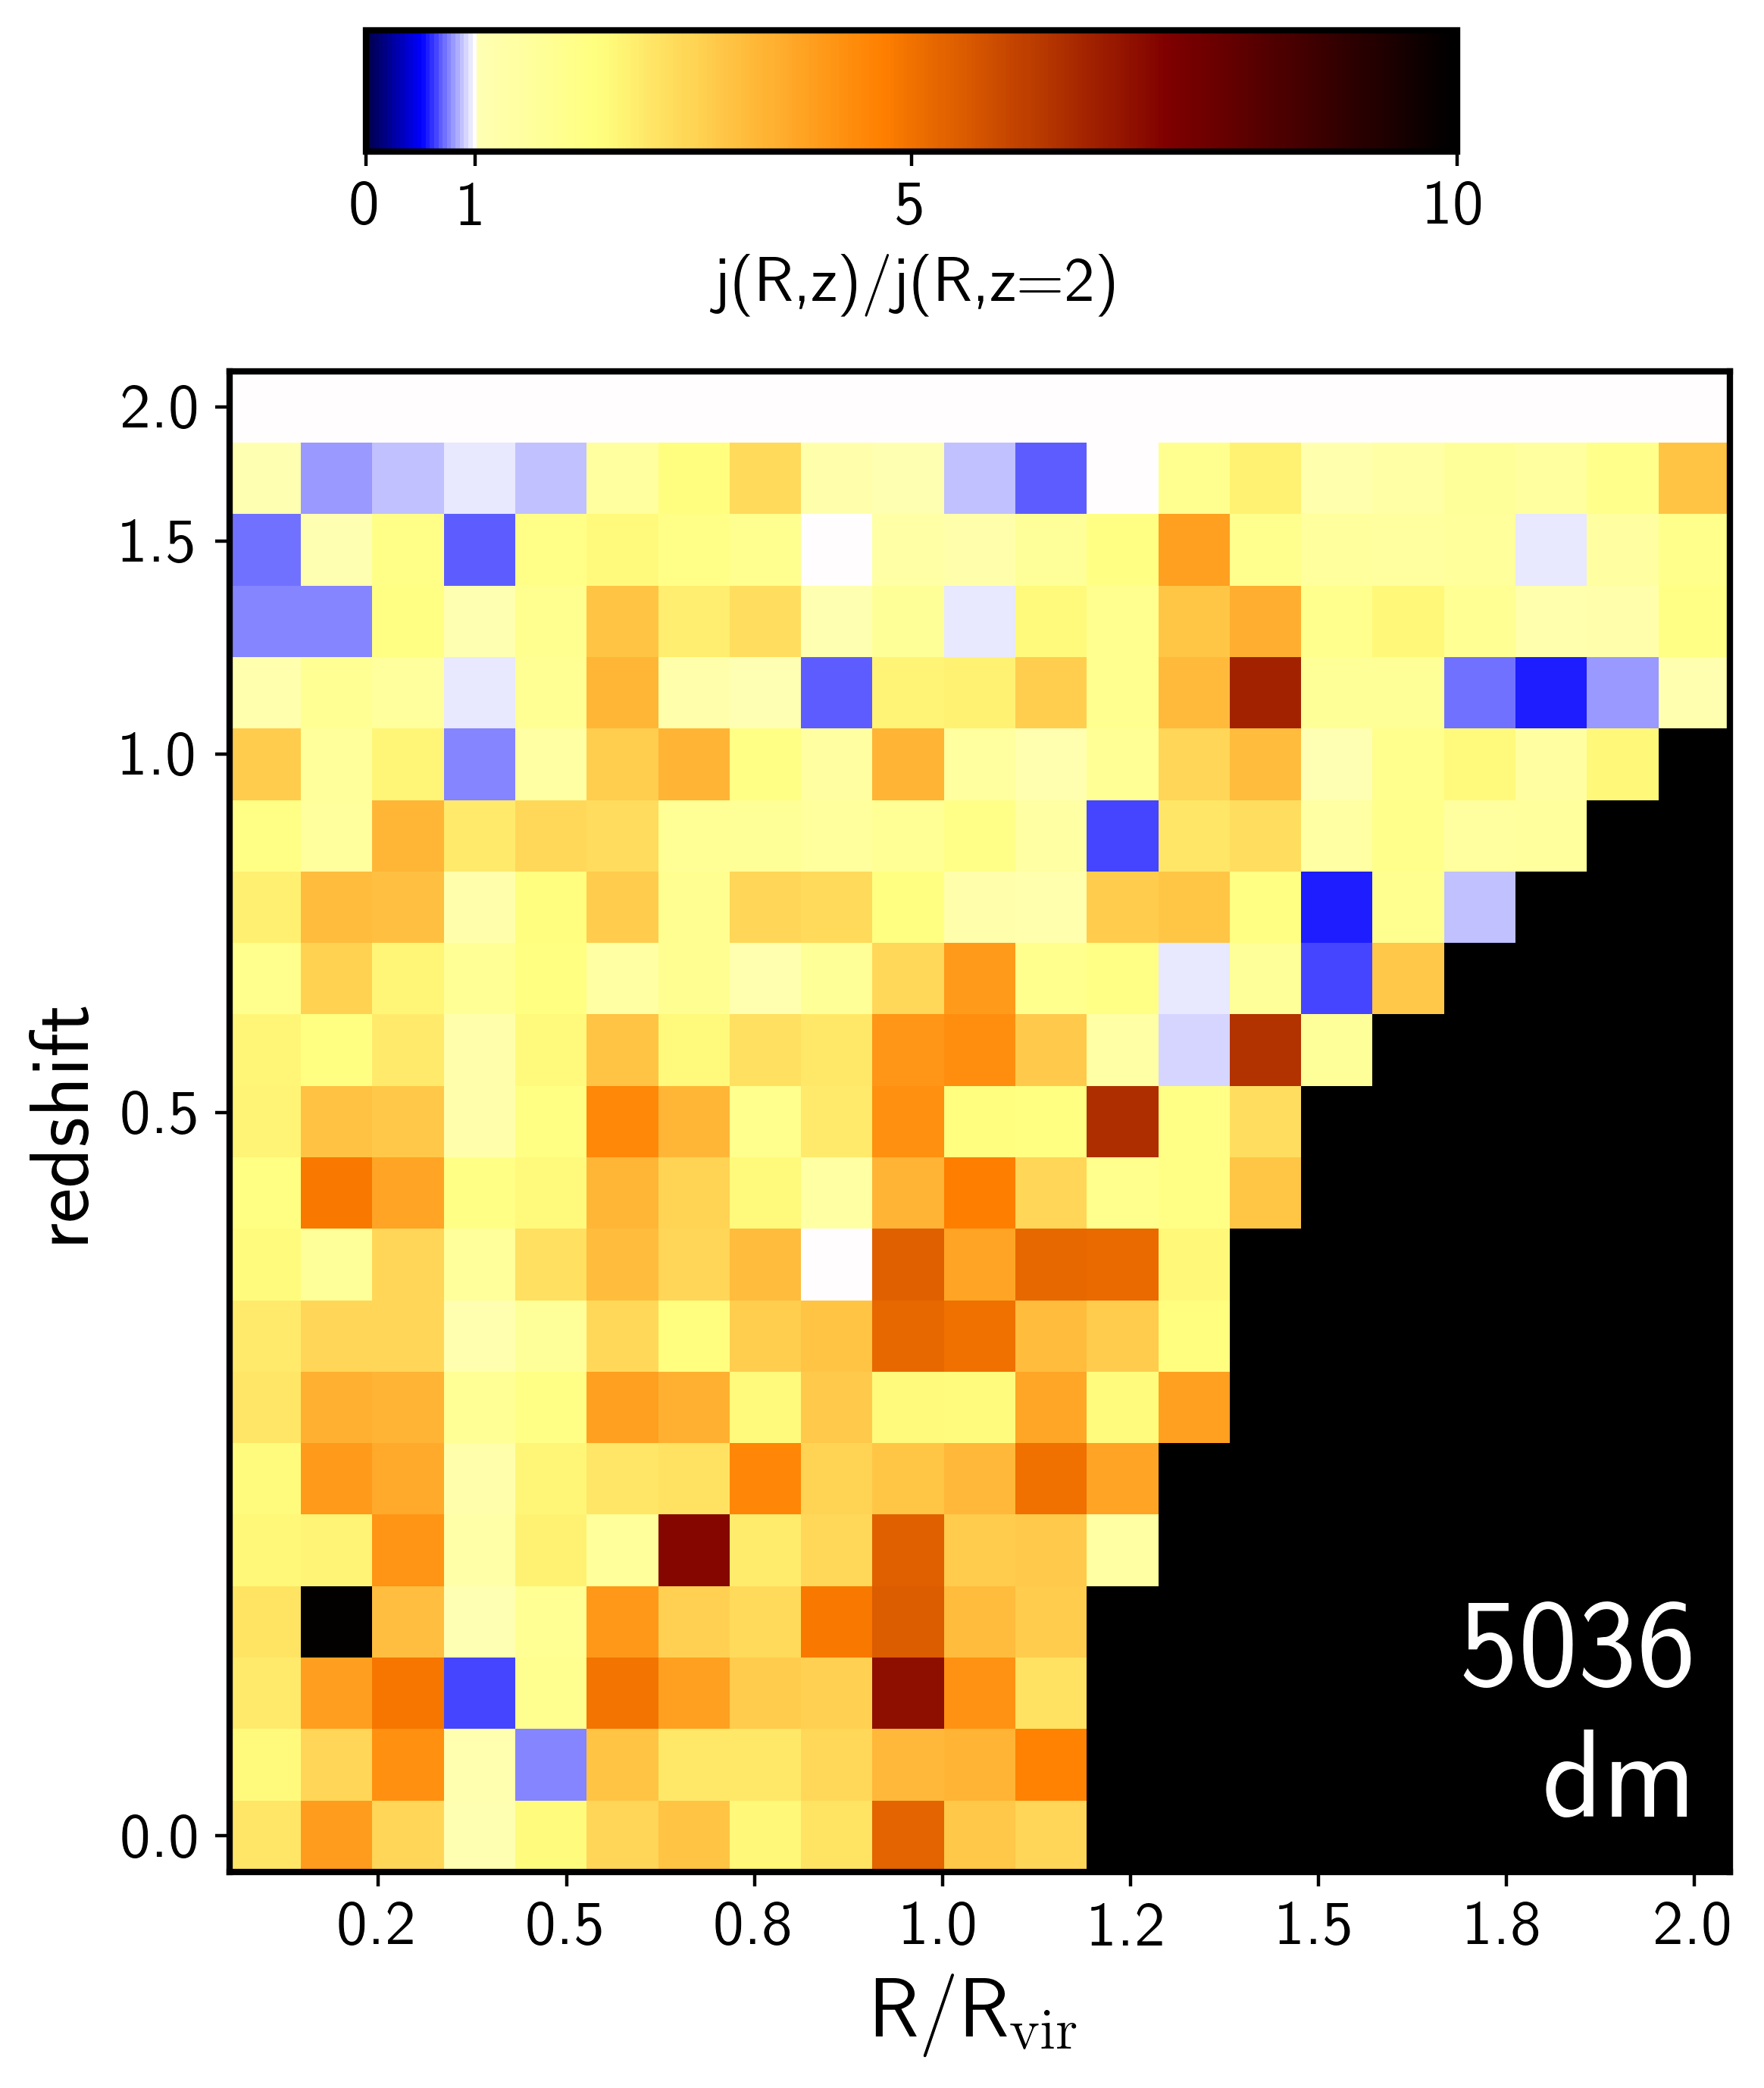

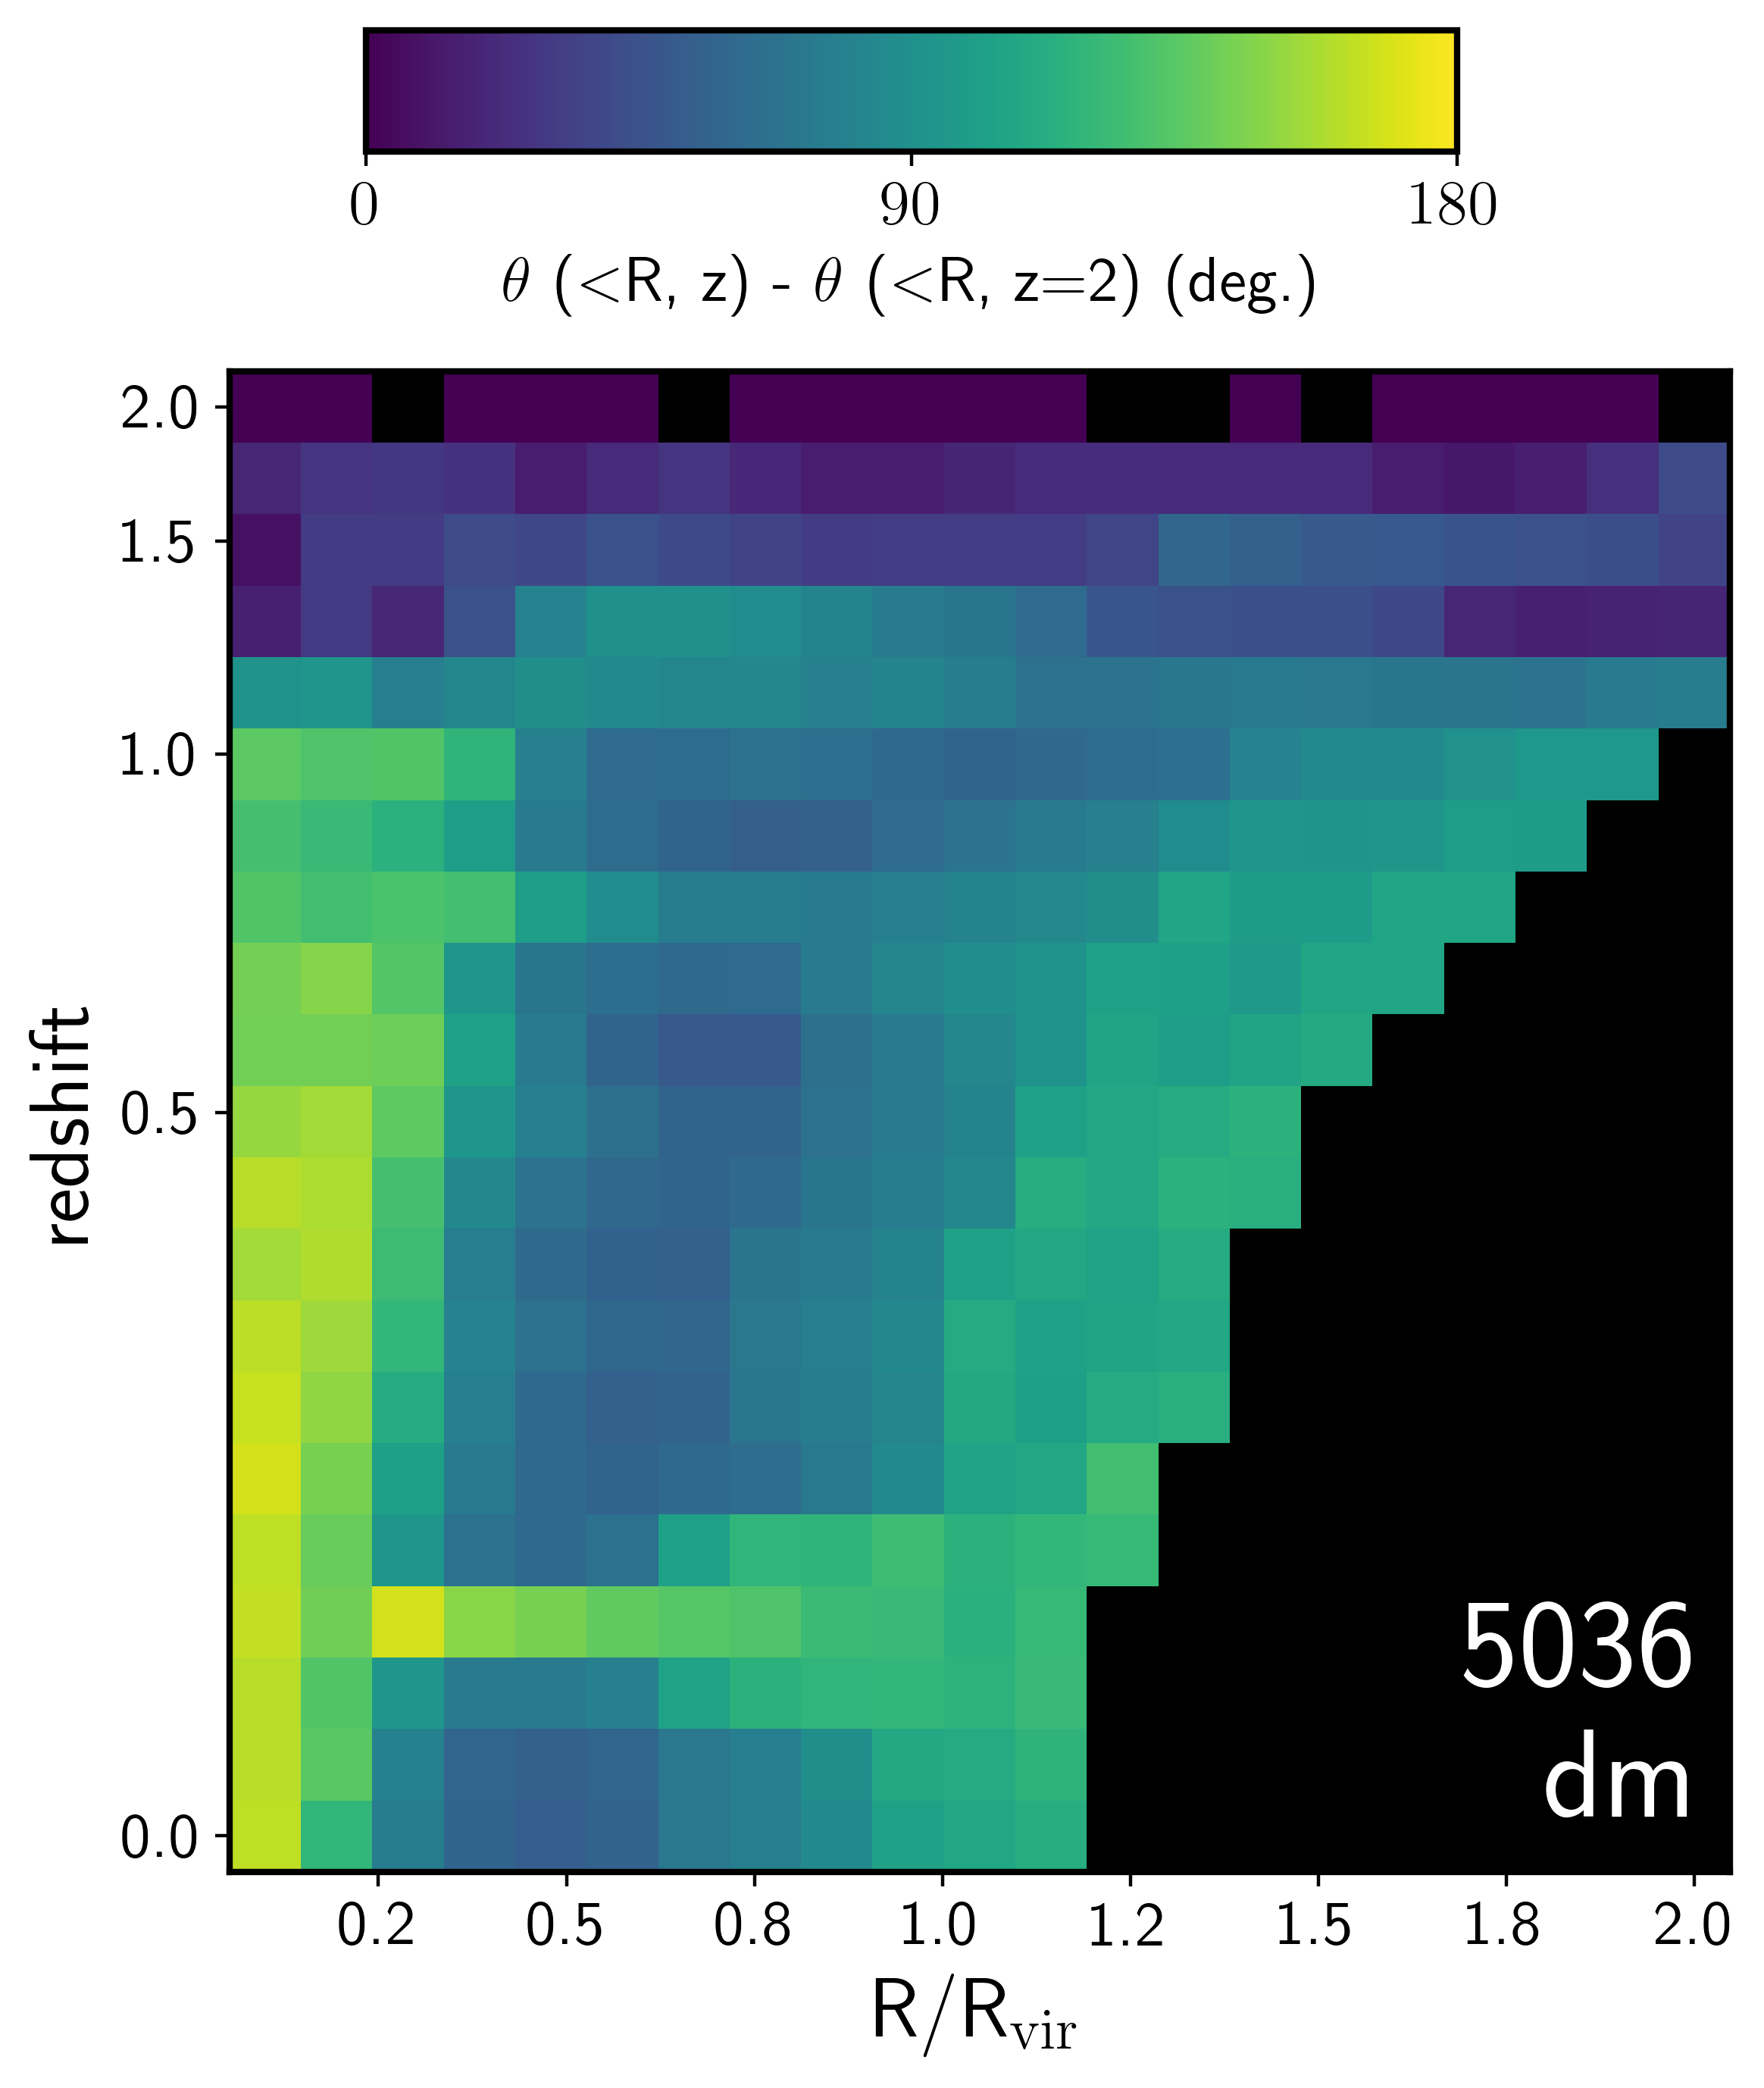

In [258]:
halos = ['8508', '5016', '5036']#, '4123', '2392', '2878']
         
clrs = {'cold': 'darkblue',
        'warm': 'indianred',
        'warmhot': 'red',
        'hot': 'darkred',
        'stars': 'goldenrod',
        'dm': 'black',
        'baryons': 'green'}
if True:
    mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars', 'baryons', 'dm']
    prof_dir = '/Users/rsimons/Dropbox/foggie/angular_momentum/profiles'
else:
    mass_types = ['cold', 'warm', 'warmhot', 'hot', 'stars', 'new_stars', 'baryons', 'dm']
    prof_dir = '/Users/rsimons/Dropbox/foggie/angular_momentum/new_profiles_temp'
matplotlib.rcParams.update({'font.size': 15})
for halo in halos:
    DD_fls = sort(glob('%s/%s/Lprof_%s_DD????.npy'%(prof_dir, halo, halo)))
    DD_fls = DD_fls
    rvir_masses = Table.read('/Users/rsimons/Dropbox/git/foggie/foggie/halo_infos/00%s/nref11c_nref9f/rvir_masses.hdf5'%halo)
    
    
    
    for mtype in mass_types:
        if (mtype != 'dm') & (mtype !='baryons'): continue
        fig1, ax1 = plt.subplots(1,1, figsize = (6., 8), facecolor = 'white')
        fig2, ax2 = plt.subplots(1,1, figsize = (6., 8), facecolor = 'white')
        axes = [ax1, ax2]
        big_im = np.zeros((len(DD_fls), len(DD_fls)))
        big_cos_im = np.zeros((len(DD_fls), len(DD_fls)))
        
        redshift_all = []
        for di, DD_fl in enumerate(DD_fls):
            DD = DD_fl.split('/')[-1][-10:-4]
            DD_track.append(DD)
            rvir      = yt.YTArray(rvir_masses['radius'][rvir_masses['snapshot'] == DD].data, 'kpc')
            mvir      = yt.YTArray(rvir_masses['total_mass'][rvir_masses['snapshot'] == DD].data, 'Msun')
            redshift  = rvir_masses['redshift'][rvir_masses['snapshot'] == DD].data
            redshift_all.append(round(float(redshift), 2))
            Lprof = np.load('%s/%s/Lprof_%s_%s.npy'%(prof_dir, halo, halo, DD), allow_pickle = True)[()]

            if mtype == 'baryons':
                r  = Lprof['cold']['rprof']['r']
                Lx = np.zeros(len(r))
                Ly = np.zeros(len(r))
                Lz = np.zeros(len(r))
                M  = np.zeros(len(r))
                for ms in mass_types[:-3]:
                    Lx += Lprof[ms]['rprof']['Lx']
                    Ly += Lprof[ms]['rprof']['Ly']
                    Lz += Lprof[ms]['rprof']['Lz']
                    M  += Lprof[ms]['rprof']['mass']
            else:
                r  = Lprof[mtype]['rprof']['r']
                Lx = Lprof[mtype]['rprof']['Lx']
                Ly = Lprof[mtype]['rprof']['Ly']
                Lz = Lprof[mtype]['rprof']['Lz']
                M  = Lprof[mtype]['rprof']['mass']

            Lx_cs = np.cumsum(Lx)
            Ly_cs = np.cumsum(Ly)
            Lz_cs = np.cumsum(Lz)
            M_cs  = np.cumsum(M)

            r_rvir = r/rvir.value

            L = np.sqrt(Lx**2. + Ly**2. + Lz**2.)
            j = (L/M).to('kpc * km/s')
            gd = ~np.isnan(j)
            j   = j
            r_rvir = r_rvir
            x_use = np.linspace(0.1, 2, len(big_im))
            
            j_interp = np.interp(x_use, r_rvir[gd], j[gd], right=np.nan)
            
            if di == 0: 
                Lx_cs_orig = Lx_cs.copy()
                Ly_cs_orig = Ly_cs.copy()
                Lz_cs_orig = Lz_cs.copy()
                L_cs_orig = np.array([Lx_cs_orig, Ly_cs_orig, Lz_cs_orig])
                j_interp_orig = j_interp.copy()
                r_rvir    = r_rvir.copy()
                
            big_im[di] = j_interp/j_interp_orig

            L_cs = np.array([Lx_cs, Ly_cs, Lz_cs])
            deg_at_r = []
            for xx in arange(shape(L_cs)[1]):
                L_cs_i      = L_cs[:, xx]
                L_cs_orig_i = L_cs_orig[:, xx]
                deg_at_r.append(180./pi * np.arccos(np.dot(L_cs_i, L_cs_orig_i)/np.sqrt(np.sum(L_cs_i**2.) * np.sum(L_cs_orig_i**2.))))
            deg_at_r = np.array(deg_at_r)
            
            big_cos_im[di] = np.interp(x_use, r_rvir, deg_at_r, right=np.nan)

            #big_cos_im[di] = 180./pi*np.arccos(np.dot(L_cs, L_cs_orig)/(np.sqrt(np.sum(L_cs**2.) * np.sum(L_cs_orig**2.))))
                
                

        #ax.imshow(log10(big_im), cmap = 'viridis', vmin = -1, vmax = 1.5)
        import matplotlib.colors as mcolors
        colors1 = plt.cm.seismic(np.linspace(0., 0.50, 26))
        colors2 = plt.cm.afmhot_r(np.linspace(0.15, 1, 230))
        colors = np.vstack((colors1, colors2))
        cmp = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

        #cmp = plt.cm.seismic
        cmp.set_bad('k')
        im1 = ax1.imshow(big_im, cmap = cmp, vmin = 0, vmax = 10.)
        im2 = ax2.imshow(big_cos_im, cmap = 'viridis', vmin = 0., vmax = 180)
        for ax in axes:
            ax.set_xlabel('R/R$_{\mathrm{vir}}$', fontsize = 20)
            ax.set_ylabel('redshift', fontsize = 20)
            redshift_tick_use = np.arange(2.0, -0.5, -0.5)
            redshift_tick_loc = np.interp(redshift_tick_use, np.array(redshift_all)[::-1], np.arange(len(redshift_all))[::-1])
            ax.set_yticks(redshift_tick_loc)
            ax.set_yticklabels(['%.1f'%red for red in redshift_tick_use])
            rvir_tick_use = np.arange(0.25, 2.25, 0.25)
            rvir_tick_loc = np.interp(rvir_tick_use, x_use, np.arange(len(x_use)))
            ax.set_xticks(rvir_tick_loc)
            ax.set_xticklabels(['%.1f'%rv for rv in rvir_tick_use])
        
        for fig in [fig1, fig2]: 
            fig.set_dpi(400)
            fig.subplots_adjust(top = 0.9, bottom = 0.1, right = 0.95)

        cbar_ax = fig1.add_axes([0.20, 0.90, 0.60, 0.05])
        cbar1 = fig1.colorbar(im1, cax=cbar_ax, orientation = 'horizontal')
        cbar1.set_label('j(R,z)/j(R,z=2)')
        #cbar1.set_ticks([0, 5, 10])
        cbar1.set_ticks([0, 1, 5, 10])
        cbar1.set_ticklabels([0, 1, 5, 10])
        
        
        cbar_ax = fig2.add_axes([0.20, 0.90, 0.60, 0.05])
        cbar2 = fig2.colorbar(im2, cax=cbar_ax, orientation = 'horizontal')
        cbar2.set_label(r'$\theta$ ($<$R, z) - $\theta$ ($<$R, z=2) (deg.)')
        cbar2.set_ticks([0, 90, 180])
        for ax in axes:
            ax.annotate(halo + '\n' + mtype, (0.98, 0.02), fontsize = 30,
                        ha = 'right', va = 'bottom', xycoords = 'axes fraction', color = 'white')
        
        fig1.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/%s_%s_j_evolution.png'%(halo,mtype))
        fig2.savefig('/Users/rsimons/Dropbox/foggie/angular_momentum/figures/specific_j/%s_%s_t_evolution.png'%(halo,mtype))
        print ('saved')
    
    
    

In [425]:
j

unyt_array([  22.07804091,   41.11507702,   50.1207387 ,   41.94824105,
              45.83012108,   40.71603148,   38.93783353,   62.67933397,
              60.32204662,   30.30839809,   64.28558151,   84.95452324,
              78.05352418,   50.80545015,   95.06246649,   41.62212227,
              85.94592045,   70.98854582,   85.63554165,  117.30379488,
              77.50707659,  104.87642114,  106.40177338,  139.85854845,
             140.49206552,   94.1130404 ,  169.51404348,  119.92281641,
             172.50855997,  184.53192384,  178.36990125,  166.46232182,
             138.23398821,  150.55362357,  155.75648961,  225.9804839 ,
             229.1614888 ,  234.18305483,  250.32934341,  240.11157059,
             239.48813786,  156.45048521,  256.55725459,  134.94109348,
             203.51867226,  198.04002722,  216.1631083 ,  241.50385626,
             209.45592092,  215.87204017,  136.24945897,  255.73973948,
             158.33482223,  270.72100941,  363.73244071,  206.30

In [375]:
cbar1.ax.axes.label.set_color('red')

AttributeError: 'Axes' object has no attribute 'label'

In [421]:
plt.rcParams()

# Random Stuff

In [ ]:

a = np.load('/Users/rsimons/Dropbox/foggie/angular_momentum/profiles/8508/Lprof_8508_DD1187.npy', allow_pickle = True)[()]
fig, ax = plt.subplots(1,1, figsize = (5,5))

mtype = 'cold'
atype = 'r_dist'
bins = a[mtype]['r_dist']['hst_bins']

for i in np.arange(len(bins[0])-1):
    hst_use = a[mtype]['r_dist']['L_hst'][i,:,:]
    Mhst_use = a[mtype]['r_dist']['M_hst'][i,:,:]

    Lhst  = np.rot90(np.nansum(hst_use, axis = tuple(np.arange(hst_use.ndim-2))))
    Mhst = np.rot90(np.nansum(Mhst_use, axis = tuple(np.arange(hst_use.ndim-2))))
    r_bin, L_sum, j_sum, thel_mean, phil_mean = flatten_thelphil(bins, Lhst, Mhst)
    
    ax.plot(r_bin, j_sum, 'ro')
    '''

    hst_rvl = hst.ravel()
    vmn, vmx = 0.0, np.nanpercentile(hst_rvl, [99.5])[0]

    ax.imshow(hst, cmap = cmp, vmin = vmn, vmax = vmx)#, origin = 'upper')

    ax.plot(200*(thel_sum+180)/360., 200*(phil_sum)/180., 'wo', markersize = 20, zorder = 10, markerfacecolor = 'None')
    print (thel_sum, phil_sum)
    print (tot_sum, tot_sum/tot_M)
    phi_tcks = np.arange(0, 180 + 30, 30)
    theta_tcks = np.arange(-180, 180 + 60, 60)
    xtcks = np.interp(theta_tcks, bins[-2], arange(len(bins[-2])))
    ytcks = np.interp(phi_tcks, bins[-1], arange(len(bins[-1])))

    ax.set_xticks(xtcks)
    ax.set_xticklabels(['%i'%t for t in theta_tcks])

    ax.set_yticks(ytcks)
    ax.set_yticklabels(['%i'%p for p in phi_tcks])

    ax.set_xlabel(r'$\theta_{\textrm{\small{L}}}$ (deg.)')
    ax.set_ylabel(r'$\phi_{\textrm{\small{L}}}$ (deg.)')
    '''
    #ax.axis('off')
Ltot = np.sqrt(a[mtype]['rprof']['Lx']**2. + a[mtype]['rprof']['Ly']**2. + a[mtype]['rprof']['Lz']**2.)
mtot = a[mtype]['rprof']['mass']
ax.plot(a[mtype]['rprof']['r'], Ltot/mtot, 'k-')
ax.set_yscale('log')
fig.set_dpi(300)

In [ ]:
print (halo, mtype, vtype, DD)
print (jx_sum.to('cm**2/s'))
print (jy_sum.to('cm**2/s'))
print (jz_sum.to('cm**2/s'))
print ('\n')
print (jx_sum_cs_all.to('cm**2/s'))
print (jy_sum_cs_all.to('cm**2/s'))
print (jz_sum_cs_all.to('cm**2/s'))

x = np.array([jx_sum.value, jy_sum.value, jz_sum.value])
y = np.array([jx_sum_cs_all.value, jy_sum_cs_all.value, jz_sum_cs_all.value])

xnorm = np.sqrt(np.sum(x**2))
ynorm = np.sqrt(np.sum(y**2))
print (180./pi*np.arccos((np.dot(x,y))/(xnorm * ynorm)))
tot_new_mass = M_sum_cs_all + 0.#M_sum

temp = np.sqrt((jx_sum_cs_all   * M_sum_cs_all  + pint * 0. * u.cm**2/u.s * M_sum)**2. 
             + (jy_sum_cs_all   * M_sum_cs_all  + pint * 0. * u.cm**2/u.s * M_sum)**2. 
             + (jz_sum_cs_all   * M_sum_cs_all  + pint * 0. * u.cm**2/u.s * M_sum)**2.)/tot_new_mass

print (temp - j_sum_cs_all)

print (rvir)



In [ ]:
Lx = 0
Ly = 0
Lz = 0
for mmtype in ['cold', 'warm', 'warmhot', 'hot', 'stars']:

    Lx += sum(Lprof[mmtype]['rprof']['Lx'][:90])/sum(Lprof[mmtype]['rprof']['mass'][:90])
    Ly += sum(Lprof[mmtype]['rprof']['Ly'][:90])/sum(Lprof[mmtype]['rprof']['mass'][:90])
    Lz += sum(Lprof[mmtype]['rprof']['Lz'][:90])/sum(Lprof[mmtype]['rprof']['mass'][:90])

print (Lx)
print (Ly)
print (Lz)
j_sum_new =   np.sqrt((jx_sum_cs_all   * M_sum_cs_all  - 1. * jx_sum * M_sum)**2. 
                    + (jy_sum_cs_all   * M_sum_cs_all  - 1. * jy_sum * M_sum)**2. 
                    + (jz_sum_cs_all   * M_sum_cs_all  - 1. * jz_sum * M_sum)**2.)/tot_new_mass
print (j_sum_new - j_sum_cs_all)
print (j_sum_cs_all)
print (j_sum_new)
print (tot_new_mass)

In [34]:
a['cold']['c_dist'].keys()

dict_keys(['L_hst', 'M_hst', 'hst_bins', 'variables'])